In [1]:
# #########################################################################################
# ########## Comparison and Analysis of Genetic algorithms, Random Search,    #############
# ########## and Stochastic Hill Climber on Travelling Salesmen Problem (TSP) #############
# #########################################################################################

# Instructions: Running each cell sequentially will reproduce the results, and you can tune
#               the important paramters in cell [4].

# The cells including:
#   1. The Search Algorithms
#   2. The Problem Instances Considered
#   3. Parameter Tuning
#   4. Experimental Results on Genetic Algorithms, Random Search, and Stochastic Hill Climber
#   5. Analysis (Graphs and Tables)

In [2]:
# ##################### The Search Algorithms ########################
# 
# I implemented three algorithms in this cell:
#   1. Genetic algorithm (with path representation, order crossover operator and displacement mutant operator)
#   2. Random Search
#   3. Stochastic Hill Climber

import copy
import math
import time
import random


# Useful data structures for solving TSP with genetic algorithms
class GeoMap:
    """
    GeoMap is a packed data structure, which is used to stored map data,
    retrieve distances etc.
    """

    def __init__(self, city_map_dict, city_tag):
        self.city_tag = city_tag
        self.city_map_dict = city_map_dict  # The map data
        self.dimension = len(list(self.city_map_dict.values())[0])  # The coordinator dimension
        self.city_num = len(city_map_dict)  # The number of cities for TSP

    def get_distance(self, city1, city2):
        return math.sqrt(sum([
            (self.city_map_dict[city1][i] - self.city_map_dict[city2][i]) ** 2
            for i in range(self.dimension)
        ]))

    def get_cities(self):
        return list(self.city_map_dict.keys())


class Chromosome:
    """
    Chromosome for TSP, using path representation
    """

    def __init__(self, geo_map: GeoMap, path=None, mutant_type="displacement", crossover_type="order"):
        self.path = [] if path is None else path
        self.mutate_type = mutant_type  # Possible ENUM: displacement
        self.crossover_type = crossover_type  # Possible ENUM: order
        self.geo_map = geo_map
        self.fitness = self.get_fitness()

    def mutate(self, crossover_portion: float):
        if self.mutate_type == "displacement":
            return self.displacement_mutate(crossover_portion)
        else:
            raise ValueError(f"Invalid mutation type {self.mutate_type}")

    def crossover(self, other_chromosome: 'Chromosome', crossover_portion: float):
        if self.crossover_type == "order":
            return self.order_crossover(other_chromosome, crossover_portion)
        else:
            raise ValueError(f"Invalid crossover type {self.crossover_type}")

    def order_crossover(self, other_chromosome: 'Chromosome', crossover_portion: float):
        if len(self.path) != len(other_chromosome.path):
            raise ValueError(f"The wwo chromosomes' length are not match, "
                             f"{len(self.path)}, {len(other_chromosome.path)}")
        sub_tour_length = round(crossover_portion * len(self.path))
        # A closed [start, end]
        start_index = random.randint(0, len(self.path) - 1)
        end_index = start_index + sub_tour_length - 1
        # Create an offspring
        tmp_path = self.path + self.path
        offspring = copy.deepcopy(self.path)
        idx = 0
        visited_cities = set(tmp_path[start_index: end_index + 1])
        end_index = end_index % len(self.path)
        for city in other_chromosome.path:
            if city in visited_cities:
                continue
            else:
                if (start_index <= idx <= end_index) or \
                        (end_index < start_index and (
                                0 <= idx <= end_index or start_index <= idx <= len(self.path) - 1)):
                    idx = end_index + 1
                offspring[idx] = city
                visited_cities.add(city)
                idx += 1
        return Chromosome(self.geo_map, path=offspring)

    def displacement_mutate(self, crossover_portion: float):
        sub_tour_length = round(crossover_portion * len(self.path))
        # A closed [start, end]
        start_index = random.randint(0, len(self.path) - 1)
        end_index = start_index + sub_tour_length - 1
        # Create an offspring
        tmp_path = self.path + self.path
        sub_tour = tmp_path[start_index: end_index + 1]
        if end_index > len(self.path):
            end_index = end_index % len(self.path)
            un_mutate_tour = self.path[end_index + 1: start_index]
        else:
            un_mutate_tour = self.path[:start_index] + self.path[end_index + 1:]
        insert_pos = random.randint(0, len(un_mutate_tour))
        offspring = un_mutate_tour[0: insert_pos] + sub_tour + un_mutate_tour[insert_pos:]
        # print(f"s, e = {start_index}, {end_index}, Unmutate tour length {len(un_mutate_tour)}, sub_tour length {len(sub_tour)}, insert pos {insert_pos}")
        return Chromosome(self.geo_map, path=offspring)

    def get_fitness(self):
        """
        Evaluate the fitness without considering the validation
        """
        city_num = self.geo_map.city_num
        return sum([
            self.geo_map.get_distance(self.path[i], self.path[(i + 1) % city_num])
            for i in range(len(self.path))
        ])

    def is_valid(self, geo_map: GeoMap):
        """
        Check whether the chromosome is valid
        """
        flag = True
        # Check city num is corrected
        city_num = geo_map.city_num
        if len(self.path) != city_num:
            flag = False

        # Check all cities are visited
        cities_dict = {city: 0 for city in geo_map.get_cities()}
        for city in self.path:
            cities_dict[city] = 1
        if min(cities_dict.values()) == 0:
            flag = False
        return flag


def find_value_within_the_range(value, range_list):
    """
    range_list = [x0, x1, x2, ..., x_{n-1}=1.0]
    Find the index i such that x_{i-1} <= value < x_{i}
    """
    if len(range_list) == 0:
        raise ValueError("List length is 0, cannot calculate the probability")
    if range_list[0] > value:
        return 0

    start = 0
    end = len(range_list) - 1
    idx = -1
    while start < end:
        mid = (start + end) // 2
        if range_list[mid] > value:
            # Choose (start, mid]
            end = mid
        else:
            # Choose (mid, end]
            start = mid
        if start + 1 >= end:
            idx = end
            break
    return idx


# The main class of genetic algorithm
class GeneticAlgorithm:
    """
    GeneticAlgorithm is an instance for solving genetic algorithm, which
    packs important member functions such as mutate, crossover, select etc.,
    as well as important member variables such as max_iterations, population
    number etc.
    """

    def __init__(self, population_num=200, crossover_portion=0.5, mutation_portion=0.3, elite_kept_portion=0.35, 
                 crossover_gene_portion=0.35, mutation_gene_portion=0.35, max_iterations=10000, timeout=1000,
                 improvement_epsilon=0.001, not_improvement_iter_num=10000):
        # Relate to the population
        self.population_num = population_num
        self.crossover_portion = crossover_portion
        self.mutation_portion = mutation_portion
        self.elite_kept_portion = elite_kept_portion

        # Relate to the genes
        self.crossover_gene_portion = crossover_gene_portion
        self.mutation_gene_portion = mutation_gene_portion

        self.max_iterations = max_iterations
        self.timeout = timeout
        self.improvement_epsilon = improvement_epsilon
        self.not_improvement_iter_num = not_improvement_iter_num

    def solve(self, geo_map: GeoMap):
        start_time = time.time()

        # Get the initial population set P
        curr_population = self.__get_initial_population__(geo_map)

        curr_iter = 0
        best_solution = GeneticAlgorithm.__get_best_solution__(curr_population)
        best_solution_list = [best_solution]
        while curr_iter < self.max_iterations and time.time() - start_time < self.timeout:
            # An evolutionary process:

            # Get individuals to crossover
            progeny_of_crossover = self.__do_crossover__(geo_map, curr_population)

            # Get individuals to mutant
            progeny_of_mutant = self.__do_mutate__(geo_map, curr_population)

            # Get new population
            last_population = curr_population
            curr_population = self.__select__(last_population, progeny_of_mutant, progeny_of_crossover)

            # Get current best solution
            tmp_best_solution = GeneticAlgorithm.__get_best_solution__(curr_population)
            if tmp_best_solution.fitness < best_solution.fitness:
                best_solution = tmp_best_solution
            curr_iter += 1
            best_solution_list.append(best_solution)
            print(f"({'Genetic'}, {geo_map.city_tag}) Iter {curr_iter}, curr solution so far is {best_solution.fitness}.")

            if curr_iter > self.not_improvement_iter_num:
                rounds_ago_value = best_solution_list[max(curr_iter - self.not_improvement_iter_num, 0)].fitness
                relative_improvements = (rounds_ago_value - best_solution.fitness) / rounds_ago_value
                if relative_improvements < self.improvement_epsilon:
                    break
        return best_solution, best_solution_list, time.time() - start_time

    def __get_initial_population__(self, geo_map: GeoMap):
        """"
        Use random shuffle to generate initial population
        """
        population_list = []
        city_num = geo_map.city_num
        for i in range(self.population_num):
            path = [i for i in range(city_num)]
            random.shuffle(path)
            population_list.append(Chromosome(geo_map, path=path))
        return population_list

    @staticmethod
    def __get_probability_list__(population_list: list):
        # Get the probability list
        probability_density_list = [1.0 / individual.fitness for individual in population_list]
        probability_list = []
        cum_prob = 0.0
        total_prob = sum(probability_density_list)
        for item in probability_density_list:
            cum_prob += item / total_prob
            probability_list.append(cum_prob)
        return probability_list

    def __do_mutate__(self, geo_map: GeoMap, population_list: list):
        probability_list = GeneticAlgorithm.__get_probability_list__(population_list)
        mutant_progeny = []
        for i in range(int(self.population_num * self.mutation_portion)):
            prob = random.random()
            parent_chromosome = population_list[find_value_within_the_range(prob, probability_list)]
            progeny = parent_chromosome.mutate(self.crossover_gene_portion)
            if progeny.is_valid(geo_map):
                mutant_progeny.append(progeny)
        return mutant_progeny

    def __do_crossover__(self, geo_map: GeoMap, population_list: list):
        probability_list = GeneticAlgorithm.__get_probability_list__(population_list)
        crossover_progeny = []
        for i in range(int(self.population_num * self.crossover_portion)):
            parent1_chromosome, parent2_chromosome = None, None
            while parent1_chromosome == parent2_chromosome:
                prob1, prob2 = random.random(), random.random()
                parent1_chromosome = population_list[find_value_within_the_range(prob1, probability_list)]
                parent2_chromosome = population_list[find_value_within_the_range(prob2, probability_list)]
            progeny = parent1_chromosome.crossover(parent2_chromosome, self.crossover_portion)
            if progeny.is_valid(geo_map):
                crossover_progeny.append(progeny)
        return crossover_progeny

    def __select__(self, population_list: list, progeny_of_mutant: list, progeny_of_crossover: list):
        new_population_list = population_list + progeny_of_mutant + progeny_of_crossover
        next_population = []
        # Keep the elites
        elite_num = int(self.elite_kept_portion * self.population_num)
        fitness_list = [(chromosome, chromosome.fitness) for chromosome in new_population_list]
        fitness_list.sort(key=lambda x: x[1]) # From smaller value to larger
        next_population += [fitness_list[i][0] for i in range(elite_num)]

        # The rest will be determined by probability
        remain_population = [fitness_list[i][0] for i in
                             range(int(self.elite_kept_portion * self.population_num), len(new_population_list))]
        probability_list = GeneticAlgorithm.__get_probability_list__(remain_population)
        for i in range(elite_num):
            prob = random.random()
            progeny = remain_population[find_value_within_the_range(prob, probability_list)]
            next_population.append(progeny)
        return next_population[:self.population_num]

    @staticmethod
    def __get_best_solution__(population_list):
        population_length_list = [solution.fitness for solution in population_list]
        max_index = population_length_list.index(min(population_length_list))
        return population_list[max_index]


# Random search algorithm
class RandomSearchTSP:
    def __init__(self, max_iterations=10000):
        self.max_iterations = max_iterations

    def solve(self, geo_map: GeoMap):
        start_time = time.time()
        city_num = geo_map.city_num
        path = [i for i in range(city_num)]
        random.shuffle(path)
        best_solution = Chromosome(geo_map, path=path)

        iters_log = [best_solution]
        for i in range(self.max_iterations):
            curr_path = [i for i in range(city_num)]
            random.shuffle(curr_path)
            curr_solution = Chromosome(geo_map, path=curr_path)
            iters_log.append(curr_solution)
            if best_solution.fitness > curr_solution.fitness:
                best_solution = curr_solution
            print(f"({'Random Search'}, {geo_map.city_tag})  Iter {i}, curr solution so far is {curr_solution.fitness}.")
        return best_solution, iters_log, time.time() - start_time
    

# Stochastic Hill-Climber algorithm
class StochasticHillClimbingTSP:
    def __init__(self, max_iterations=10000, acceptance_rate=0.05, timeout=1000, 
                 improvement_epsilon=0.001, not_improvement_iter_num=10000):
        self.max_iterations = max_iterations
        self.acceptance_rate = acceptance_rate
        self.timeout = timeout
        self.improvement_epsilon = improvement_epsilon
        self.not_improvement_iter_num = not_improvement_iter_num

    def solve(self, geo_map: GeoMap):
        start_time = time.time()

        # Get the initial solution
        city_num = geo_map.city_num
        initial_path = [i for i in range(city_num)]
        random.shuffle(initial_path)

        curr_iter = 0
        curr_solution = Chromosome(geo_map, path=initial_path)
        best_solution = curr_solution
        best_solution_list = [curr_solution]
        while curr_iter < self.max_iterations and time.time() - start_time < self.timeout:
            # An evolutionary process:
            next_solution = self.get_neighbor(geo_map, curr_solution)

            # Get current best solution
            curr_solution = next_solution
            curr_iter += 1
            best_solution_list.append(curr_solution)
            if curr_solution.fitness < best_solution.fitness:
                best_solution = curr_solution
            print(f"({'Hill Climber'}, {geo_map.city_tag})  Iter {curr_iter}, curr solution so far is {curr_solution.fitness}.")

            if curr_iter > self.not_improvement_iter_num:
                rounds_ago_value = best_solution_list[max(curr_iter - self.not_improvement_iter_num, 0)].fitness
                relative_improvements = (rounds_ago_value - curr_solution.fitness) / rounds_ago_value
                if relative_improvements < self.improvement_epsilon:
                    break
        return best_solution, best_solution_list, time.time() - start_time

    def get_neighbor(self, geo_map: GeoMap, curr_solution: 'Chromosome'):
        # Get two pos to switch
        first_pos, second_pos = None, None
        while first_pos == second_pos:
            first_pos = random.randint(0, len(curr_solution.path) - 1)
            second_pos = random.randint(0, len(curr_solution.path) - 1)

        # New solution
        new_path = copy.deepcopy(curr_solution.path)
        new_path[first_pos], new_path[second_pos] = new_path[second_pos], new_path[first_pos]
        neighbor_solution = Chromosome(geo_map, path=new_path)

        # Compare
        if neighbor_solution.fitness > curr_solution.fitness:
            if random.random() < self.acceptance_rate:
                next_solution = neighbor_solution
            else:
                next_solution = copy.deepcopy(curr_solution)
        else:
            next_solution = neighbor_solution
        return next_solution


In [3]:
# ################## The Problem Instances Considered ###############
# 
# I consider three instances, including:
#   1. Western Sahara - 29 Cities, correspond to variable: western_sahara_coord
#   2. Djibouti - 38 Cities, correspond to variable: djibouti_coord
#   3. Qatar - 194 Cities, correspond to variable: qatar_coord
# 
# * Note: The data source is https://www.math.uwaterloo.ca/tsp/world/countries.html
# * Optimal values are provided by the source: Western Sahara is 27603, Djibouti is 6656, Qatar is 9352

western_sahara_optimal = 27603
djibouti_optimal = 6656
qatar_optimal = 9352

western_sahara_coord = {0: (20833.3333, 17100.0),
 1: (20900.0, 17066.6667),
 2: (21300.0, 13016.6667),
 3: (21600.0, 14150.0),
 4: (21600.0, 14966.6667),
 5: (21600.0, 16500.0),
 6: (22183.3333, 13133.3333),
 7: (22583.3333, 14300.0),
 8: (22683.3333, 12716.6667),
 9: (23616.6667, 15866.6667),
 10: (23700.0, 15933.3333),
 11: (23883.3333, 14533.3333),
 12: (24166.6667, 13250.0),
 13: (25149.1667, 12365.8333),
 14: (26133.3333, 14500.0),
 15: (26150.0, 10550.0),
 16: (26283.3333, 12766.6667),
 17: (26433.3333, 13433.3333),
 18: (26550.0, 13850.0),
 19: (26733.3333, 11683.3333),
 20: (27026.1111, 13051.9444),
 21: (27096.1111, 13415.8333),
 22: (27153.6111, 13203.3333),
 23: (27166.6667, 9833.3333),
 24: (27233.3333, 10450.0),
 25: (27233.3333, 11783.3333),
 26: (27266.6667, 10383.3333),
 27: (27433.3333, 12400.0),
 28: (27462.5, 12992.2222)}

djibouti_coord = {0: (11003.6111, 42102.5),
 1: (11108.6111, 42373.8889),
 2: (11133.3333, 42885.8333),
 3: (11155.8333, 42712.5),
 4: (11183.3333, 42933.3333),
 5: (11297.5, 42853.3333),
 6: (11310.2778, 42929.4444),
 7: (11416.6667, 42983.3333),
 8: (11423.8889, 43000.2778),
 9: (11438.3333, 42057.2222),
 10: (11461.1111, 43252.7778),
 11: (11485.5556, 43187.2222),
 12: (11503.0556, 42855.2778),
 13: (11511.3889, 42106.3889),
 14: (11522.2222, 42841.9444),
 15: (11569.4444, 43136.6667),
 16: (11583.3333, 43150.0),
 17: (11595.0, 43148.0556),
 18: (11600.0, 43150.0),
 19: (11690.5556, 42686.6667),
 20: (11715.8333, 41836.1111),
 21: (11751.1111, 42814.4444),
 22: (11770.2778, 42651.9444),
 23: (11785.2778, 42884.4444),
 24: (11822.7778, 42673.6111),
 25: (11846.9444, 42660.5556),
 26: (11963.0556, 43290.5556),
 27: (11973.0556, 43026.1111),
 28: (12058.3333, 42195.5556),
 29: (12149.4444, 42477.5),
 30: (12286.9444, 43355.5556),
 31: (12300.0, 42433.3333),
 32: (12355.8333, 43156.3889),
 33: (12363.3333, 43189.1667),
 34: (12372.7778, 42711.3889),
 35: (12386.6667, 43334.7222),
 36: (12421.6667, 42895.5556),
 37: (12645.0, 42973.3333)}

qatar_coord = {0: (24748.3333, 50840.0),
 1: (24758.8889, 51211.9444),
 2: (24827.2222, 51394.7222),
 3: (24904.4444, 51175.0),
 4: (24996.1111, 51548.8889),
 5: (25010.0, 51039.4444),
 6: (25030.8333, 51275.2778),
 7: (25067.7778, 51077.5),
 8: (25100.0, 51516.6667),
 9: (25103.3333, 51521.6667),
 10: (25121.9444, 51218.3333),
 11: (25150.8333, 51537.7778),
 12: (25158.3333, 51163.6111),
 13: (25162.2222, 51220.8333),
 14: (25167.7778, 51606.9444),
 15: (25168.8889, 51086.3889),
 16: (25173.8889, 51269.4444),
 17: (25210.8333, 51394.1667),
 18: (25211.3889, 51619.1667),
 19: (25214.1667, 50807.2222),
 20: (25214.4444, 51378.8889),
 21: (25223.3333, 51451.6667),
 22: (25224.1667, 51174.4444),
 23: (25233.3333, 51333.3333),
 24: (25234.1667, 51203.0556),
 25: (25235.5556, 51330.0),
 26: (25235.5556, 51495.5556),
 27: (25242.7778, 51428.8889),
 28: (25243.0556, 51452.5),
 29: (25252.5, 51559.1667),
 30: (25253.8889, 51535.2778),
 31: (25253.8889, 51549.7222),
 32: (25256.9444, 51398.8889),
 33: (25263.6111, 51516.3889),
 34: (25265.8333, 51545.2778),
 35: (25266.6667, 50969.1667),
 36: (25266.6667, 51483.3333),
 37: (25270.5556, 51532.7778),
 38: (25270.8333, 51505.8333),
 39: (25270.8333, 51523.0556),
 40: (25275.8333, 51533.6111),
 41: (25277.2222, 51547.7778),
 42: (25278.3333, 51525.5556),
 43: (25278.3333, 51541.3889),
 44: (25279.1667, 51445.5556),
 45: (25281.1111, 51535.0),
 46: (25281.3889, 51512.5),
 47: (25283.3333, 51533.3333),
 48: (25283.6111, 51546.6667),
 49: (25284.7222, 51555.2778),
 50: (25286.1111, 51504.1667),
 51: (25286.1111, 51534.1667),
 52: (25286.6667, 51533.3333),
 53: (25287.5, 51537.7778),
 54: (25288.0556, 51546.6667),
 55: (25290.8333, 51528.3333),
 56: (25291.9444, 51424.4444),
 57: (25292.5, 51520.8333),
 58: (25298.6111, 51001.6667),
 59: (25300.8333, 51394.4444),
 60: (25306.9444, 51507.7778),
 61: (25311.9444, 51003.0556),
 62: (25313.8889, 50883.3333),
 63: (25315.2778, 51438.6111),
 64: (25316.6667, 50766.6667),
 65: (25320.5556, 51495.5556),
 66: (25322.5, 51507.7778),
 67: (25325.2778, 51470.0),
 68: (25326.6667, 51350.2778),
 69: (25337.5, 51425.0),
 70: (25339.1667, 51173.3333),
 71: (25340.5556, 51293.6111),
 72: (25341.9444, 51507.5),
 73: (25358.8889, 51333.6111),
 74: (25363.6111, 51281.1111),
 75: (25368.6111, 51226.3889),
 76: (25374.4444, 51436.6667),
 77: (25377.7778, 51294.7222),
 78: (25396.9444, 51422.5),
 79: (25400.0, 51183.3333),
 80: (25400.0, 51425.0),
 81: (25404.7222, 51073.0556),
 82: (25416.9444, 51403.8889),
 83: (25416.9444, 51457.7778),
 84: (25419.4444, 50793.6111),
 85: (25429.7222, 50785.8333),
 86: (25433.3333, 51220.0),
 87: (25440.8333, 51378.0556),
 88: (25444.4444, 50958.3333),
 89: (25451.3889, 50925.0),
 90: (25459.1667, 51316.6667),
 91: (25469.7222, 51397.5),
 92: (25478.0556, 51362.5),
 93: (25480.5556, 50938.8889),
 94: (25483.3333, 51383.3333),
 95: (25490.5556, 51373.6111),
 96: (25492.2222, 51400.2778),
 97: (25495.0, 50846.6667),
 98: (25495.0, 50965.2778),
 99: (25497.5, 51485.2778),
 100: (25500.8333, 50980.5556),
 101: (25510.5556, 51242.2222),
 102: (25531.9444, 51304.4444),
 103: (25533.3333, 50977.2222),
 104: (25538.8889, 51408.3333),
 105: (25545.8333, 51387.5),
 106: (25549.7222, 51431.9444),
 107: (25550.0, 51433.3333),
 108: (25560.2778, 51158.6111),
 109: (25566.9444, 51484.7222),
 110: (25567.5, 50958.8889),
 111: (25574.7222, 51486.3889),
 112: (25585.5556, 51151.3889),
 113: (25609.4444, 51092.2222),
 114: (25610.2778, 51475.2778),
 115: (25622.5, 51454.4444),
 116: (25645.8333, 51450.0),
 117: (25650.0, 51372.2222),
 118: (25666.9444, 51174.4444),
 119: (25683.8889, 51505.8333),
 120: (25686.3889, 51468.8889),
 121: (25696.1111, 51260.8333),
 122: (25700.8333, 51584.7222),
 123: (25708.3333, 51591.6667),
 124: (25716.6667, 51050.0),
 125: (25717.5, 51057.7778),
 126: (25723.0556, 51004.1667),
 127: (25734.7222, 51547.5),
 128: (25751.1111, 51449.1667),
 129: (25751.9444, 50920.8333),
 130: (25758.3333, 51395.8333),
 131: (25765.2778, 51019.7222),
 132: (25772.2222, 51483.3333),
 133: (25775.8333, 51023.0556),
 134: (25779.1667, 51449.7222),
 135: (25793.3333, 51409.4444),
 136: (25808.3333, 51060.5556),
 137: (25816.6667, 51133.3333),
 138: (25823.6111, 51152.5),
 139: (25826.6667, 51043.8889),
 140: (25829.7222, 51245.2778),
 141: (25833.3333, 51072.2222),
 142: (25839.1667, 51465.2778),
 143: (25847.7778, 51205.8333),
 144: (25850.0, 51033.3333),
 145: (25856.6667, 51083.3333),
 146: (25857.5, 51298.8889),
 147: (25857.5, 51441.3889),
 148: (25866.6667, 51066.6667),
 149: (25867.7778, 51205.5556),
 150: (25871.9444, 51354.7222),
 151: (25872.5, 51258.3333),
 152: (25880.8333, 51221.3889),
 153: (25883.0556, 51185.2778),
 154: (25888.0556, 51386.3889),
 155: (25900.0, 51000.0),
 156: (25904.1667, 51201.6667),
 157: (25928.3333, 51337.5),
 158: (25937.5, 51313.3333),
 159: (25944.7222, 51456.3889),
 160: (25950.0, 51066.6667),
 161: (25951.6667, 51349.7222),
 162: (25957.7778, 51075.2778),
 163: (25958.3333, 51099.4444),
 164: (25966.6667, 51283.3333),
 165: (25983.3333, 51400.0),
 166: (25983.6111, 51328.0556),
 167: (26000.2778, 51294.4444),
 168: (26008.6111, 51083.6111),
 169: (26016.6667, 51333.3333),
 170: (26021.6667, 51366.9444),
 171: (26033.3333, 51116.6667),
 172: (26033.3333, 51166.6667),
 173: (26033.6111, 51163.8889),
 174: (26033.6111, 51200.2778),
 175: (26048.8889, 51056.9444),
 176: (26050.0, 51250.0),
 177: (26050.2778, 51297.5),
 178: (26050.5556, 51135.8333),
 179: (26055.0, 51316.1111),
 180: (26067.2222, 51258.6111),
 181: (26074.7222, 51083.6111),
 182: (26076.6667, 51166.9444),
 183: (26077.2222, 51222.2222),
 184: (26078.0556, 51361.6667),
 185: (26083.6111, 51147.2222),
 186: (26099.7222, 51161.1111),
 187: (26108.0556, 51244.7222),
 188: (26116.6667, 51216.6667),
 189: (26123.6111, 51169.1667),
 190: (26123.6111, 51222.7778),
 191: (26133.3333, 51216.6667),
 192: (26133.3333, 51300.0),
 193: (26150.2778, 51108.0556)}

ws_map = GeoMap(western_sahara_coord, "WesternSahara")
dj_map = GeoMap(djibouti_coord, "Djibouti")
qatar_map = GeoMap(qatar_coord, "Qatar")

In [4]:
# ################## Parameters Tuning ###############

genetic_algorithm_parameters_config = {
    # Parameters for evolutionary process
    "population_num": 200, # The population num is controlled by population_num
    "crossover_portion": 0.5, # In each iteration of evolutionary, the portion of indiviuals that crossover happens
    "mutation_portion": 0.3, # In each iteration of evolutionary, the portion of individuals that mutation happens
    "elite_kept_portion": 0.35, # In the evolutionary process, the top elite_kept_portion elites are always kept
    "crossover_gene_portion": 0.35, # The portion of genes that will will crossover
    "mutation_gene_portion": 0.35, # The portion of genes that will will mutate
    
    # Parameters for algorithm control
    "max_iterations": 10000, # Max iterations of evolutionary
    "timeout": 2000, # Timeout that will kill the programs, in seconds
}

random_search_parameters_config = {
    "max_iterations": 10000 # Max iterations of random search algorithm
}

stochastic_hill_climber_parameters_config = {
    "max_iterations": 10000, # Max iterations of stochastic hill climber
    "acceptance_rate": 0.05, # At each iteration, if the next solution's distance > current distance, the algorithm may still have acceptance_rate chances to accept this solution
    "timeout": 2000, # Timeout that will kill the programs, in seconds
}

In [5]:
# ################## Run the Algorithms on Different Instances, and Get the Results #################

# Initialzing instances
#  - algorithm instances
ga_ins = GeneticAlgorithm(**genetic_algorithm_parameters_config)
shc_ins = StochasticHillClimbingTSP(**stochastic_hill_climber_parameters_config)
rs_ins = RandomSearchTSP(**random_search_parameters_config)

# Get all results
#  - Western Sahara
ws_ga_best_sol, ws_ga_logs, ws_ga_runtime = ga_ins.solve(ws_map)
ws_shc_best_sol, ws_shc_logs, ws_shc_runtime = shc_ins.solve(ws_map)
ws_rs_best_sol, ws_rs_logs, ws_rs_runtime = rs_ins.solve(ws_map)
#  - Djibouti
dj_ga_best_sol, dj_ga_logs, dj_ga_runtime = ga_ins.solve(dj_map)
dj_shc_best_sol, dj_shc_logs, dj_shc_runtime = shc_ins.solve(dj_map)
dj_rs_best_sol, dj_rs_logs, dj_rs_runtime = rs_ins.solve(dj_map)
#  - Qatar
qatar_ga_best_sol, qatar_ga_logs, qatar_ga_runtime = ga_ins.solve(qatar_map)
qatar_shc_best_sol, qatar_shc_logs, qatar_shc_runtime = shc_ins.solve(qatar_map)
qatar_rs_best_sol, qatar_rs_logs, qatar_rs_runtime = rs_ins.solve(qatar_map)

(Genetic, WesternSahara) Iter 1, curr solution so far is 76586.11854219214.
(Genetic, WesternSahara) Iter 2, curr solution so far is 76586.11854219214.
(Genetic, WesternSahara) Iter 3, curr solution so far is 76586.11854219214.
(Genetic, WesternSahara) Iter 4, curr solution so far is 74496.89522125499.
(Genetic, WesternSahara) Iter 5, curr solution so far is 69905.96064743864.
(Genetic, WesternSahara) Iter 6, curr solution so far is 64488.551448678256.
(Genetic, WesternSahara) Iter 7, curr solution so far is 59940.08950335672.
(Genetic, WesternSahara) Iter 8, curr solution so far is 59940.08950335672.
(Genetic, WesternSahara) Iter 9, curr solution so far is 59940.08950335672.
(Genetic, WesternSahara) Iter 10, curr solution so far is 59940.08950335672.
(Genetic, WesternSahara) Iter 11, curr solution so far is 59940.08950335672.
(Genetic, WesternSahara) Iter 12, curr solution so far is 54242.16555619809.
(Genetic, WesternSahara) Iter 13, curr solution so far is 54242.16555619809.
(Geneti

(Genetic, WesternSahara) Iter 112, curr solution so far is 31529.25292252208.
(Genetic, WesternSahara) Iter 113, curr solution so far is 31529.25292252208.
(Genetic, WesternSahara) Iter 114, curr solution so far is 31529.25292252208.
(Genetic, WesternSahara) Iter 115, curr solution so far is 31529.25292252208.
(Genetic, WesternSahara) Iter 116, curr solution so far is 31529.25292252208.
(Genetic, WesternSahara) Iter 117, curr solution so far is 31529.25292252208.
(Genetic, WesternSahara) Iter 118, curr solution so far is 31529.25292252208.
(Genetic, WesternSahara) Iter 119, curr solution so far is 31438.774533944183.
(Genetic, WesternSahara) Iter 120, curr solution so far is 31438.774533944183.
(Genetic, WesternSahara) Iter 121, curr solution so far is 31438.774533944183.
(Genetic, WesternSahara) Iter 122, curr solution so far is 31438.774533944183.
(Genetic, WesternSahara) Iter 123, curr solution so far is 31438.774533944183.
(Genetic, WesternSahara) Iter 124, curr solution so far is 

(Genetic, WesternSahara) Iter 233, curr solution so far is 28755.839575250968.
(Genetic, WesternSahara) Iter 234, curr solution so far is 28755.839575250968.
(Genetic, WesternSahara) Iter 235, curr solution so far is 28755.839575250968.
(Genetic, WesternSahara) Iter 236, curr solution so far is 28755.839575250968.
(Genetic, WesternSahara) Iter 237, curr solution so far is 28755.839575250968.
(Genetic, WesternSahara) Iter 238, curr solution so far is 28755.839575250968.
(Genetic, WesternSahara) Iter 239, curr solution so far is 28755.839575250968.
(Genetic, WesternSahara) Iter 240, curr solution so far is 28755.839575250968.
(Genetic, WesternSahara) Iter 241, curr solution so far is 28755.839575250968.
(Genetic, WesternSahara) Iter 242, curr solution so far is 28755.839575250968.
(Genetic, WesternSahara) Iter 243, curr solution so far is 28755.839575250968.
(Genetic, WesternSahara) Iter 244, curr solution so far is 28755.839575250968.
(Genetic, WesternSahara) Iter 245, curr solution so 

(Genetic, WesternSahara) Iter 337, curr solution so far is 28755.839575250968.
(Genetic, WesternSahara) Iter 338, curr solution so far is 28755.839575250968.
(Genetic, WesternSahara) Iter 339, curr solution so far is 28755.839575250968.
(Genetic, WesternSahara) Iter 340, curr solution so far is 28755.839575250968.
(Genetic, WesternSahara) Iter 341, curr solution so far is 28755.839575250968.
(Genetic, WesternSahara) Iter 342, curr solution so far is 28755.839575250968.
(Genetic, WesternSahara) Iter 343, curr solution so far is 28755.839575250968.
(Genetic, WesternSahara) Iter 344, curr solution so far is 28755.839575250968.
(Genetic, WesternSahara) Iter 345, curr solution so far is 28755.839575250968.
(Genetic, WesternSahara) Iter 346, curr solution so far is 28755.839575250968.
(Genetic, WesternSahara) Iter 347, curr solution so far is 28755.839575250968.
(Genetic, WesternSahara) Iter 348, curr solution so far is 28755.839575250968.
(Genetic, WesternSahara) Iter 349, curr solution so 

(Genetic, WesternSahara) Iter 463, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 464, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 465, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 466, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 467, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 468, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 469, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 470, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 471, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 472, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 473, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 474, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 475, curr solution so far is 28189

(Genetic, WesternSahara) Iter 594, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 595, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 596, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 597, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 598, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 599, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 600, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 601, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 602, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 603, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 604, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 605, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 606, curr solution so far is 28189

(Genetic, WesternSahara) Iter 723, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 724, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 725, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 726, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 727, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 728, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 729, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 730, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 731, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 732, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 733, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 734, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 735, curr solution so far is 28189

(Genetic, WesternSahara) Iter 851, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 852, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 853, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 854, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 855, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 856, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 857, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 858, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 859, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 860, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 861, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 862, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 863, curr solution so far is 28189

(Genetic, WesternSahara) Iter 982, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 983, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 984, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 985, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 986, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 987, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 988, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 989, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 990, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 991, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 992, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 993, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 994, curr solution so far is 28189

(Genetic, WesternSahara) Iter 1108, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1109, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1110, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1111, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1112, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1113, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1114, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1115, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1116, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1117, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1118, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1119, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1120, curr solution so

(Genetic, WesternSahara) Iter 1214, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1215, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1216, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1217, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1218, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1219, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1220, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1221, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1222, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1223, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1224, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1225, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1226, curr solution so

(Genetic, WesternSahara) Iter 1319, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1320, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1321, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1322, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1323, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1324, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1325, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1326, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1327, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1328, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1329, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1330, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1331, curr solution so

(Genetic, WesternSahara) Iter 1448, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1449, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1450, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1451, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1452, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1453, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1454, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1455, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1456, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1457, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1458, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1459, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1460, curr solution so

(Genetic, WesternSahara) Iter 1553, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1554, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1555, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1556, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1557, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1558, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1559, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1560, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1561, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1562, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1563, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1564, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1565, curr solution so

(Genetic, WesternSahara) Iter 1681, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1682, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1683, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1684, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1685, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1686, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1687, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1688, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1689, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1690, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1691, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1692, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1693, curr solution so

(Genetic, WesternSahara) Iter 1786, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1787, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1788, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1789, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1790, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1791, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1792, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1793, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1794, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1795, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1796, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1797, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1798, curr solution so

(Genetic, WesternSahara) Iter 1892, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1893, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1894, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1895, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1896, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1897, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1898, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1899, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1900, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1901, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1902, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1903, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1904, curr solution so

(Genetic, WesternSahara) Iter 1996, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1997, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1998, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 1999, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2000, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2001, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2002, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2003, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2004, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2005, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2006, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2007, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2008, curr solution so

(Genetic, WesternSahara) Iter 2103, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2104, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2105, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2106, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2107, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2108, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2109, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2110, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2111, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2112, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2113, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2114, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2115, curr solution so

(Genetic, WesternSahara) Iter 2230, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2231, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2232, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2233, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2234, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2235, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2236, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2237, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2238, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2239, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2240, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2241, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2242, curr solution so

(Genetic, WesternSahara) Iter 2357, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2358, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2359, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2360, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2361, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2362, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2363, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2364, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2365, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2366, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2367, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2368, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2369, curr solution so

(Genetic, WesternSahara) Iter 2461, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2462, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2463, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2464, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2465, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2466, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2467, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2468, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2469, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2470, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2471, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2472, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2473, curr solution so

(Genetic, WesternSahara) Iter 2585, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2586, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2587, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2588, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2589, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2590, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2591, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2592, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2593, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2594, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2595, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2596, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2597, curr solution so

(Genetic, WesternSahara) Iter 2690, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2691, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2692, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2693, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2694, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2695, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2696, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2697, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2698, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2699, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2700, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2701, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2702, curr solution so

(Genetic, WesternSahara) Iter 2797, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2798, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2799, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2800, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2801, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2802, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2803, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2804, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2805, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2806, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2807, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2808, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2809, curr solution so

(Genetic, WesternSahara) Iter 2903, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2904, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2905, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2906, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2907, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2908, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2909, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2910, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2911, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2912, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2913, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2914, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 2915, curr solution so

(Genetic, WesternSahara) Iter 3029, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3030, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3031, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3032, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3033, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3034, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3035, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3036, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3037, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3038, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3039, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3040, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3041, curr solution so

(Genetic, WesternSahara) Iter 3137, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3138, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3139, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3140, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3141, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3142, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3143, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3144, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3145, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3146, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3147, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3148, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3149, curr solution so

(Genetic, WesternSahara) Iter 3242, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3243, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3244, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3245, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3246, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3247, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3248, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3249, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3250, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3251, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3252, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3253, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3254, curr solution so

(Genetic, WesternSahara) Iter 3370, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3371, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3372, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3373, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3374, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3375, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3376, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3377, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3378, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3379, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3380, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3381, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3382, curr solution so

(Genetic, WesternSahara) Iter 3474, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3475, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3476, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3477, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3478, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3479, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3480, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3481, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3482, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3483, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3484, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3485, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3486, curr solution so

(Genetic, WesternSahara) Iter 3581, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3582, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3583, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3584, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3585, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3586, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3587, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3588, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3589, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3590, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3591, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3592, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3593, curr solution so

(Genetic, WesternSahara) Iter 3708, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3709, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3710, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3711, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3712, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3713, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3714, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3715, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3716, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3717, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3718, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3719, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3720, curr solution so

(Genetic, WesternSahara) Iter 3829, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3830, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3831, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3832, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3833, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3834, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3835, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3836, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3837, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3838, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3839, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3840, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3841, curr solution so

(Genetic, WesternSahara) Iter 3959, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3960, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3961, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3962, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3963, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3964, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3965, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3966, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3967, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3968, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3969, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3970, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 3971, curr solution so

(Genetic, WesternSahara) Iter 4088, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4089, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4090, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4091, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4092, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4093, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4094, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4095, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4096, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4097, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4098, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4099, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4100, curr solution so

(Genetic, WesternSahara) Iter 4212, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4213, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4214, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4215, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4216, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4217, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4218, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4219, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4220, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4221, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4222, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4223, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4224, curr solution so

(Genetic, WesternSahara) Iter 4334, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4335, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4336, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4337, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4338, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4339, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4340, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4341, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4342, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4343, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4344, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4345, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4346, curr solution so

(Genetic, WesternSahara) Iter 4456, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4457, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4458, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4459, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4460, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4461, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4462, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4463, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4464, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4465, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4466, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4467, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4468, curr solution so

(Genetic, WesternSahara) Iter 4563, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4564, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4565, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4566, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4567, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4568, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4569, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4570, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4571, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4572, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4573, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4574, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4575, curr solution so

(Genetic, WesternSahara) Iter 4668, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4669, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4670, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4671, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4672, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4673, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4674, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4675, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4676, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4677, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4678, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4679, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4680, curr solution so

(Genetic, WesternSahara) Iter 4786, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4787, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4788, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4789, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4790, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4791, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4792, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4793, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4794, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4795, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4796, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4797, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4798, curr solution so

(Genetic, WesternSahara) Iter 4915, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4916, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4917, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4918, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4919, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4920, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4921, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4922, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4923, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4924, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4925, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4926, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 4927, curr solution so

(Genetic, WesternSahara) Iter 5041, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5042, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5043, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5044, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5045, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5046, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5047, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5048, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5049, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5050, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5051, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5052, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5053, curr solution so

(Genetic, WesternSahara) Iter 5162, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5163, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5164, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5165, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5166, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5167, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5168, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5169, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5170, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5171, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5172, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5173, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5174, curr solution so

(Genetic, WesternSahara) Iter 5268, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5269, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5270, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5271, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5272, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5273, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5274, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5275, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5276, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5277, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5278, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5279, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5280, curr solution so

(Genetic, WesternSahara) Iter 5396, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5397, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5398, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5399, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5400, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5401, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5402, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5403, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5404, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5405, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5406, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5407, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5408, curr solution so

(Genetic, WesternSahara) Iter 5503, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5504, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5505, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5506, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5507, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5508, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5509, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5510, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5511, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5512, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5513, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5514, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5515, curr solution so

(Genetic, WesternSahara) Iter 5628, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5629, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5630, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5631, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5632, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5633, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5634, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5635, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5636, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5637, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5638, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5639, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5640, curr solution so

(Genetic, WesternSahara) Iter 5752, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5753, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5754, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5755, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5756, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5757, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5758, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5759, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5760, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5761, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5762, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5763, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5764, curr solution so

(Genetic, WesternSahara) Iter 5869, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5870, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5871, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5872, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5873, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5874, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5875, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5876, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5877, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5878, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5879, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5880, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5881, curr solution so

(Genetic, WesternSahara) Iter 5994, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5995, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5996, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5997, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5998, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 5999, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6000, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6001, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6002, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6003, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6004, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6005, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6006, curr solution so

(Genetic, WesternSahara) Iter 6123, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6124, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6125, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6126, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6127, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6128, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6129, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6130, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6131, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6132, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6133, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6134, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6135, curr solution so

(Genetic, WesternSahara) Iter 6253, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6254, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6255, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6256, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6257, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6258, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6259, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6260, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6261, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6262, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6263, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6264, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6265, curr solution so

(Genetic, WesternSahara) Iter 6360, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6361, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6362, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6363, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6364, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6365, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6366, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6367, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6368, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6369, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6370, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6371, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6372, curr solution so

(Genetic, WesternSahara) Iter 6482, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6483, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6484, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6485, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6486, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6487, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6488, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6489, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6490, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6491, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6492, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6493, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6494, curr solution so

(Genetic, WesternSahara) Iter 6608, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6609, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6610, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6611, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6612, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6613, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6614, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6615, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6616, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6617, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6618, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6619, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6620, curr solution so

(Genetic, WesternSahara) Iter 6736, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6737, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6738, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6739, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6740, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6741, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6742, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6743, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6744, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6745, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6746, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6747, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6748, curr solution so

(Genetic, WesternSahara) Iter 6865, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6866, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6867, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6868, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6869, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6870, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6871, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6872, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6873, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6874, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6875, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6876, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6877, curr solution so

(Genetic, WesternSahara) Iter 6993, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6994, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6995, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6996, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6997, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6998, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 6999, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7000, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7001, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7002, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7003, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7004, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7005, curr solution so

(Genetic, WesternSahara) Iter 7097, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7098, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7099, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7100, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7101, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7102, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7103, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7104, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7105, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7106, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7107, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7108, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7109, curr solution so

(Genetic, WesternSahara) Iter 7217, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7218, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7219, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7220, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7221, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7222, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7223, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7224, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7225, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7226, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7227, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7228, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7229, curr solution so

(Genetic, WesternSahara) Iter 7344, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7345, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7346, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7347, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7348, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7349, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7350, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7351, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7352, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7353, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7354, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7355, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7356, curr solution so

(Genetic, WesternSahara) Iter 7468, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7469, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7470, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7471, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7472, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7473, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7474, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7475, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7476, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7477, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7478, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7479, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7480, curr solution so

(Genetic, WesternSahara) Iter 7573, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7574, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7575, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7576, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7577, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7578, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7579, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7580, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7581, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7582, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7583, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7584, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7585, curr solution so

(Genetic, WesternSahara) Iter 7677, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7678, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7679, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7680, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7681, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7682, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7683, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7684, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7685, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7686, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7687, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7688, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7689, curr solution so

(Genetic, WesternSahara) Iter 7782, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7783, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7784, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7785, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7786, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7787, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7788, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7789, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7790, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7791, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7792, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7793, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7794, curr solution so

(Genetic, WesternSahara) Iter 7905, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7906, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7907, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7908, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7909, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7910, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7911, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7912, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7913, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7914, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7915, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7916, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 7917, curr solution so

(Genetic, WesternSahara) Iter 8026, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8027, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8028, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8029, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8030, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8031, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8032, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8033, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8034, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8035, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8036, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8037, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8038, curr solution so

(Genetic, WesternSahara) Iter 8150, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8151, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8152, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8153, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8154, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8155, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8156, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8157, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8158, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8159, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8160, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8161, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8162, curr solution so

(Genetic, WesternSahara) Iter 8280, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8281, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8282, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8283, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8284, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8285, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8286, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8287, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8288, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8289, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8290, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8291, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8292, curr solution so

(Genetic, WesternSahara) Iter 8409, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8410, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8411, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8412, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8413, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8414, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8415, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8416, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8417, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8418, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8419, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8420, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8421, curr solution so

(Genetic, WesternSahara) Iter 8535, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8536, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8537, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8538, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8539, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8540, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8541, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8542, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8543, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8544, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8545, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8546, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8547, curr solution so

(Genetic, WesternSahara) Iter 8663, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8664, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8665, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8666, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8667, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8668, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8669, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8670, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8671, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8672, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8673, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8674, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8675, curr solution so

(Genetic, WesternSahara) Iter 8767, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8768, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8769, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8770, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8771, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8772, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8773, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8774, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8775, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8776, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8777, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8778, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8779, curr solution so

(Genetic, WesternSahara) Iter 8893, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8894, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8895, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8896, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8897, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8898, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8899, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8900, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8901, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8902, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8903, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8904, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 8905, curr solution so

(Genetic, WesternSahara) Iter 9017, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9018, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9019, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9020, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9021, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9022, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9023, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9024, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9025, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9026, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9027, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9028, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9029, curr solution so

(Genetic, WesternSahara) Iter 9140, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9141, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9142, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9143, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9144, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9145, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9146, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9147, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9148, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9149, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9150, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9151, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9152, curr solution so

(Genetic, WesternSahara) Iter 9244, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9245, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9246, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9247, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9248, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9249, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9250, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9251, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9252, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9253, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9254, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9255, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9256, curr solution so

(Genetic, WesternSahara) Iter 9351, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9352, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9353, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9354, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9355, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9356, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9357, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9358, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9359, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9360, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9361, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9362, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9363, curr solution so

(Genetic, WesternSahara) Iter 9456, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9457, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9458, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9459, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9460, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9461, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9462, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9463, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9464, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9465, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9466, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9467, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9468, curr solution so

(Genetic, WesternSahara) Iter 9583, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9584, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9585, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9586, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9587, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9588, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9589, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9590, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9591, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9592, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9593, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9594, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9595, curr solution so

(Genetic, WesternSahara) Iter 9698, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9699, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9700, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9701, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9702, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9703, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9704, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9705, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9706, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9707, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9708, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9709, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9710, curr solution so

(Genetic, WesternSahara) Iter 9803, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9804, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9805, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9806, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9807, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9808, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9809, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9810, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9811, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9812, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9813, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9814, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9815, curr solution so

(Genetic, WesternSahara) Iter 9927, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9928, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9929, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9930, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9931, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9932, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9933, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9934, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9935, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9936, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9937, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9938, curr solution so far is 28189.75219253971.
(Genetic, WesternSahara) Iter 9939, curr solution so

(Hill Climber, WesternSahara)  Iter 154, curr solution so far is 58756.06315338182.
(Hill Climber, WesternSahara)  Iter 155, curr solution so far is 56339.609937336645.
(Hill Climber, WesternSahara)  Iter 156, curr solution so far is 56214.453207572435.
(Hill Climber, WesternSahara)  Iter 157, curr solution so far is 56214.453207572435.
(Hill Climber, WesternSahara)  Iter 158, curr solution so far is 56214.453207572435.
(Hill Climber, WesternSahara)  Iter 159, curr solution so far is 56214.453207572435.
(Hill Climber, WesternSahara)  Iter 160, curr solution so far is 56214.453207572435.
(Hill Climber, WesternSahara)  Iter 161, curr solution so far is 56214.453207572435.
(Hill Climber, WesternSahara)  Iter 162, curr solution so far is 56214.453207572435.
(Hill Climber, WesternSahara)  Iter 163, curr solution so far is 56214.453207572435.
(Hill Climber, WesternSahara)  Iter 164, curr solution so far is 56214.453207572435.
(Hill Climber, WesternSahara)  Iter 165, curr solution so far is 5

(Hill Climber, WesternSahara)  Iter 1572, curr solution so far is 79142.72584805773.
(Hill Climber, WesternSahara)  Iter 1573, curr solution so far is 78780.50034663736.
(Hill Climber, WesternSahara)  Iter 1574, curr solution so far is 78336.62381103834.
(Hill Climber, WesternSahara)  Iter 1575, curr solution so far is 77002.10635962835.
(Hill Climber, WesternSahara)  Iter 1576, curr solution so far is 76861.7634552725.
(Hill Climber, WesternSahara)  Iter 1577, curr solution so far is 90388.16788068773.
(Hill Climber, WesternSahara)  Iter 1578, curr solution so far is 90377.0807711389.
(Hill Climber, WesternSahara)  Iter 1579, curr solution so far is 90377.0807711389.
(Hill Climber, WesternSahara)  Iter 1580, curr solution so far is 90377.0807711389.
(Hill Climber, WesternSahara)  Iter 1581, curr solution so far is 90377.0807711389.
(Hill Climber, WesternSahara)  Iter 1582, curr solution so far is 90377.0807711389.
(Hill Climber, WesternSahara)  Iter 1583, curr solution so far is 90377

(Hill Climber, WesternSahara)  Iter 3174, curr solution so far is 77178.88482776207.
(Hill Climber, WesternSahara)  Iter 3175, curr solution so far is 93407.0019684394.
(Hill Climber, WesternSahara)  Iter 3176, curr solution so far is 98204.81595615334.
(Hill Climber, WesternSahara)  Iter 3177, curr solution so far is 90838.82087005979.
(Hill Climber, WesternSahara)  Iter 3178, curr solution so far is 90838.82087005979.
(Hill Climber, WesternSahara)  Iter 3179, curr solution so far is 90838.82087005979.
(Hill Climber, WesternSahara)  Iter 3180, curr solution so far is 90838.82087005979.
(Hill Climber, WesternSahara)  Iter 3181, curr solution so far is 90838.82087005979.
(Hill Climber, WesternSahara)  Iter 3182, curr solution so far is 90838.82087005979.
(Hill Climber, WesternSahara)  Iter 3183, curr solution so far is 90838.82087005979.
(Hill Climber, WesternSahara)  Iter 3184, curr solution so far is 83905.77325901527.
(Hill Climber, WesternSahara)  Iter 3185, curr solution so far is 

(Hill Climber, WesternSahara)  Iter 4763, curr solution so far is 76708.17246098862.
(Hill Climber, WesternSahara)  Iter 4764, curr solution so far is 76708.17246098862.
(Hill Climber, WesternSahara)  Iter 4765, curr solution so far is 73592.55197330758.
(Hill Climber, WesternSahara)  Iter 4766, curr solution so far is 73592.55197330758.
(Hill Climber, WesternSahara)  Iter 4767, curr solution so far is 73588.80095101014.
(Hill Climber, WesternSahara)  Iter 4768, curr solution so far is 73588.80095101014.
(Hill Climber, WesternSahara)  Iter 4769, curr solution so far is 73588.80095101014.
(Hill Climber, WesternSahara)  Iter 4770, curr solution so far is 73588.80095101014.
(Hill Climber, WesternSahara)  Iter 4771, curr solution so far is 73588.80095101014.
(Hill Climber, WesternSahara)  Iter 4772, curr solution so far is 73588.80095101014.
(Hill Climber, WesternSahara)  Iter 4773, curr solution so far is 73588.80095101014.
(Hill Climber, WesternSahara)  Iter 4774, curr solution so far is

(Hill Climber, WesternSahara)  Iter 6307, curr solution so far is 58851.166209614305.
(Hill Climber, WesternSahara)  Iter 6308, curr solution so far is 58851.166209614305.
(Hill Climber, WesternSahara)  Iter 6309, curr solution so far is 58851.166209614305.
(Hill Climber, WesternSahara)  Iter 6310, curr solution so far is 58851.166209614305.
(Hill Climber, WesternSahara)  Iter 6311, curr solution so far is 58851.166209614305.
(Hill Climber, WesternSahara)  Iter 6312, curr solution so far is 58851.166209614305.
(Hill Climber, WesternSahara)  Iter 6313, curr solution so far is 58851.166209614305.
(Hill Climber, WesternSahara)  Iter 6314, curr solution so far is 58183.25204990463.
(Hill Climber, WesternSahara)  Iter 6315, curr solution so far is 58183.25204990463.
(Hill Climber, WesternSahara)  Iter 6316, curr solution so far is 58183.25204990463.
(Hill Climber, WesternSahara)  Iter 6317, curr solution so far is 58183.25204990463.
(Hill Climber, WesternSahara)  Iter 6318, curr solution so

(Hill Climber, WesternSahara)  Iter 7854, curr solution so far is 53358.7351295317.
(Hill Climber, WesternSahara)  Iter 7855, curr solution so far is 76244.3981157429.
(Hill Climber, WesternSahara)  Iter 7856, curr solution so far is 76244.3981157429.
(Hill Climber, WesternSahara)  Iter 7857, curr solution so far is 76244.3981157429.
(Hill Climber, WesternSahara)  Iter 7858, curr solution so far is 76244.3981157429.
(Hill Climber, WesternSahara)  Iter 7859, curr solution so far is 75040.97278489787.
(Hill Climber, WesternSahara)  Iter 7860, curr solution so far is 75040.97278489787.
(Hill Climber, WesternSahara)  Iter 7861, curr solution so far is 72712.763773505.
(Hill Climber, WesternSahara)  Iter 7862, curr solution so far is 72712.763773505.
(Hill Climber, WesternSahara)  Iter 7863, curr solution so far is 72712.763773505.
(Hill Climber, WesternSahara)  Iter 7864, curr solution so far is 72712.763773505.
(Hill Climber, WesternSahara)  Iter 7865, curr solution so far is 71227.305175

(Hill Climber, WesternSahara)  Iter 9418, curr solution so far is 64819.62670243638.
(Hill Climber, WesternSahara)  Iter 9419, curr solution so far is 64819.62670243638.
(Hill Climber, WesternSahara)  Iter 9420, curr solution so far is 64819.62670243638.
(Hill Climber, WesternSahara)  Iter 9421, curr solution so far is 64819.62670243638.
(Hill Climber, WesternSahara)  Iter 9422, curr solution so far is 64819.62670243638.
(Hill Climber, WesternSahara)  Iter 9423, curr solution so far is 64819.62670243638.
(Hill Climber, WesternSahara)  Iter 9424, curr solution so far is 64819.62670243638.
(Hill Climber, WesternSahara)  Iter 9425, curr solution so far is 62391.70121663774.
(Hill Climber, WesternSahara)  Iter 9426, curr solution so far is 62391.70121663774.
(Hill Climber, WesternSahara)  Iter 9427, curr solution so far is 62391.70121663774.
(Hill Climber, WesternSahara)  Iter 9428, curr solution so far is 62391.70121663774.
(Hill Climber, WesternSahara)  Iter 9429, curr solution so far is

(Random Search, WesternSahara)  Iter 2379, curr solution so far is 97977.81775148567.
(Random Search, WesternSahara)  Iter 2380, curr solution so far is 113659.8578532965.
(Random Search, WesternSahara)  Iter 2381, curr solution so far is 114311.40498178777.
(Random Search, WesternSahara)  Iter 2382, curr solution so far is 121394.42372753104.
(Random Search, WesternSahara)  Iter 2383, curr solution so far is 100575.2143383591.
(Random Search, WesternSahara)  Iter 2384, curr solution so far is 105474.56962328212.
(Random Search, WesternSahara)  Iter 2385, curr solution so far is 97829.49060876912.
(Random Search, WesternSahara)  Iter 2386, curr solution so far is 96198.80500721019.
(Random Search, WesternSahara)  Iter 2387, curr solution so far is 123783.90562248886.
(Random Search, WesternSahara)  Iter 2388, curr solution so far is 113727.54012508121.
(Random Search, WesternSahara)  Iter 2389, curr solution so far is 104354.5066300688.
(Random Search, WesternSahara)  Iter 2390, curr s

(Random Search, WesternSahara)  Iter 6048, curr solution so far is 99044.10559607524.
(Random Search, WesternSahara)  Iter 6049, curr solution so far is 135280.97837789764.
(Random Search, WesternSahara)  Iter 6050, curr solution so far is 118795.8054830221.
(Random Search, WesternSahara)  Iter 6051, curr solution so far is 117284.02086143132.
(Random Search, WesternSahara)  Iter 6052, curr solution so far is 118950.4917156131.
(Random Search, WesternSahara)  Iter 6053, curr solution so far is 119072.96039829102.
(Random Search, WesternSahara)  Iter 6054, curr solution so far is 122908.08742351145.
(Random Search, WesternSahara)  Iter 6055, curr solution so far is 108479.38309323932.
(Random Search, WesternSahara)  Iter 6056, curr solution so far is 110360.77785292055.
(Random Search, WesternSahara)  Iter 6057, curr solution so far is 113043.68213997863.
(Random Search, WesternSahara)  Iter 6058, curr solution so far is 101516.90715197466.
(Random Search, WesternSahara)  Iter 6059, cur

(Random Search, WesternSahara)  Iter 9843, curr solution so far is 117428.61200122036.
(Random Search, WesternSahara)  Iter 9844, curr solution so far is 121461.70072810512.
(Random Search, WesternSahara)  Iter 9845, curr solution so far is 116512.85360415603.
(Random Search, WesternSahara)  Iter 9846, curr solution so far is 118221.63157993407.
(Random Search, WesternSahara)  Iter 9847, curr solution so far is 109547.20351898727.
(Random Search, WesternSahara)  Iter 9848, curr solution so far is 115599.39959205948.
(Random Search, WesternSahara)  Iter 9849, curr solution so far is 88349.40359173785.
(Random Search, WesternSahara)  Iter 9850, curr solution so far is 128043.22777844308.
(Random Search, WesternSahara)  Iter 9851, curr solution so far is 111517.56477411783.
(Random Search, WesternSahara)  Iter 9852, curr solution so far is 105735.66271199423.
(Random Search, WesternSahara)  Iter 9853, curr solution so far is 110440.1667023457.
(Random Search, WesternSahara)  Iter 9854, cu

(Genetic, Djibouti) Iter 15, curr solution so far is 15899.503099574418.
(Genetic, Djibouti) Iter 16, curr solution so far is 15899.503099574418.
(Genetic, Djibouti) Iter 17, curr solution so far is 15766.688281197701.
(Genetic, Djibouti) Iter 18, curr solution so far is 15766.688281197701.
(Genetic, Djibouti) Iter 19, curr solution so far is 15147.38046094387.
(Genetic, Djibouti) Iter 20, curr solution so far is 15097.176727741215.
(Genetic, Djibouti) Iter 21, curr solution so far is 15097.176727741215.
(Genetic, Djibouti) Iter 22, curr solution so far is 14669.973141556713.
(Genetic, Djibouti) Iter 23, curr solution so far is 14555.870748056122.
(Genetic, Djibouti) Iter 24, curr solution so far is 14555.870748056122.
(Genetic, Djibouti) Iter 25, curr solution so far is 14555.870748056122.
(Genetic, Djibouti) Iter 26, curr solution so far is 14555.870748056122.
(Genetic, Djibouti) Iter 27, curr solution so far is 14555.870748056122.
(Genetic, Djibouti) Iter 28, curr solution so far is

(Genetic, Djibouti) Iter 136, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 137, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 138, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 139, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 140, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 141, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 142, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 143, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 144, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 145, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 146, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 147, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 148, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 149, curr solution so far 

(Genetic, Djibouti) Iter 258, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 259, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 260, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 261, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 262, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 263, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 264, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 265, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 266, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 267, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 268, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 269, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 270, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 271, curr solution so far 

(Genetic, Djibouti) Iter 376, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 377, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 378, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 379, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 380, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 381, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 382, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 383, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 384, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 385, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 386, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 387, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 388, curr solution so far is 7612.706316547376.
(Genetic, Djibouti) Iter 389, curr solution so far 

(Genetic, Djibouti) Iter 498, curr solution so far is 6905.7753730404365.
(Genetic, Djibouti) Iter 499, curr solution so far is 6905.7753730404365.
(Genetic, Djibouti) Iter 500, curr solution so far is 6905.7753730404365.
(Genetic, Djibouti) Iter 501, curr solution so far is 6905.7753730404365.
(Genetic, Djibouti) Iter 502, curr solution so far is 6905.7753730404365.
(Genetic, Djibouti) Iter 503, curr solution so far is 6905.7753730404365.
(Genetic, Djibouti) Iter 504, curr solution so far is 6905.7753730404365.
(Genetic, Djibouti) Iter 505, curr solution so far is 6791.762635899308.
(Genetic, Djibouti) Iter 506, curr solution so far is 6791.762635899308.
(Genetic, Djibouti) Iter 507, curr solution so far is 6791.7626358993075.
(Genetic, Djibouti) Iter 508, curr solution so far is 6791.7626358993075.
(Genetic, Djibouti) Iter 509, curr solution so far is 6791.7626358993075.
(Genetic, Djibouti) Iter 510, curr solution so far is 6791.7626358993075.
(Genetic, Djibouti) Iter 511, curr solut

(Genetic, Djibouti) Iter 622, curr solution so far is 6784.25333511221.
(Genetic, Djibouti) Iter 623, curr solution so far is 6784.25333511221.
(Genetic, Djibouti) Iter 624, curr solution so far is 6784.25333511221.
(Genetic, Djibouti) Iter 625, curr solution so far is 6784.25333511221.
(Genetic, Djibouti) Iter 626, curr solution so far is 6784.25333511221.
(Genetic, Djibouti) Iter 627, curr solution so far is 6784.25333511221.
(Genetic, Djibouti) Iter 628, curr solution so far is 6784.25333511221.
(Genetic, Djibouti) Iter 629, curr solution so far is 6784.25333511221.
(Genetic, Djibouti) Iter 630, curr solution so far is 6784.25333511221.
(Genetic, Djibouti) Iter 631, curr solution so far is 6784.25333511221.
(Genetic, Djibouti) Iter 632, curr solution so far is 6784.25333511221.
(Genetic, Djibouti) Iter 633, curr solution so far is 6784.25333511221.
(Genetic, Djibouti) Iter 634, curr solution so far is 6784.25333511221.
(Genetic, Djibouti) Iter 635, curr solution so far is 6784.25333

(Genetic, Djibouti) Iter 746, curr solution so far is 6784.25333511221.
(Genetic, Djibouti) Iter 747, curr solution so far is 6784.25333511221.
(Genetic, Djibouti) Iter 748, curr solution so far is 6784.25333511221.
(Genetic, Djibouti) Iter 749, curr solution so far is 6784.25333511221.
(Genetic, Djibouti) Iter 750, curr solution so far is 6784.25333511221.
(Genetic, Djibouti) Iter 751, curr solution so far is 6784.25333511221.
(Genetic, Djibouti) Iter 752, curr solution so far is 6784.25333511221.
(Genetic, Djibouti) Iter 753, curr solution so far is 6784.25333511221.
(Genetic, Djibouti) Iter 754, curr solution so far is 6784.25333511221.
(Genetic, Djibouti) Iter 755, curr solution so far is 6784.25333511221.
(Genetic, Djibouti) Iter 756, curr solution so far is 6784.25333511221.
(Genetic, Djibouti) Iter 757, curr solution so far is 6784.25333511221.
(Genetic, Djibouti) Iter 758, curr solution so far is 6784.25333511221.
(Genetic, Djibouti) Iter 759, curr solution so far is 6784.25333

(Genetic, Djibouti) Iter 868, curr solution so far is 6668.2879780950025.
(Genetic, Djibouti) Iter 869, curr solution so far is 6668.2879780950025.
(Genetic, Djibouti) Iter 870, curr solution so far is 6668.2879780950025.
(Genetic, Djibouti) Iter 871, curr solution so far is 6668.2879780950025.
(Genetic, Djibouti) Iter 872, curr solution so far is 6668.2879780950025.
(Genetic, Djibouti) Iter 873, curr solution so far is 6668.2879780950025.
(Genetic, Djibouti) Iter 874, curr solution so far is 6668.2879780950025.
(Genetic, Djibouti) Iter 875, curr solution so far is 6668.2879780950025.
(Genetic, Djibouti) Iter 876, curr solution so far is 6668.2879780950025.
(Genetic, Djibouti) Iter 877, curr solution so far is 6668.2879780950025.
(Genetic, Djibouti) Iter 878, curr solution so far is 6668.2879780950025.
(Genetic, Djibouti) Iter 879, curr solution so far is 6668.2879780950025.
(Genetic, Djibouti) Iter 880, curr solution so far is 6668.2879780950025.
(Genetic, Djibouti) Iter 881, curr sol

(Genetic, Djibouti) Iter 994, curr solution so far is 6668.2879780950025.
(Genetic, Djibouti) Iter 995, curr solution so far is 6668.2879780950025.
(Genetic, Djibouti) Iter 996, curr solution so far is 6668.2879780950025.
(Genetic, Djibouti) Iter 997, curr solution so far is 6668.2879780950025.
(Genetic, Djibouti) Iter 998, curr solution so far is 6668.2879780950025.
(Genetic, Djibouti) Iter 999, curr solution so far is 6668.2879780950025.
(Genetic, Djibouti) Iter 1000, curr solution so far is 6668.2879780950025.
(Genetic, Djibouti) Iter 1001, curr solution so far is 6668.2879780950025.
(Genetic, Djibouti) Iter 1002, curr solution so far is 6668.2879780950025.
(Genetic, Djibouti) Iter 1003, curr solution so far is 6668.2879780950025.
(Genetic, Djibouti) Iter 1004, curr solution so far is 6668.2879780950025.
(Genetic, Djibouti) Iter 1005, curr solution so far is 6668.2879780950025.
(Genetic, Djibouti) Iter 1006, curr solution so far is 6668.2879780950025.
(Genetic, Djibouti) Iter 1007, 

(Genetic, Djibouti) Iter 1122, curr solution so far is 6665.371640872444.
(Genetic, Djibouti) Iter 1123, curr solution so far is 6665.371640872444.
(Genetic, Djibouti) Iter 1124, curr solution so far is 6665.371640872444.
(Genetic, Djibouti) Iter 1125, curr solution so far is 6665.371640872444.
(Genetic, Djibouti) Iter 1126, curr solution so far is 6665.371640872444.
(Genetic, Djibouti) Iter 1127, curr solution so far is 6665.371640872444.
(Genetic, Djibouti) Iter 1128, curr solution so far is 6665.371640872444.
(Genetic, Djibouti) Iter 1129, curr solution so far is 6665.371640872444.
(Genetic, Djibouti) Iter 1130, curr solution so far is 6665.371640872444.
(Genetic, Djibouti) Iter 1131, curr solution so far is 6665.371640872444.
(Genetic, Djibouti) Iter 1132, curr solution so far is 6665.371640872444.
(Genetic, Djibouti) Iter 1133, curr solution so far is 6665.371640872444.
(Genetic, Djibouti) Iter 1134, curr solution so far is 6665.371640872444.
(Genetic, Djibouti) Iter 1135, curr so

(Genetic, Djibouti) Iter 1247, curr solution so far is 6665.371640872444.
(Genetic, Djibouti) Iter 1248, curr solution so far is 6665.371640872444.
(Genetic, Djibouti) Iter 1249, curr solution so far is 6665.371640872444.
(Genetic, Djibouti) Iter 1250, curr solution so far is 6665.371640872444.
(Genetic, Djibouti) Iter 1251, curr solution so far is 6665.371640872444.
(Genetic, Djibouti) Iter 1252, curr solution so far is 6665.371640872444.
(Genetic, Djibouti) Iter 1253, curr solution so far is 6665.371640872444.
(Genetic, Djibouti) Iter 1254, curr solution so far is 6665.371640872444.
(Genetic, Djibouti) Iter 1255, curr solution so far is 6665.371640872444.
(Genetic, Djibouti) Iter 1256, curr solution so far is 6665.371640872444.
(Genetic, Djibouti) Iter 1257, curr solution so far is 6665.371640872444.
(Genetic, Djibouti) Iter 1258, curr solution so far is 6665.371640872444.
(Genetic, Djibouti) Iter 1259, curr solution so far is 6665.371640872444.
(Genetic, Djibouti) Iter 1260, curr so

(Genetic, Djibouti) Iter 1371, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1372, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1373, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1374, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1375, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1376, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1377, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1378, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1379, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1380, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1381, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1382, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1383, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1384, curr so

(Genetic, Djibouti) Iter 1498, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1499, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1500, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1501, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1502, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1503, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1504, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1505, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1506, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1507, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1508, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1509, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1510, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1511, curr so

(Genetic, Djibouti) Iter 1623, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1624, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1625, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1626, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1627, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1628, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1629, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1630, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1631, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1632, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1633, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1634, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1635, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1636, curr so

(Genetic, Djibouti) Iter 1745, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1746, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1747, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1748, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1749, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1750, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1751, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1752, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1753, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1754, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1755, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1756, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1757, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1758, curr so

(Genetic, Djibouti) Iter 1867, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1868, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1869, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1870, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1871, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1872, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1873, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1874, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1875, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1876, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1877, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1878, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1879, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1880, curr so

(Genetic, Djibouti) Iter 1995, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1996, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1997, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1998, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 1999, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2000, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2001, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2002, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2003, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2004, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2005, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2006, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2007, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2008, curr so

(Genetic, Djibouti) Iter 2114, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2115, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2116, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2117, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2118, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2119, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2120, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2121, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2122, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2123, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2124, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2125, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2126, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2127, curr so

(Genetic, Djibouti) Iter 2237, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2238, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2239, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2240, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2241, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2242, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2243, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2244, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2245, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2246, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2247, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2248, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2249, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2250, curr so

(Genetic, Djibouti) Iter 2359, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2360, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2361, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2362, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2363, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2364, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2365, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2366, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2367, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2368, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2369, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2370, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2371, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2372, curr so

(Genetic, Djibouti) Iter 2479, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2480, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2481, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2482, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2483, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2484, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2485, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2486, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2487, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2488, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2489, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2490, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2491, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2492, curr so

(Genetic, Djibouti) Iter 2600, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2601, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2602, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2603, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2604, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2605, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2606, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2607, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2608, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2609, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2610, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2611, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2612, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2613, curr so

(Genetic, Djibouti) Iter 2718, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2719, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2720, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2721, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2722, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2723, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2724, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2725, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2726, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2727, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2728, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2729, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2730, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2731, curr so

(Genetic, Djibouti) Iter 2838, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2839, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2840, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2841, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2842, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2843, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2844, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2845, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2846, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2847, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2848, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2849, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2850, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2851, curr so

(Genetic, Djibouti) Iter 2955, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2956, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2957, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2958, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2959, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2960, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2961, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2962, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2963, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2964, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2965, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2966, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2967, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 2968, curr so

(Genetic, Djibouti) Iter 3079, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3080, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3081, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3082, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3083, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3084, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3085, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3086, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3087, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3088, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3089, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3090, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3091, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3092, curr so

(Genetic, Djibouti) Iter 3201, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3202, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3203, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3204, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3205, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3206, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3207, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3208, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3209, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3210, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3211, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3212, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3213, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3214, curr so

(Genetic, Djibouti) Iter 3330, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3331, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3332, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3333, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3334, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3335, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3336, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3337, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3338, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3339, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3340, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3341, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3342, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3343, curr so

(Genetic, Djibouti) Iter 3457, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3458, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3459, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3460, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3461, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3462, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3463, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3464, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3465, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3466, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3467, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3468, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3469, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3470, curr so

(Genetic, Djibouti) Iter 3578, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3579, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3580, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3581, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3582, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3583, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3584, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3585, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3586, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3587, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3588, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3589, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3590, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3591, curr so

(Genetic, Djibouti) Iter 3707, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3708, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3709, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3710, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3711, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3712, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3713, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3714, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3715, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3716, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3717, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3718, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3719, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3720, curr so

(Genetic, Djibouti) Iter 3825, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3826, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3827, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3828, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3829, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3830, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3831, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3832, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3833, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3834, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3835, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3836, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3837, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3838, curr so

(Genetic, Djibouti) Iter 3948, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3949, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3950, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3951, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3952, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3953, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3954, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3955, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3956, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3957, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3958, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3959, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3960, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 3961, curr so

(Genetic, Djibouti) Iter 4062, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4063, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4064, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4065, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4066, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4067, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4068, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4069, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4070, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4071, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4072, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4073, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4074, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4075, curr so

(Genetic, Djibouti) Iter 4186, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4187, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4188, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4189, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4190, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4191, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4192, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4193, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4194, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4195, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4196, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4197, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4198, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4199, curr so

(Genetic, Djibouti) Iter 4310, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4311, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4312, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4313, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4314, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4315, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4316, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4317, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4318, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4319, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4320, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4321, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4322, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4323, curr so

(Genetic, Djibouti) Iter 4433, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4434, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4435, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4436, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4437, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4438, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4439, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4440, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4441, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4442, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4443, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4444, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4445, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4446, curr so

(Genetic, Djibouti) Iter 4556, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4557, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4558, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4559, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4560, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4561, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4562, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4563, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4564, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4565, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4566, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4567, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4568, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4569, curr so

(Genetic, Djibouti) Iter 4672, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4673, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4674, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4675, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4676, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4677, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4678, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4679, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4680, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4681, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4682, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4683, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4684, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4685, curr so

(Genetic, Djibouti) Iter 4792, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4793, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4794, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4795, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4796, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4797, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4798, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4799, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4800, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4801, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4802, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4803, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4804, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4805, curr so

(Genetic, Djibouti) Iter 4911, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4912, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4913, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4914, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4915, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4916, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4917, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4918, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4919, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4920, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4921, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4922, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4923, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 4924, curr so

(Genetic, Djibouti) Iter 5032, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5033, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5034, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5035, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5036, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5037, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5038, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5039, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5040, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5041, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5042, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5043, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5044, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5045, curr so

(Genetic, Djibouti) Iter 5152, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5153, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5154, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5155, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5156, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5157, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5158, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5159, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5160, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5161, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5162, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5163, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5164, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5165, curr so

(Genetic, Djibouti) Iter 5273, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5274, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5275, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5276, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5277, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5278, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5279, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5280, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5281, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5282, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5283, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5284, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5285, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5286, curr so

(Genetic, Djibouti) Iter 5393, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5394, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5395, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5396, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5397, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5398, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5399, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5400, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5401, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5402, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5403, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5404, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5405, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5406, curr so

(Genetic, Djibouti) Iter 5519, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5520, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5521, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5522, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5523, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5524, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5525, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5526, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5527, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5528, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5529, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5530, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5531, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5532, curr so

(Genetic, Djibouti) Iter 5644, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5645, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5646, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5647, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5648, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5649, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5650, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5651, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5652, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5653, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5654, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5655, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5656, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5657, curr so

(Genetic, Djibouti) Iter 5772, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5773, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5774, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5775, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5776, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5777, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5778, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5779, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5780, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5781, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5782, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5783, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5784, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5785, curr so

(Genetic, Djibouti) Iter 5899, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5900, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5901, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5902, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5903, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5904, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5905, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5906, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5907, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5908, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5909, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5910, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5911, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 5912, curr so

(Genetic, Djibouti) Iter 6021, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6022, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6023, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6024, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6025, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6026, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6027, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6028, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6029, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6030, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6031, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6032, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6033, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6034, curr so

(Genetic, Djibouti) Iter 6143, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6144, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6145, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6146, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6147, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6148, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6149, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6150, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6151, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6152, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6153, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6154, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6155, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6156, curr so

(Genetic, Djibouti) Iter 6269, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6270, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6271, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6272, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6273, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6274, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6275, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6276, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6277, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6278, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6279, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6280, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6281, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6282, curr so

(Genetic, Djibouti) Iter 6390, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6391, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6392, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6393, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6394, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6395, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6396, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6397, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6398, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6399, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6400, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6401, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6402, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6403, curr so

(Genetic, Djibouti) Iter 6518, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6519, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6520, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6521, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6522, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6523, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6524, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6525, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6526, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6527, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6528, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6529, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6530, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6531, curr so

(Genetic, Djibouti) Iter 6645, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6646, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6647, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6648, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6649, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6650, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6651, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6652, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6653, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6654, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6655, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6656, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6657, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6658, curr so

(Genetic, Djibouti) Iter 6771, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6772, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6773, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6774, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6775, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6776, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6777, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6778, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6779, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6780, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6781, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6782, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6783, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6784, curr so

(Genetic, Djibouti) Iter 6899, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6900, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6901, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6902, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6903, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6904, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6905, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6906, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6907, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6908, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6909, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6910, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6911, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 6912, curr so

(Genetic, Djibouti) Iter 7025, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7026, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7027, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7028, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7029, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7030, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7031, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7032, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7033, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7034, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7035, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7036, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7037, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7038, curr so

(Genetic, Djibouti) Iter 7152, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7153, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7154, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7155, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7156, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7157, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7158, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7159, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7160, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7161, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7162, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7163, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7164, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7165, curr so

(Genetic, Djibouti) Iter 7281, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7282, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7283, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7284, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7285, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7286, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7287, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7288, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7289, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7290, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7291, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7292, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7293, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7294, curr so

(Genetic, Djibouti) Iter 7406, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7407, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7408, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7409, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7410, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7411, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7412, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7413, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7414, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7415, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7416, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7417, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7418, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7419, curr so

(Genetic, Djibouti) Iter 7530, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7531, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7532, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7533, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7534, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7535, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7536, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7537, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7538, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7539, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7540, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7541, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7542, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7543, curr so

(Genetic, Djibouti) Iter 7651, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7652, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7653, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7654, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7655, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7656, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7657, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7658, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7659, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7660, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7661, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7662, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7663, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7664, curr so

(Genetic, Djibouti) Iter 7776, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7777, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7778, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7779, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7780, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7781, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7782, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7783, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7784, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7785, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7786, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7787, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7788, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7789, curr so

(Genetic, Djibouti) Iter 7904, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7905, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7906, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7907, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7908, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7909, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7910, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7911, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7912, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7913, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7914, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7915, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7916, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 7917, curr so

(Genetic, Djibouti) Iter 8025, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8026, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8027, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8028, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8029, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8030, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8031, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8032, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8033, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8034, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8035, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8036, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8037, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8038, curr so

(Genetic, Djibouti) Iter 8151, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8152, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8153, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8154, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8155, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8156, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8157, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8158, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8159, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8160, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8161, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8162, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8163, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8164, curr so

(Genetic, Djibouti) Iter 8277, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8278, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8279, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8280, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8281, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8282, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8283, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8284, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8285, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8286, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8287, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8288, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8289, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8290, curr so

(Genetic, Djibouti) Iter 8406, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8407, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8408, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8409, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8410, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8411, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8412, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8413, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8414, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8415, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8416, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8417, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8418, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8419, curr so

(Genetic, Djibouti) Iter 8529, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8530, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8531, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8532, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8533, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8534, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8535, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8536, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8537, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8538, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8539, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8540, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8541, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8542, curr so

(Genetic, Djibouti) Iter 8657, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8658, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8659, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8660, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8661, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8662, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8663, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8664, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8665, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8666, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8667, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8668, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8669, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8670, curr so

(Genetic, Djibouti) Iter 8784, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8785, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8786, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8787, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8788, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8789, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8790, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8791, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8792, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8793, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8794, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8795, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8796, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8797, curr so

(Genetic, Djibouti) Iter 8906, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8907, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8908, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8909, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8910, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8911, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8912, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8913, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8914, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8915, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8916, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8917, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8918, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 8919, curr so

(Genetic, Djibouti) Iter 9027, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9028, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9029, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9030, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9031, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9032, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9033, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9034, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9035, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9036, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9037, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9038, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9039, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9040, curr so

(Genetic, Djibouti) Iter 9155, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9156, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9157, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9158, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9159, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9160, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9161, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9162, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9163, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9164, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9165, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9166, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9167, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9168, curr so

(Genetic, Djibouti) Iter 9279, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9280, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9281, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9282, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9283, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9284, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9285, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9286, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9287, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9288, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9289, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9290, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9291, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9292, curr so

(Genetic, Djibouti) Iter 9407, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9408, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9409, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9410, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9411, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9412, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9413, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9414, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9415, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9416, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9417, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9418, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9419, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9420, curr so

(Genetic, Djibouti) Iter 9531, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9532, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9533, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9534, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9535, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9536, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9537, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9538, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9539, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9540, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9541, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9542, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9543, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9544, curr so

(Genetic, Djibouti) Iter 9649, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9650, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9651, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9652, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9653, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9654, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9655, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9656, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9657, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9658, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9659, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9660, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9661, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9662, curr so

(Genetic, Djibouti) Iter 9767, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9768, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9769, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9770, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9771, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9772, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9773, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9774, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9775, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9776, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9777, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9778, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9779, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9780, curr so

(Genetic, Djibouti) Iter 9884, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9885, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9886, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9887, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9888, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9889, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9890, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9891, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9892, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9893, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9894, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9895, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9896, curr solution so far is 6659.431532931463.
(Genetic, Djibouti) Iter 9897, curr so

(Hill Climber, Djibouti)  Iter 409, curr solution so far is 20857.501517268414.
(Hill Climber, Djibouti)  Iter 410, curr solution so far is 20787.901980145398.
(Hill Climber, Djibouti)  Iter 411, curr solution so far is 20769.053465976045.
(Hill Climber, Djibouti)  Iter 412, curr solution so far is 20749.31539677816.
(Hill Climber, Djibouti)  Iter 413, curr solution so far is 20749.31539677816.
(Hill Climber, Djibouti)  Iter 414, curr solution so far is 20749.31539677816.
(Hill Climber, Djibouti)  Iter 415, curr solution so far is 20588.613078597475.
(Hill Climber, Djibouti)  Iter 416, curr solution so far is 20471.507317979806.
(Hill Climber, Djibouti)  Iter 417, curr solution so far is 20355.244607963014.
(Hill Climber, Djibouti)  Iter 418, curr solution so far is 20188.977272434906.
(Hill Climber, Djibouti)  Iter 419, curr solution so far is 20188.977272434906.
(Hill Climber, Djibouti)  Iter 420, curr solution so far is 19678.44045424353.
(Hill Climber, Djibouti)  Iter 421, curr sol

(Hill Climber, Djibouti)  Iter 1643, curr solution so far is 20738.433297170104.
(Hill Climber, Djibouti)  Iter 1644, curr solution so far is 20738.433297170104.
(Hill Climber, Djibouti)  Iter 1645, curr solution so far is 20562.97441036786.
(Hill Climber, Djibouti)  Iter 1646, curr solution so far is 20562.97441036786.
(Hill Climber, Djibouti)  Iter 1647, curr solution so far is 20562.97441036786.
(Hill Climber, Djibouti)  Iter 1648, curr solution so far is 20318.860292320092.
(Hill Climber, Djibouti)  Iter 1649, curr solution so far is 20318.860292320092.
(Hill Climber, Djibouti)  Iter 1650, curr solution so far is 20318.860292320092.
(Hill Climber, Djibouti)  Iter 1651, curr solution so far is 20318.860292320092.
(Hill Climber, Djibouti)  Iter 1652, curr solution so far is 20318.860292320092.
(Hill Climber, Djibouti)  Iter 1653, curr solution so far is 19411.38181777461.
(Hill Climber, Djibouti)  Iter 1654, curr solution so far is 18697.353956039835.
(Hill Climber, Djibouti)  Iter 1

(Hill Climber, Djibouti)  Iter 2952, curr solution so far is 20051.210195985932.
(Hill Climber, Djibouti)  Iter 2953, curr solution so far is 20051.210195985932.
(Hill Climber, Djibouti)  Iter 2954, curr solution so far is 19605.369271489813.
(Hill Climber, Djibouti)  Iter 2955, curr solution so far is 19605.369271489813.
(Hill Climber, Djibouti)  Iter 2956, curr solution so far is 19605.369271489813.
(Hill Climber, Djibouti)  Iter 2957, curr solution so far is 19669.708156624598.
(Hill Climber, Djibouti)  Iter 2958, curr solution so far is 19669.708156624598.
(Hill Climber, Djibouti)  Iter 2959, curr solution so far is 19433.216078628262.
(Hill Climber, Djibouti)  Iter 2960, curr solution so far is 19433.216078628262.
(Hill Climber, Djibouti)  Iter 2961, curr solution so far is 19433.216078628262.
(Hill Climber, Djibouti)  Iter 2962, curr solution so far is 19176.71419768696.
(Hill Climber, Djibouti)  Iter 2963, curr solution so far is 19176.71419768696.
(Hill Climber, Djibouti)  Iter

(Hill Climber, Djibouti)  Iter 4231, curr solution so far is 20056.826717953612.
(Hill Climber, Djibouti)  Iter 4232, curr solution so far is 20056.826717953612.
(Hill Climber, Djibouti)  Iter 4233, curr solution so far is 20056.826717953612.
(Hill Climber, Djibouti)  Iter 4234, curr solution so far is 21299.581945597536.
(Hill Climber, Djibouti)  Iter 4235, curr solution so far is 21299.581945597536.
(Hill Climber, Djibouti)  Iter 4236, curr solution so far is 21299.581945597536.
(Hill Climber, Djibouti)  Iter 4237, curr solution so far is 21299.581945597536.
(Hill Climber, Djibouti)  Iter 4238, curr solution so far is 21299.581945597536.
(Hill Climber, Djibouti)  Iter 4239, curr solution so far is 21299.581945597536.
(Hill Climber, Djibouti)  Iter 4240, curr solution so far is 21675.738139373992.
(Hill Climber, Djibouti)  Iter 4241, curr solution so far is 21675.738139373992.
(Hill Climber, Djibouti)  Iter 4242, curr solution so far is 21675.738139373992.
(Hill Climber, Djibouti)  It

(Hill Climber, Djibouti)  Iter 5582, curr solution so far is 18019.31266110984.
(Hill Climber, Djibouti)  Iter 5583, curr solution so far is 18019.31266110984.
(Hill Climber, Djibouti)  Iter 5584, curr solution so far is 17501.496605020096.
(Hill Climber, Djibouti)  Iter 5585, curr solution so far is 17501.496605020096.
(Hill Climber, Djibouti)  Iter 5586, curr solution so far is 17501.496605020096.
(Hill Climber, Djibouti)  Iter 5587, curr solution so far is 17261.519288803756.
(Hill Climber, Djibouti)  Iter 5588, curr solution so far is 17261.519288803756.
(Hill Climber, Djibouti)  Iter 5589, curr solution so far is 17261.519288803756.
(Hill Climber, Djibouti)  Iter 5590, curr solution so far is 18400.56062748095.
(Hill Climber, Djibouti)  Iter 5591, curr solution so far is 18400.56062748095.
(Hill Climber, Djibouti)  Iter 5592, curr solution so far is 18400.56062748095.
(Hill Climber, Djibouti)  Iter 5593, curr solution so far is 18400.56062748095.
(Hill Climber, Djibouti)  Iter 559

(Hill Climber, Djibouti)  Iter 6863, curr solution so far is 16815.999107192656.
(Hill Climber, Djibouti)  Iter 6864, curr solution so far is 16815.999107192656.
(Hill Climber, Djibouti)  Iter 6865, curr solution so far is 16815.999107192656.
(Hill Climber, Djibouti)  Iter 6866, curr solution so far is 16741.387592993364.
(Hill Climber, Djibouti)  Iter 6867, curr solution so far is 17384.741318794207.
(Hill Climber, Djibouti)  Iter 6868, curr solution so far is 17384.741318794207.
(Hill Climber, Djibouti)  Iter 6869, curr solution so far is 17384.741318794207.
(Hill Climber, Djibouti)  Iter 6870, curr solution so far is 17384.741318794207.
(Hill Climber, Djibouti)  Iter 6871, curr solution so far is 17428.629828752015.
(Hill Climber, Djibouti)  Iter 6872, curr solution so far is 17428.629828752015.
(Hill Climber, Djibouti)  Iter 6873, curr solution so far is 17428.629828752015.
(Hill Climber, Djibouti)  Iter 6874, curr solution so far is 17428.629828752015.
(Hill Climber, Djibouti)  It

(Hill Climber, Djibouti)  Iter 8153, curr solution so far is 20900.91273743038.
(Hill Climber, Djibouti)  Iter 8154, curr solution so far is 20900.91273743038.
(Hill Climber, Djibouti)  Iter 8155, curr solution so far is 20900.91273743038.
(Hill Climber, Djibouti)  Iter 8156, curr solution so far is 20899.654694626046.
(Hill Climber, Djibouti)  Iter 8157, curr solution so far is 20899.654694626046.
(Hill Climber, Djibouti)  Iter 8158, curr solution so far is 20899.654694626046.
(Hill Climber, Djibouti)  Iter 8159, curr solution so far is 20896.647688815316.
(Hill Climber, Djibouti)  Iter 8160, curr solution so far is 20896.647688815316.
(Hill Climber, Djibouti)  Iter 8161, curr solution so far is 20896.647688815316.
(Hill Climber, Djibouti)  Iter 8162, curr solution so far is 20896.647688815316.
(Hill Climber, Djibouti)  Iter 8163, curr solution so far is 20896.647688815316.
(Hill Climber, Djibouti)  Iter 8164, curr solution so far is 19678.57546639766.
(Hill Climber, Djibouti)  Iter 8

(Hill Climber, Djibouti)  Iter 9447, curr solution so far is 21273.129539769558.
(Hill Climber, Djibouti)  Iter 9448, curr solution so far is 21240.157480613107.
(Hill Climber, Djibouti)  Iter 9449, curr solution so far is 21240.157480613107.
(Hill Climber, Djibouti)  Iter 9450, curr solution so far is 21240.157480613107.
(Hill Climber, Djibouti)  Iter 9451, curr solution so far is 21240.157480613107.
(Hill Climber, Djibouti)  Iter 9452, curr solution so far is 20897.95828602149.
(Hill Climber, Djibouti)  Iter 9453, curr solution so far is 20897.95828602149.
(Hill Climber, Djibouti)  Iter 9454, curr solution so far is 20897.95828602149.
(Hill Climber, Djibouti)  Iter 9455, curr solution so far is 20897.95828602149.
(Hill Climber, Djibouti)  Iter 9456, curr solution so far is 20897.95828602149.
(Hill Climber, Djibouti)  Iter 9457, curr solution so far is 20897.95828602149.
(Hill Climber, Djibouti)  Iter 9458, curr solution so far is 20897.95828602149.
(Hill Climber, Djibouti)  Iter 9459

(Random Search, Djibouti)  Iter 1711, curr solution so far is 28000.644885079157.
(Random Search, Djibouti)  Iter 1712, curr solution so far is 27094.707565098124.
(Random Search, Djibouti)  Iter 1713, curr solution so far is 29722.359675762214.
(Random Search, Djibouti)  Iter 1714, curr solution so far is 32579.861347536993.
(Random Search, Djibouti)  Iter 1715, curr solution so far is 26955.03460529996.
(Random Search, Djibouti)  Iter 1716, curr solution so far is 26830.153039440258.
(Random Search, Djibouti)  Iter 1717, curr solution so far is 27646.926382926995.
(Random Search, Djibouti)  Iter 1718, curr solution so far is 26985.406495969284.
(Random Search, Djibouti)  Iter 1719, curr solution so far is 31177.6462307964.
(Random Search, Djibouti)  Iter 1720, curr solution so far is 25053.41968216748.
(Random Search, Djibouti)  Iter 1721, curr solution so far is 26997.141110889777.
(Random Search, Djibouti)  Iter 1722, curr solution so far is 27693.686276214252.
(Random Search, Djib

(Random Search, Djibouti)  Iter 4536, curr solution so far is 30099.608783440075.
(Random Search, Djibouti)  Iter 4537, curr solution so far is 25020.98849861652.
(Random Search, Djibouti)  Iter 4538, curr solution so far is 27375.53362446831.
(Random Search, Djibouti)  Iter 4539, curr solution so far is 27188.38902185303.
(Random Search, Djibouti)  Iter 4540, curr solution so far is 26764.246510896235.
(Random Search, Djibouti)  Iter 4541, curr solution so far is 28630.746613995318.
(Random Search, Djibouti)  Iter 4542, curr solution so far is 29713.932615291593.
(Random Search, Djibouti)  Iter 4543, curr solution so far is 29681.767434297257.
(Random Search, Djibouti)  Iter 4544, curr solution so far is 28980.78261646563.
(Random Search, Djibouti)  Iter 4545, curr solution so far is 22408.14256985293.
(Random Search, Djibouti)  Iter 4546, curr solution so far is 24840.321853609887.
(Random Search, Djibouti)  Iter 4547, curr solution so far is 25554.09726080884.
(Random Search, Djibou

(Random Search, Djibouti)  Iter 7501, curr solution so far is 26320.083657372506.
(Random Search, Djibouti)  Iter 7502, curr solution so far is 26928.628144216178.
(Random Search, Djibouti)  Iter 7503, curr solution so far is 25171.127823269642.
(Random Search, Djibouti)  Iter 7504, curr solution so far is 29178.630299880573.
(Random Search, Djibouti)  Iter 7505, curr solution so far is 26885.405756780692.
(Random Search, Djibouti)  Iter 7506, curr solution so far is 27051.787915059198.
(Random Search, Djibouti)  Iter 7507, curr solution so far is 28991.193797931235.
(Random Search, Djibouti)  Iter 7508, curr solution so far is 27598.41397567484.
(Random Search, Djibouti)  Iter 7509, curr solution so far is 29186.506652253473.
(Random Search, Djibouti)  Iter 7510, curr solution so far is 25818.63197564005.
(Random Search, Djibouti)  Iter 7511, curr solution so far is 26410.398390936054.
(Random Search, Djibouti)  Iter 7512, curr solution so far is 28547.565220472243.
(Random Search, Dj

(Genetic, Qatar) Iter 1, curr solution so far is 79793.55956860023.
(Genetic, Qatar) Iter 2, curr solution so far is 79793.55956860023.
(Genetic, Qatar) Iter 3, curr solution so far is 79793.55956860023.
(Genetic, Qatar) Iter 4, curr solution so far is 79793.55956860023.
(Genetic, Qatar) Iter 5, curr solution so far is 78894.098428026.
(Genetic, Qatar) Iter 6, curr solution so far is 78829.90421291723.
(Genetic, Qatar) Iter 7, curr solution so far is 78137.03871886394.
(Genetic, Qatar) Iter 8, curr solution so far is 76646.66212438153.
(Genetic, Qatar) Iter 9, curr solution so far is 76646.66212438153.
(Genetic, Qatar) Iter 10, curr solution so far is 76499.5931186081.
(Genetic, Qatar) Iter 11, curr solution so far is 76499.5931186081.
(Genetic, Qatar) Iter 12, curr solution so far is 74339.87209549878.
(Genetic, Qatar) Iter 13, curr solution so far is 74339.87209549878.
(Genetic, Qatar) Iter 14, curr solution so far is 74339.87209549878.
(Genetic, Qatar) Iter 15, curr solution so far 

(Genetic, Qatar) Iter 121, curr solution so far is 52082.984406762225.
(Genetic, Qatar) Iter 122, curr solution so far is 52082.984406762225.
(Genetic, Qatar) Iter 123, curr solution so far is 52048.31887360963.
(Genetic, Qatar) Iter 124, curr solution so far is 52048.31887360963.
(Genetic, Qatar) Iter 125, curr solution so far is 51962.649735071995.
(Genetic, Qatar) Iter 126, curr solution so far is 51962.649735071995.
(Genetic, Qatar) Iter 127, curr solution so far is 51962.649735071995.
(Genetic, Qatar) Iter 128, curr solution so far is 51962.649735071995.
(Genetic, Qatar) Iter 129, curr solution so far is 51962.649735071995.
(Genetic, Qatar) Iter 130, curr solution so far is 51962.649735071995.
(Genetic, Qatar) Iter 131, curr solution so far is 51962.649735071995.
(Genetic, Qatar) Iter 132, curr solution so far is 51648.19125417101.
(Genetic, Qatar) Iter 133, curr solution so far is 50968.69207620855.
(Genetic, Qatar) Iter 134, curr solution so far is 50968.69207620855.
(Genetic, Q

(Genetic, Qatar) Iter 238, curr solution so far is 43009.81146503659.
(Genetic, Qatar) Iter 239, curr solution so far is 43009.81146503659.
(Genetic, Qatar) Iter 240, curr solution so far is 43009.81146503659.
(Genetic, Qatar) Iter 241, curr solution so far is 42512.24369545093.
(Genetic, Qatar) Iter 242, curr solution so far is 42512.24369545093.
(Genetic, Qatar) Iter 243, curr solution so far is 42512.24369545093.
(Genetic, Qatar) Iter 244, curr solution so far is 42512.24369545093.
(Genetic, Qatar) Iter 245, curr solution so far is 42512.24369545093.
(Genetic, Qatar) Iter 246, curr solution so far is 42347.01736172835.
(Genetic, Qatar) Iter 247, curr solution so far is 42347.01736172835.
(Genetic, Qatar) Iter 248, curr solution so far is 42347.01736172835.
(Genetic, Qatar) Iter 249, curr solution so far is 42347.01736172835.
(Genetic, Qatar) Iter 250, curr solution so far is 42347.01736172835.
(Genetic, Qatar) Iter 251, curr solution so far is 42347.01736172835.
(Genetic, Qatar) Ite

(Genetic, Qatar) Iter 357, curr solution so far is 37385.85342620025.
(Genetic, Qatar) Iter 358, curr solution so far is 37385.85342620025.
(Genetic, Qatar) Iter 359, curr solution so far is 37385.85342620025.
(Genetic, Qatar) Iter 360, curr solution so far is 37385.85342620025.
(Genetic, Qatar) Iter 361, curr solution so far is 37385.85342620025.
(Genetic, Qatar) Iter 362, curr solution so far is 37385.85342620025.
(Genetic, Qatar) Iter 363, curr solution so far is 37385.85342620025.
(Genetic, Qatar) Iter 364, curr solution so far is 37385.85342620025.
(Genetic, Qatar) Iter 365, curr solution so far is 37385.85342620025.
(Genetic, Qatar) Iter 366, curr solution so far is 37385.85342620025.
(Genetic, Qatar) Iter 367, curr solution so far is 37385.85342620025.
(Genetic, Qatar) Iter 368, curr solution so far is 37385.85342620025.
(Genetic, Qatar) Iter 369, curr solution so far is 37385.85342620025.
(Genetic, Qatar) Iter 370, curr solution so far is 37385.85342620025.
(Genetic, Qatar) Ite

(Genetic, Qatar) Iter 477, curr solution so far is 33349.47948194331.
(Genetic, Qatar) Iter 478, curr solution so far is 33349.47948194331.
(Genetic, Qatar) Iter 479, curr solution so far is 33349.47948194331.
(Genetic, Qatar) Iter 480, curr solution so far is 33349.47948194331.
(Genetic, Qatar) Iter 481, curr solution so far is 32845.79635020386.
(Genetic, Qatar) Iter 482, curr solution so far is 32845.79635020386.
(Genetic, Qatar) Iter 483, curr solution so far is 32845.79635020386.
(Genetic, Qatar) Iter 484, curr solution so far is 32845.79635020386.
(Genetic, Qatar) Iter 485, curr solution so far is 32845.79635020386.
(Genetic, Qatar) Iter 486, curr solution so far is 32845.79635020386.
(Genetic, Qatar) Iter 487, curr solution so far is 32845.79635020386.
(Genetic, Qatar) Iter 488, curr solution so far is 32845.79635020386.
(Genetic, Qatar) Iter 489, curr solution so far is 32845.79635020386.
(Genetic, Qatar) Iter 490, curr solution so far is 32845.79635020386.
(Genetic, Qatar) Ite

(Genetic, Qatar) Iter 594, curr solution so far is 28641.43772453017.
(Genetic, Qatar) Iter 595, curr solution so far is 28641.43772453017.
(Genetic, Qatar) Iter 596, curr solution so far is 28603.75266548781.
(Genetic, Qatar) Iter 597, curr solution so far is 28603.75266548781.
(Genetic, Qatar) Iter 598, curr solution so far is 28556.809308843047.
(Genetic, Qatar) Iter 599, curr solution so far is 28556.809308843047.
(Genetic, Qatar) Iter 600, curr solution so far is 28556.809308843047.
(Genetic, Qatar) Iter 601, curr solution so far is 28556.809308843047.
(Genetic, Qatar) Iter 602, curr solution so far is 28488.232402942594.
(Genetic, Qatar) Iter 603, curr solution so far is 28488.232402942594.
(Genetic, Qatar) Iter 604, curr solution so far is 28437.32798602946.
(Genetic, Qatar) Iter 605, curr solution so far is 28437.32798602946.
(Genetic, Qatar) Iter 606, curr solution so far is 28437.32798602946.
(Genetic, Qatar) Iter 607, curr solution so far is 28437.32798602946.
(Genetic, Qata

(Genetic, Qatar) Iter 713, curr solution so far is 25922.311437512828.
(Genetic, Qatar) Iter 714, curr solution so far is 25666.24840043677.
(Genetic, Qatar) Iter 715, curr solution so far is 25666.24840043677.
(Genetic, Qatar) Iter 716, curr solution so far is 25666.24840043677.
(Genetic, Qatar) Iter 717, curr solution so far is 25666.24840043677.
(Genetic, Qatar) Iter 718, curr solution so far is 25666.24840043677.
(Genetic, Qatar) Iter 719, curr solution so far is 25666.24840043677.
(Genetic, Qatar) Iter 720, curr solution so far is 25635.812174735565.
(Genetic, Qatar) Iter 721, curr solution so far is 25635.812174735565.
(Genetic, Qatar) Iter 722, curr solution so far is 25635.812174735565.
(Genetic, Qatar) Iter 723, curr solution so far is 25635.812174735565.
(Genetic, Qatar) Iter 724, curr solution so far is 25588.612114099386.
(Genetic, Qatar) Iter 725, curr solution so far is 25588.612114099386.
(Genetic, Qatar) Iter 726, curr solution so far is 25588.612114099386.
(Genetic, Qa

(Genetic, Qatar) Iter 832, curr solution so far is 22892.36877608193.
(Genetic, Qatar) Iter 833, curr solution so far is 22838.22159235514.
(Genetic, Qatar) Iter 834, curr solution so far is 22838.22159235514.
(Genetic, Qatar) Iter 835, curr solution so far is 22816.28934819215.
(Genetic, Qatar) Iter 836, curr solution so far is 22755.859334984685.
(Genetic, Qatar) Iter 837, curr solution so far is 22755.859334984685.
(Genetic, Qatar) Iter 838, curr solution so far is 22755.859334984685.
(Genetic, Qatar) Iter 839, curr solution so far is 22755.859334984685.
(Genetic, Qatar) Iter 840, curr solution so far is 22755.859334984685.
(Genetic, Qatar) Iter 841, curr solution so far is 22737.06317239015.
(Genetic, Qatar) Iter 842, curr solution so far is 22737.06317239015.
(Genetic, Qatar) Iter 843, curr solution so far is 22737.06317239015.
(Genetic, Qatar) Iter 844, curr solution so far is 22737.06317239015.
(Genetic, Qatar) Iter 845, curr solution so far is 22737.06317239015.
(Genetic, Qatar

(Genetic, Qatar) Iter 952, curr solution so far is 20857.84053559118.
(Genetic, Qatar) Iter 953, curr solution so far is 20857.84053559118.
(Genetic, Qatar) Iter 954, curr solution so far is 20857.84053559118.
(Genetic, Qatar) Iter 955, curr solution so far is 20857.84053559118.
(Genetic, Qatar) Iter 956, curr solution so far is 20857.84053559118.
(Genetic, Qatar) Iter 957, curr solution so far is 20857.84053559118.
(Genetic, Qatar) Iter 958, curr solution so far is 20857.84053559118.
(Genetic, Qatar) Iter 959, curr solution so far is 20857.84053559118.
(Genetic, Qatar) Iter 960, curr solution so far is 20857.84053559118.
(Genetic, Qatar) Iter 961, curr solution so far is 20857.84053559118.
(Genetic, Qatar) Iter 962, curr solution so far is 20836.089568711122.
(Genetic, Qatar) Iter 963, curr solution so far is 20836.089568711122.
(Genetic, Qatar) Iter 964, curr solution so far is 20836.089568711122.
(Genetic, Qatar) Iter 965, curr solution so far is 20836.089568711122.
(Genetic, Qatar)

(Genetic, Qatar) Iter 1072, curr solution so far is 19871.08881895806.
(Genetic, Qatar) Iter 1073, curr solution so far is 19871.08881895806.
(Genetic, Qatar) Iter 1074, curr solution so far is 19871.08881895806.
(Genetic, Qatar) Iter 1075, curr solution so far is 19871.08881895806.
(Genetic, Qatar) Iter 1076, curr solution so far is 19871.08881895806.
(Genetic, Qatar) Iter 1077, curr solution so far is 19871.08881895806.
(Genetic, Qatar) Iter 1078, curr solution so far is 19871.08881895806.
(Genetic, Qatar) Iter 1079, curr solution so far is 19871.08881895806.
(Genetic, Qatar) Iter 1080, curr solution so far is 19871.08881895806.
(Genetic, Qatar) Iter 1081, curr solution so far is 19871.08881895806.
(Genetic, Qatar) Iter 1082, curr solution so far is 19871.08881895806.
(Genetic, Qatar) Iter 1083, curr solution so far is 19871.08881895806.
(Genetic, Qatar) Iter 1084, curr solution so far is 19871.08881895806.
(Genetic, Qatar) Iter 1085, curr solution so far is 19870.022359513605.
(Gene

(Genetic, Qatar) Iter 1188, curr solution so far is 19521.61797832272.
(Genetic, Qatar) Iter 1189, curr solution so far is 19521.61797832272.
(Genetic, Qatar) Iter 1190, curr solution so far is 19521.61797832272.
(Genetic, Qatar) Iter 1191, curr solution so far is 19521.61797832272.
(Genetic, Qatar) Iter 1192, curr solution so far is 19521.61797832272.
(Genetic, Qatar) Iter 1193, curr solution so far is 19455.376199410457.
(Genetic, Qatar) Iter 1194, curr solution so far is 19455.376199410457.
(Genetic, Qatar) Iter 1195, curr solution so far is 19451.09921011617.
(Genetic, Qatar) Iter 1196, curr solution so far is 19451.09921011617.
(Genetic, Qatar) Iter 1197, curr solution so far is 19451.09921011617.
(Genetic, Qatar) Iter 1198, curr solution so far is 19310.333942496374.
(Genetic, Qatar) Iter 1199, curr solution so far is 19310.333942496374.
(Genetic, Qatar) Iter 1200, curr solution so far is 19310.333942496374.
(Genetic, Qatar) Iter 1201, curr solution so far is 19310.333942496374.


(Genetic, Qatar) Iter 1304, curr solution so far is 18831.75006759424.
(Genetic, Qatar) Iter 1305, curr solution so far is 18831.750067594232.
(Genetic, Qatar) Iter 1306, curr solution so far is 18831.750067594232.
(Genetic, Qatar) Iter 1307, curr solution so far is 18831.75006759423.
(Genetic, Qatar) Iter 1308, curr solution so far is 18831.75006759423.
(Genetic, Qatar) Iter 1309, curr solution so far is 18831.75006759423.
(Genetic, Qatar) Iter 1310, curr solution so far is 18831.75006759423.
(Genetic, Qatar) Iter 1311, curr solution so far is 18831.75006759423.
(Genetic, Qatar) Iter 1312, curr solution so far is 18831.75006759423.
(Genetic, Qatar) Iter 1313, curr solution so far is 18831.75006759423.
(Genetic, Qatar) Iter 1314, curr solution so far is 18831.75006759423.
(Genetic, Qatar) Iter 1315, curr solution so far is 18831.75006759423.
(Genetic, Qatar) Iter 1316, curr solution so far is 18831.75006759423.
(Genetic, Qatar) Iter 1317, curr solution so far is 18831.75006759423.
(Gen

(Genetic, Qatar) Iter 1421, curr solution so far is 18100.366649391875.
(Genetic, Qatar) Iter 1422, curr solution so far is 18054.714508551115.
(Genetic, Qatar) Iter 1423, curr solution so far is 18054.714508551115.
(Genetic, Qatar) Iter 1424, curr solution so far is 18054.714508551115.
(Genetic, Qatar) Iter 1425, curr solution so far is 18054.714508551115.
(Genetic, Qatar) Iter 1426, curr solution so far is 18054.714508551115.
(Genetic, Qatar) Iter 1427, curr solution so far is 18054.714508551115.
(Genetic, Qatar) Iter 1428, curr solution so far is 18054.714508551115.
(Genetic, Qatar) Iter 1429, curr solution so far is 18054.714508551115.
(Genetic, Qatar) Iter 1430, curr solution so far is 18011.678637048764.
(Genetic, Qatar) Iter 1431, curr solution so far is 18011.678637048764.
(Genetic, Qatar) Iter 1432, curr solution so far is 18011.678637048764.
(Genetic, Qatar) Iter 1433, curr solution so far is 18011.678637048764.
(Genetic, Qatar) Iter 1434, curr solution so far is 18011.678637

(Genetic, Qatar) Iter 1538, curr solution so far is 17488.357021643667.
(Genetic, Qatar) Iter 1539, curr solution so far is 17488.357021643667.
(Genetic, Qatar) Iter 1540, curr solution so far is 17458.95090474218.
(Genetic, Qatar) Iter 1541, curr solution so far is 17458.95090474218.
(Genetic, Qatar) Iter 1542, curr solution so far is 17458.95090474218.
(Genetic, Qatar) Iter 1543, curr solution so far is 17458.95090474218.
(Genetic, Qatar) Iter 1544, curr solution so far is 17458.95090474218.
(Genetic, Qatar) Iter 1545, curr solution so far is 17431.25188058921.
(Genetic, Qatar) Iter 1546, curr solution so far is 17431.25188058921.
(Genetic, Qatar) Iter 1547, curr solution so far is 17431.25188058921.
(Genetic, Qatar) Iter 1548, curr solution so far is 17431.25188058921.
(Genetic, Qatar) Iter 1549, curr solution so far is 17431.25188058921.
(Genetic, Qatar) Iter 1550, curr solution so far is 17431.25188058921.
(Genetic, Qatar) Iter 1551, curr solution so far is 17289.785419198535.
(Ge

(Genetic, Qatar) Iter 1655, curr solution so far is 16507.332213568257.
(Genetic, Qatar) Iter 1656, curr solution so far is 16507.332213568257.
(Genetic, Qatar) Iter 1657, curr solution so far is 16507.332213568254.
(Genetic, Qatar) Iter 1658, curr solution so far is 16507.332213568254.
(Genetic, Qatar) Iter 1659, curr solution so far is 16507.332213568254.
(Genetic, Qatar) Iter 1660, curr solution so far is 16507.332213568254.
(Genetic, Qatar) Iter 1661, curr solution so far is 16507.332213568254.
(Genetic, Qatar) Iter 1662, curr solution so far is 16507.332213568254.
(Genetic, Qatar) Iter 1663, curr solution so far is 16507.332213568254.
(Genetic, Qatar) Iter 1664, curr solution so far is 16507.332213568254.
(Genetic, Qatar) Iter 1665, curr solution so far is 16507.332213568254.
(Genetic, Qatar) Iter 1666, curr solution so far is 16507.332213568254.
(Genetic, Qatar) Iter 1667, curr solution so far is 16507.332213568254.
(Genetic, Qatar) Iter 1668, curr solution so far is 16507.332213

(Genetic, Qatar) Iter 1771, curr solution so far is 16157.804047133648.
(Genetic, Qatar) Iter 1772, curr solution so far is 16157.804047133648.
(Genetic, Qatar) Iter 1773, curr solution so far is 16157.804047133648.
(Genetic, Qatar) Iter 1774, curr solution so far is 16157.804047133648.
(Genetic, Qatar) Iter 1775, curr solution so far is 16157.804047133648.
(Genetic, Qatar) Iter 1776, curr solution so far is 16157.804047133648.
(Genetic, Qatar) Iter 1777, curr solution so far is 16157.804047133648.
(Genetic, Qatar) Iter 1778, curr solution so far is 16157.804047133648.
(Genetic, Qatar) Iter 1779, curr solution so far is 16157.804047133648.
(Genetic, Qatar) Iter 1780, curr solution so far is 16157.804047133648.
(Genetic, Qatar) Iter 1781, curr solution so far is 16157.804047133648.
(Genetic, Qatar) Iter 1782, curr solution so far is 16157.804047133648.
(Genetic, Qatar) Iter 1783, curr solution so far is 16157.804047133648.
(Genetic, Qatar) Iter 1784, curr solution so far is 16157.804047

(Genetic, Qatar) Iter 1887, curr solution so far is 15945.684817689522.
(Genetic, Qatar) Iter 1888, curr solution so far is 15945.684817689522.
(Genetic, Qatar) Iter 1889, curr solution so far is 15945.684817689522.
(Genetic, Qatar) Iter 1890, curr solution so far is 15945.684817689522.
(Genetic, Qatar) Iter 1891, curr solution so far is 15945.684817689522.
(Genetic, Qatar) Iter 1892, curr solution so far is 15945.684817689522.
(Genetic, Qatar) Iter 1893, curr solution so far is 15760.802960239705.
(Genetic, Qatar) Iter 1894, curr solution so far is 15760.802960239705.
(Genetic, Qatar) Iter 1895, curr solution so far is 15760.802960239705.
(Genetic, Qatar) Iter 1896, curr solution so far is 15760.802960239705.
(Genetic, Qatar) Iter 1897, curr solution so far is 15760.802960239705.
(Genetic, Qatar) Iter 1898, curr solution so far is 15736.761126946825.
(Genetic, Qatar) Iter 1899, curr solution so far is 15736.761126946825.
(Genetic, Qatar) Iter 1900, curr solution so far is 15736.761126

(Genetic, Qatar) Iter 2001, curr solution so far is 15731.603646702646.
(Genetic, Qatar) Iter 2002, curr solution so far is 15731.603646702646.
(Genetic, Qatar) Iter 2003, curr solution so far is 15731.603646702646.
(Genetic, Qatar) Iter 2004, curr solution so far is 15731.603646702646.
(Genetic, Qatar) Iter 2005, curr solution so far is 15731.603646702646.
(Genetic, Qatar) Iter 2006, curr solution so far is 15731.603646702646.
(Genetic, Qatar) Iter 2007, curr solution so far is 15731.603646702646.
(Genetic, Qatar) Iter 2008, curr solution so far is 15731.603646702646.
(Genetic, Qatar) Iter 2009, curr solution so far is 15731.603646702646.
(Genetic, Qatar) Iter 2010, curr solution so far is 15731.603646702646.
(Genetic, Qatar) Iter 2011, curr solution so far is 15731.603646702646.
(Genetic, Qatar) Iter 2012, curr solution so far is 15704.05808561125.
(Genetic, Qatar) Iter 2013, curr solution so far is 15704.05808561125.
(Genetic, Qatar) Iter 2014, curr solution so far is 15704.05808561

(Genetic, Qatar) Iter 2117, curr solution so far is 15654.496828800982.
(Genetic, Qatar) Iter 2118, curr solution so far is 15654.496828800982.
(Genetic, Qatar) Iter 2119, curr solution so far is 15654.496828800982.
(Genetic, Qatar) Iter 2120, curr solution so far is 15654.496828800982.
(Genetic, Qatar) Iter 2121, curr solution so far is 15654.496828800982.
(Genetic, Qatar) Iter 2122, curr solution so far is 15654.496828800982.
(Genetic, Qatar) Iter 2123, curr solution so far is 15654.496828800982.
(Genetic, Qatar) Iter 2124, curr solution so far is 15654.496828800982.
(Genetic, Qatar) Iter 2125, curr solution so far is 15654.496828800982.
(Genetic, Qatar) Iter 2126, curr solution so far is 15654.496828800982.
(Genetic, Qatar) Iter 2127, curr solution so far is 15654.496828800982.
(Genetic, Qatar) Iter 2128, curr solution so far is 15654.496828800982.
(Genetic, Qatar) Iter 2129, curr solution so far is 15654.496828800982.
(Genetic, Qatar) Iter 2130, curr solution so far is 15654.496828

(Genetic, Qatar) Iter 2233, curr solution so far is 15609.962930818194.
(Genetic, Qatar) Iter 2234, curr solution so far is 15609.962930818194.
(Genetic, Qatar) Iter 2235, curr solution so far is 15609.962930818194.
(Genetic, Qatar) Iter 2236, curr solution so far is 15609.962930818194.
(Genetic, Qatar) Iter 2237, curr solution so far is 15609.962930818194.
(Genetic, Qatar) Iter 2238, curr solution so far is 15609.962930818194.
(Genetic, Qatar) Iter 2239, curr solution so far is 15609.962930818194.
(Genetic, Qatar) Iter 2240, curr solution so far is 15609.962930818194.
(Genetic, Qatar) Iter 2241, curr solution so far is 15582.606321437766.
(Genetic, Qatar) Iter 2242, curr solution so far is 15582.606321437766.
(Genetic, Qatar) Iter 2243, curr solution so far is 15582.606321437766.
(Genetic, Qatar) Iter 2244, curr solution so far is 15568.615187790676.
(Genetic, Qatar) Iter 2245, curr solution so far is 15568.615187790676.
(Genetic, Qatar) Iter 2246, curr solution so far is 15568.615187

(Genetic, Qatar) Iter 2347, curr solution so far is 15568.615187790676.
(Genetic, Qatar) Iter 2348, curr solution so far is 15568.615187790676.
(Genetic, Qatar) Iter 2349, curr solution so far is 15568.615187790676.
(Genetic, Qatar) Iter 2350, curr solution so far is 15568.615187790676.
(Genetic, Qatar) Iter 2351, curr solution so far is 15568.615187790676.
(Genetic, Qatar) Iter 2352, curr solution so far is 15568.615187790676.
(Genetic, Qatar) Iter 2353, curr solution so far is 15568.615187790676.
(Genetic, Qatar) Iter 2354, curr solution so far is 15568.615187790676.
(Genetic, Qatar) Iter 2355, curr solution so far is 15568.615187790676.
(Genetic, Qatar) Iter 2356, curr solution so far is 15568.615187790676.
(Genetic, Qatar) Iter 2357, curr solution so far is 15568.615187790676.
(Genetic, Qatar) Iter 2358, curr solution so far is 15568.615187790676.
(Genetic, Qatar) Iter 2359, curr solution so far is 15559.81980345907.
(Genetic, Qatar) Iter 2360, curr solution so far is 15559.8198034

(Genetic, Qatar) Iter 2466, curr solution so far is 15188.1055598273.
(Genetic, Qatar) Iter 2467, curr solution so far is 15188.1055598273.
(Genetic, Qatar) Iter 2468, curr solution so far is 15188.1055598273.
(Genetic, Qatar) Iter 2469, curr solution so far is 15188.1055598273.
(Genetic, Qatar) Iter 2470, curr solution so far is 15188.1055598273.
(Genetic, Qatar) Iter 2471, curr solution so far is 15188.1055598273.
(Genetic, Qatar) Iter 2472, curr solution so far is 15188.1055598273.
(Genetic, Qatar) Iter 2473, curr solution so far is 15133.239774782789.
(Genetic, Qatar) Iter 2474, curr solution so far is 15133.239774782789.
(Genetic, Qatar) Iter 2475, curr solution so far is 15133.239774782789.
(Genetic, Qatar) Iter 2476, curr solution so far is 15133.239774782789.
(Genetic, Qatar) Iter 2477, curr solution so far is 15133.239774782789.
(Genetic, Qatar) Iter 2478, curr solution so far is 15133.239774782789.
(Genetic, Qatar) Iter 2479, curr solution so far is 15133.239774782789.
(Genet

(Genetic, Qatar) Iter 2581, curr solution so far is 15025.65463657848.
(Genetic, Qatar) Iter 2582, curr solution so far is 15025.65463657848.
(Genetic, Qatar) Iter 2583, curr solution so far is 15025.65463657848.
(Genetic, Qatar) Iter 2584, curr solution so far is 15025.65463657848.
(Genetic, Qatar) Iter 2585, curr solution so far is 15025.65463657848.
(Genetic, Qatar) Iter 2586, curr solution so far is 15025.65463657848.
(Genetic, Qatar) Iter 2587, curr solution so far is 15025.65463657848.
(Genetic, Qatar) Iter 2588, curr solution so far is 15025.65463657848.
(Genetic, Qatar) Iter 2589, curr solution so far is 15025.65463657848.
(Genetic, Qatar) Iter 2590, curr solution so far is 15025.65463657848.
(Genetic, Qatar) Iter 2591, curr solution so far is 15025.65463657848.
(Genetic, Qatar) Iter 2592, curr solution so far is 15025.65463657848.
(Genetic, Qatar) Iter 2593, curr solution so far is 15007.504844882942.
(Genetic, Qatar) Iter 2594, curr solution so far is 15007.504844882942.
(Gen

(Genetic, Qatar) Iter 2696, curr solution so far is 14928.314149887558.
(Genetic, Qatar) Iter 2697, curr solution so far is 14928.314149887558.
(Genetic, Qatar) Iter 2698, curr solution so far is 14928.314149887558.
(Genetic, Qatar) Iter 2699, curr solution so far is 14928.314149887558.
(Genetic, Qatar) Iter 2700, curr solution so far is 14928.314149887558.
(Genetic, Qatar) Iter 2701, curr solution so far is 14928.314149887558.
(Genetic, Qatar) Iter 2702, curr solution so far is 14928.314149887558.
(Genetic, Qatar) Iter 2703, curr solution so far is 14928.314149887558.
(Genetic, Qatar) Iter 2704, curr solution so far is 14928.314149887558.
(Genetic, Qatar) Iter 2705, curr solution so far is 14928.314149887558.
(Genetic, Qatar) Iter 2706, curr solution so far is 14928.314149887558.
(Genetic, Qatar) Iter 2707, curr solution so far is 14928.314149887558.
(Genetic, Qatar) Iter 2708, curr solution so far is 14844.133606374467.
(Genetic, Qatar) Iter 2709, curr solution so far is 14844.133606

(Genetic, Qatar) Iter 2814, curr solution so far is 14679.45905913344.
(Genetic, Qatar) Iter 2815, curr solution so far is 14679.45905913344.
(Genetic, Qatar) Iter 2816, curr solution so far is 14679.45905913344.
(Genetic, Qatar) Iter 2817, curr solution so far is 14679.45905913344.
(Genetic, Qatar) Iter 2818, curr solution so far is 14679.45905913344.
(Genetic, Qatar) Iter 2819, curr solution so far is 14679.45905913344.
(Genetic, Qatar) Iter 2820, curr solution so far is 14679.45905913344.
(Genetic, Qatar) Iter 2821, curr solution so far is 14679.45905913344.
(Genetic, Qatar) Iter 2822, curr solution so far is 14679.45905913344.
(Genetic, Qatar) Iter 2823, curr solution so far is 14679.45905913344.
(Genetic, Qatar) Iter 2824, curr solution so far is 14679.45905913344.
(Genetic, Qatar) Iter 2825, curr solution so far is 14679.45905913344.
(Genetic, Qatar) Iter 2826, curr solution so far is 14679.45905913344.
(Genetic, Qatar) Iter 2827, curr solution so far is 14679.45905913344.
(Genet

(Genetic, Qatar) Iter 2933, curr solution so far is 14678.336916201883.
(Genetic, Qatar) Iter 2934, curr solution so far is 14678.336916201883.
(Genetic, Qatar) Iter 2935, curr solution so far is 14678.336916201883.
(Genetic, Qatar) Iter 2936, curr solution so far is 14678.336916201883.
(Genetic, Qatar) Iter 2937, curr solution so far is 14678.336916201883.
(Genetic, Qatar) Iter 2938, curr solution so far is 14678.336916201883.
(Genetic, Qatar) Iter 2939, curr solution so far is 14678.336916201883.
(Genetic, Qatar) Iter 2940, curr solution so far is 14678.336916201883.
(Genetic, Qatar) Iter 2941, curr solution so far is 14678.336916201883.
(Genetic, Qatar) Iter 2942, curr solution so far is 14678.336916201883.
(Genetic, Qatar) Iter 2943, curr solution so far is 14678.336916201883.
(Genetic, Qatar) Iter 2944, curr solution so far is 14678.336916201883.
(Genetic, Qatar) Iter 2945, curr solution so far is 14678.336916201883.
(Genetic, Qatar) Iter 2946, curr solution so far is 14678.336916

(Genetic, Qatar) Iter 3051, curr solution so far is 14678.336916201883.
(Genetic, Qatar) Iter 3052, curr solution so far is 14678.336916201883.
(Genetic, Qatar) Iter 3053, curr solution so far is 14678.336916201883.
(Genetic, Qatar) Iter 3054, curr solution so far is 14678.336916201883.
(Genetic, Qatar) Iter 3055, curr solution so far is 14678.336916201883.
(Genetic, Qatar) Iter 3056, curr solution so far is 14678.336916201883.
(Genetic, Qatar) Iter 3057, curr solution so far is 14678.336916201883.
(Genetic, Qatar) Iter 3058, curr solution so far is 14678.336916201883.
(Genetic, Qatar) Iter 3059, curr solution so far is 14678.336916201883.
(Genetic, Qatar) Iter 3060, curr solution so far is 14678.336916201883.
(Genetic, Qatar) Iter 3061, curr solution so far is 14655.031917268974.
(Genetic, Qatar) Iter 3062, curr solution so far is 14655.031917268974.
(Genetic, Qatar) Iter 3063, curr solution so far is 14655.031917268974.
(Genetic, Qatar) Iter 3064, curr solution so far is 14655.031917

(Genetic, Qatar) Iter 3166, curr solution so far is 14327.687189523147.
(Genetic, Qatar) Iter 3167, curr solution so far is 14327.687189523147.
(Genetic, Qatar) Iter 3168, curr solution so far is 14327.687189523147.
(Genetic, Qatar) Iter 3169, curr solution so far is 14327.687189523147.
(Genetic, Qatar) Iter 3170, curr solution so far is 14327.687189523147.
(Genetic, Qatar) Iter 3171, curr solution so far is 14327.687189523147.
(Genetic, Qatar) Iter 3172, curr solution so far is 14327.687189523147.
(Genetic, Qatar) Iter 3173, curr solution so far is 14327.687189523147.
(Genetic, Qatar) Iter 3174, curr solution so far is 14327.687189523147.
(Genetic, Qatar) Iter 3175, curr solution so far is 14327.687189523147.
(Genetic, Qatar) Iter 3176, curr solution so far is 14327.687189523147.
(Genetic, Qatar) Iter 3177, curr solution so far is 14327.687189523147.
(Genetic, Qatar) Iter 3178, curr solution so far is 14327.687189523147.
(Genetic, Qatar) Iter 3179, curr solution so far is 14327.687189

(Genetic, Qatar) Iter 3283, curr solution so far is 14317.897520586692.
(Genetic, Qatar) Iter 3284, curr solution so far is 14317.897520586692.
(Genetic, Qatar) Iter 3285, curr solution so far is 14317.897520586692.
(Genetic, Qatar) Iter 3286, curr solution so far is 14317.897520586692.
(Genetic, Qatar) Iter 3287, curr solution so far is 14317.897520586692.
(Genetic, Qatar) Iter 3288, curr solution so far is 14317.897520586692.
(Genetic, Qatar) Iter 3289, curr solution so far is 14317.897520586692.
(Genetic, Qatar) Iter 3290, curr solution so far is 14317.897520586692.
(Genetic, Qatar) Iter 3291, curr solution so far is 14317.897520586692.
(Genetic, Qatar) Iter 3292, curr solution so far is 14317.897520586692.
(Genetic, Qatar) Iter 3293, curr solution so far is 14317.897520586692.
(Genetic, Qatar) Iter 3294, curr solution so far is 14317.897520586692.
(Genetic, Qatar) Iter 3295, curr solution so far is 14317.897520586692.
(Genetic, Qatar) Iter 3296, curr solution so far is 14317.897520

(Genetic, Qatar) Iter 3397, curr solution so far is 14310.684731555937.
(Genetic, Qatar) Iter 3398, curr solution so far is 14310.684731555937.
(Genetic, Qatar) Iter 3399, curr solution so far is 14310.684731555937.
(Genetic, Qatar) Iter 3400, curr solution so far is 14294.414142447165.
(Genetic, Qatar) Iter 3401, curr solution so far is 14294.414142447165.
(Genetic, Qatar) Iter 3402, curr solution so far is 14294.414142447165.
(Genetic, Qatar) Iter 3403, curr solution so far is 14294.414142447165.
(Genetic, Qatar) Iter 3404, curr solution so far is 14294.414142447165.
(Genetic, Qatar) Iter 3405, curr solution so far is 14294.414142447165.
(Genetic, Qatar) Iter 3406, curr solution so far is 14294.414142447165.
(Genetic, Qatar) Iter 3407, curr solution so far is 14286.591869612204.
(Genetic, Qatar) Iter 3408, curr solution so far is 14286.591869612204.
(Genetic, Qatar) Iter 3409, curr solution so far is 14286.591869612204.
(Genetic, Qatar) Iter 3410, curr solution so far is 14286.591869

(Genetic, Qatar) Iter 3513, curr solution so far is 14251.411745577603.
(Genetic, Qatar) Iter 3514, curr solution so far is 14251.411745577603.
(Genetic, Qatar) Iter 3515, curr solution so far is 14251.411745577603.
(Genetic, Qatar) Iter 3516, curr solution so far is 14251.411745577603.
(Genetic, Qatar) Iter 3517, curr solution so far is 14251.411745577603.
(Genetic, Qatar) Iter 3518, curr solution so far is 14251.411745577603.
(Genetic, Qatar) Iter 3519, curr solution so far is 14251.411745577603.
(Genetic, Qatar) Iter 3520, curr solution so far is 14251.411745577603.
(Genetic, Qatar) Iter 3521, curr solution so far is 14251.411745577603.
(Genetic, Qatar) Iter 3522, curr solution so far is 14170.818424728226.
(Genetic, Qatar) Iter 3523, curr solution so far is 14170.818424728226.
(Genetic, Qatar) Iter 3524, curr solution so far is 14170.818424728226.
(Genetic, Qatar) Iter 3525, curr solution so far is 14170.818424728226.
(Genetic, Qatar) Iter 3526, curr solution so far is 14170.818424

(Genetic, Qatar) Iter 3629, curr solution so far is 14142.51492534705.
(Genetic, Qatar) Iter 3630, curr solution so far is 14105.206511849903.
(Genetic, Qatar) Iter 3631, curr solution so far is 14105.206511849903.
(Genetic, Qatar) Iter 3632, curr solution so far is 14105.206511849903.
(Genetic, Qatar) Iter 3633, curr solution so far is 14105.206511849903.
(Genetic, Qatar) Iter 3634, curr solution so far is 14105.206511849903.
(Genetic, Qatar) Iter 3635, curr solution so far is 14105.206511849903.
(Genetic, Qatar) Iter 3636, curr solution so far is 14105.206511849903.
(Genetic, Qatar) Iter 3637, curr solution so far is 14105.206511849903.
(Genetic, Qatar) Iter 3638, curr solution so far is 14089.565197790012.
(Genetic, Qatar) Iter 3639, curr solution so far is 14089.565197790012.
(Genetic, Qatar) Iter 3640, curr solution so far is 14089.565197790012.
(Genetic, Qatar) Iter 3641, curr solution so far is 13988.888291350386.
(Genetic, Qatar) Iter 3642, curr solution so far is 13988.8882913

(Genetic, Qatar) Iter 3743, curr solution so far is 13973.246977290493.
(Genetic, Qatar) Iter 3744, curr solution so far is 13973.246977290493.
(Genetic, Qatar) Iter 3745, curr solution so far is 13963.059115875547.
(Genetic, Qatar) Iter 3746, curr solution so far is 13963.059115875547.
(Genetic, Qatar) Iter 3747, curr solution so far is 13963.059115875547.
(Genetic, Qatar) Iter 3748, curr solution so far is 13963.059115875547.
(Genetic, Qatar) Iter 3749, curr solution so far is 13963.059115875547.
(Genetic, Qatar) Iter 3750, curr solution so far is 13963.059115875547.
(Genetic, Qatar) Iter 3751, curr solution so far is 13897.685806760457.
(Genetic, Qatar) Iter 3752, curr solution so far is 13897.685806760457.
(Genetic, Qatar) Iter 3753, curr solution so far is 13897.685806760457.
(Genetic, Qatar) Iter 3754, curr solution so far is 13897.685806760457.
(Genetic, Qatar) Iter 3755, curr solution so far is 13897.685806760457.
(Genetic, Qatar) Iter 3756, curr solution so far is 13897.685806

(Genetic, Qatar) Iter 3858, curr solution so far is 13896.790188182704.
(Genetic, Qatar) Iter 3859, curr solution so far is 13896.790188182704.
(Genetic, Qatar) Iter 3860, curr solution so far is 13896.790188182704.
(Genetic, Qatar) Iter 3861, curr solution so far is 13896.790188182704.
(Genetic, Qatar) Iter 3862, curr solution so far is 13896.790188182704.
(Genetic, Qatar) Iter 3863, curr solution so far is 13896.790188182704.
(Genetic, Qatar) Iter 3864, curr solution so far is 13896.790188182704.
(Genetic, Qatar) Iter 3865, curr solution so far is 13896.790188182704.
(Genetic, Qatar) Iter 3866, curr solution so far is 13896.790188182704.
(Genetic, Qatar) Iter 3867, curr solution so far is 13896.790188182704.
(Genetic, Qatar) Iter 3868, curr solution so far is 13896.790188182704.
(Genetic, Qatar) Iter 3869, curr solution so far is 13896.790188182704.
(Genetic, Qatar) Iter 3870, curr solution so far is 13896.790188182704.
(Genetic, Qatar) Iter 3871, curr solution so far is 13896.790188

(Genetic, Qatar) Iter 3972, curr solution so far is 13870.07430471409.
(Genetic, Qatar) Iter 3973, curr solution so far is 13870.07430471409.
(Genetic, Qatar) Iter 3974, curr solution so far is 13870.07430471409.
(Genetic, Qatar) Iter 3975, curr solution so far is 13870.07430471409.
(Genetic, Qatar) Iter 3976, curr solution so far is 13870.07430471409.
(Genetic, Qatar) Iter 3977, curr solution so far is 13870.07430471409.
(Genetic, Qatar) Iter 3978, curr solution so far is 13870.07430471409.
(Genetic, Qatar) Iter 3979, curr solution so far is 13870.07430471409.
(Genetic, Qatar) Iter 3980, curr solution so far is 13870.07430471409.
(Genetic, Qatar) Iter 3981, curr solution so far is 13870.07430471409.
(Genetic, Qatar) Iter 3982, curr solution so far is 13870.07430471409.
(Genetic, Qatar) Iter 3983, curr solution so far is 13870.07430471409.
(Genetic, Qatar) Iter 3984, curr solution so far is 13870.07430471409.
(Genetic, Qatar) Iter 3985, curr solution so far is 13870.07430471409.
(Genet

(Genetic, Qatar) Iter 4090, curr solution so far is 13870.074304714088.
(Genetic, Qatar) Iter 4091, curr solution so far is 13870.074304714088.
(Genetic, Qatar) Iter 4092, curr solution so far is 13870.074304714088.
(Genetic, Qatar) Iter 4093, curr solution so far is 13870.074304714088.
(Genetic, Qatar) Iter 4094, curr solution so far is 13870.074304714088.
(Genetic, Qatar) Iter 4095, curr solution so far is 13870.074304714088.
(Genetic, Qatar) Iter 4096, curr solution so far is 13870.074304714088.
(Genetic, Qatar) Iter 4097, curr solution so far is 13870.074304714088.
(Genetic, Qatar) Iter 4098, curr solution so far is 13870.074304714088.
(Genetic, Qatar) Iter 4099, curr solution so far is 13870.074304714088.
(Genetic, Qatar) Iter 4100, curr solution so far is 13870.074304714088.
(Genetic, Qatar) Iter 4101, curr solution so far is 13870.074304714088.
(Genetic, Qatar) Iter 4102, curr solution so far is 13870.074304714088.
(Genetic, Qatar) Iter 4103, curr solution so far is 13870.074304

(Genetic, Qatar) Iter 4206, curr solution so far is 13864.490178660126.
(Genetic, Qatar) Iter 4207, curr solution so far is 13864.490178660126.
(Genetic, Qatar) Iter 4208, curr solution so far is 13864.490178660126.
(Genetic, Qatar) Iter 4209, curr solution so far is 13864.490178660126.
(Genetic, Qatar) Iter 4210, curr solution so far is 13864.490178660126.
(Genetic, Qatar) Iter 4211, curr solution so far is 13864.490178660126.
(Genetic, Qatar) Iter 4212, curr solution so far is 13864.490178660126.
(Genetic, Qatar) Iter 4213, curr solution so far is 13864.490178660126.
(Genetic, Qatar) Iter 4214, curr solution so far is 13864.490178660126.
(Genetic, Qatar) Iter 4215, curr solution so far is 13864.490178660126.
(Genetic, Qatar) Iter 4216, curr solution so far is 13864.490178660126.
(Genetic, Qatar) Iter 4217, curr solution so far is 13864.490178660126.
(Genetic, Qatar) Iter 4218, curr solution so far is 13864.490178660126.
(Genetic, Qatar) Iter 4219, curr solution so far is 13864.490178

(Genetic, Qatar) Iter 4324, curr solution so far is 13862.566010154276.
(Genetic, Qatar) Iter 4325, curr solution so far is 13862.566010154276.
(Genetic, Qatar) Iter 4326, curr solution so far is 13862.566010154276.
(Genetic, Qatar) Iter 4327, curr solution so far is 13862.566010154276.
(Genetic, Qatar) Iter 4328, curr solution so far is 13862.566010154276.
(Genetic, Qatar) Iter 4329, curr solution so far is 13862.566010154276.
(Genetic, Qatar) Iter 4330, curr solution so far is 13862.566010154276.
(Genetic, Qatar) Iter 4331, curr solution so far is 13862.566010154276.
(Genetic, Qatar) Iter 4332, curr solution so far is 13862.566010154276.
(Genetic, Qatar) Iter 4333, curr solution so far is 13862.566010154276.
(Genetic, Qatar) Iter 4334, curr solution so far is 13862.566010154276.
(Genetic, Qatar) Iter 4335, curr solution so far is 13816.998463048278.
(Genetic, Qatar) Iter 4336, curr solution so far is 13816.998463048278.
(Genetic, Qatar) Iter 4337, curr solution so far is 13816.998463

(Genetic, Qatar) Iter 4440, curr solution so far is 13762.461611860075.
(Genetic, Qatar) Iter 4441, curr solution so far is 13762.461611860075.
(Genetic, Qatar) Iter 4442, curr solution so far is 13762.461611860075.
(Genetic, Qatar) Iter 4443, curr solution so far is 13762.461611860075.
(Genetic, Qatar) Iter 4444, curr solution so far is 13762.461611860075.
(Genetic, Qatar) Iter 4445, curr solution so far is 13762.461611860075.
(Genetic, Qatar) Iter 4446, curr solution so far is 13762.461611860075.
(Genetic, Qatar) Iter 4447, curr solution so far is 13762.461611860075.
(Genetic, Qatar) Iter 4448, curr solution so far is 13762.461611860075.
(Genetic, Qatar) Iter 4449, curr solution so far is 13762.461611860075.
(Genetic, Qatar) Iter 4450, curr solution so far is 13762.461611860075.
(Genetic, Qatar) Iter 4451, curr solution so far is 13762.461611860075.
(Genetic, Qatar) Iter 4452, curr solution so far is 13762.461611860075.
(Genetic, Qatar) Iter 4453, curr solution so far is 13762.461611

(Genetic, Qatar) Iter 4556, curr solution so far is 13697.374624972243.
(Genetic, Qatar) Iter 4557, curr solution so far is 13697.374624972243.
(Genetic, Qatar) Iter 4558, curr solution so far is 13697.374624972243.
(Genetic, Qatar) Iter 4559, curr solution so far is 13697.374624972243.
(Genetic, Qatar) Iter 4560, curr solution so far is 13673.224889427773.
(Genetic, Qatar) Iter 4561, curr solution so far is 13673.224889427773.
(Genetic, Qatar) Iter 4562, curr solution so far is 13673.224889427773.
(Genetic, Qatar) Iter 4563, curr solution so far is 13673.224889427773.
(Genetic, Qatar) Iter 4564, curr solution so far is 13673.224889427773.
(Genetic, Qatar) Iter 4565, curr solution so far is 13673.224889427773.
(Genetic, Qatar) Iter 4566, curr solution so far is 13673.224889427773.
(Genetic, Qatar) Iter 4567, curr solution so far is 13673.224889427773.
(Genetic, Qatar) Iter 4568, curr solution so far is 13673.224889427773.
(Genetic, Qatar) Iter 4569, curr solution so far is 13673.224889

(Genetic, Qatar) Iter 4674, curr solution so far is 13673.224889427769.
(Genetic, Qatar) Iter 4675, curr solution so far is 13673.224889427769.
(Genetic, Qatar) Iter 4676, curr solution so far is 13673.224889427769.
(Genetic, Qatar) Iter 4677, curr solution so far is 13673.224889427769.
(Genetic, Qatar) Iter 4678, curr solution so far is 13673.224889427769.
(Genetic, Qatar) Iter 4679, curr solution so far is 13673.224889427769.
(Genetic, Qatar) Iter 4680, curr solution so far is 13673.224889427769.
(Genetic, Qatar) Iter 4681, curr solution so far is 13673.224889427769.
(Genetic, Qatar) Iter 4682, curr solution so far is 13673.224889427769.
(Genetic, Qatar) Iter 4683, curr solution so far is 13673.224889427769.
(Genetic, Qatar) Iter 4684, curr solution so far is 13673.224889427769.
(Genetic, Qatar) Iter 4685, curr solution so far is 13673.224889427769.
(Genetic, Qatar) Iter 4686, curr solution so far is 13673.224889427769.
(Genetic, Qatar) Iter 4687, curr solution so far is 13673.224889

(Genetic, Qatar) Iter 4789, curr solution so far is 13673.224889427769.
(Genetic, Qatar) Iter 4790, curr solution so far is 13673.224889427769.
(Genetic, Qatar) Iter 4791, curr solution so far is 13673.224889427769.
(Genetic, Qatar) Iter 4792, curr solution so far is 13673.224889427769.
(Genetic, Qatar) Iter 4793, curr solution so far is 13673.224889427769.
(Genetic, Qatar) Iter 4794, curr solution so far is 13673.224889427769.
(Genetic, Qatar) Iter 4795, curr solution so far is 13673.224889427769.
(Genetic, Qatar) Iter 4796, curr solution so far is 13673.224889427769.
(Genetic, Qatar) Iter 4797, curr solution so far is 13673.224889427769.
(Genetic, Qatar) Iter 4798, curr solution so far is 13673.224889427769.
(Genetic, Qatar) Iter 4799, curr solution so far is 13650.815396092814.
(Genetic, Qatar) Iter 4800, curr solution so far is 13650.815396092814.
(Genetic, Qatar) Iter 4801, curr solution so far is 13650.815396092814.
(Genetic, Qatar) Iter 4802, curr solution so far is 13650.815396

(Genetic, Qatar) Iter 4903, curr solution so far is 13586.065850050138.
(Genetic, Qatar) Iter 4904, curr solution so far is 13586.065850050138.
(Genetic, Qatar) Iter 4905, curr solution so far is 13586.065850050138.
(Genetic, Qatar) Iter 4906, curr solution so far is 13586.065850050138.
(Genetic, Qatar) Iter 4907, curr solution so far is 13586.065850050138.
(Genetic, Qatar) Iter 4908, curr solution so far is 13586.065850050138.
(Genetic, Qatar) Iter 4909, curr solution so far is 13586.065850050138.
(Genetic, Qatar) Iter 4910, curr solution so far is 13586.065850050138.
(Genetic, Qatar) Iter 4911, curr solution so far is 13586.065850050138.
(Genetic, Qatar) Iter 4912, curr solution so far is 13586.065850050138.
(Genetic, Qatar) Iter 4913, curr solution so far is 13586.065850050138.
(Genetic, Qatar) Iter 4914, curr solution so far is 13586.065850050138.
(Genetic, Qatar) Iter 4915, curr solution so far is 13586.065850050138.
(Genetic, Qatar) Iter 4916, curr solution so far is 13586.065850

(Genetic, Qatar) Iter 5019, curr solution so far is 13568.585718126165.
(Genetic, Qatar) Iter 5020, curr solution so far is 13568.585718126165.
(Genetic, Qatar) Iter 5021, curr solution so far is 13568.585718126165.
(Genetic, Qatar) Iter 5022, curr solution so far is 13568.585718126165.
(Genetic, Qatar) Iter 5023, curr solution so far is 13568.585718126165.
(Genetic, Qatar) Iter 5024, curr solution so far is 13568.585718126165.
(Genetic, Qatar) Iter 5025, curr solution so far is 13568.585718126165.
(Genetic, Qatar) Iter 5026, curr solution so far is 13568.585718126165.
(Genetic, Qatar) Iter 5027, curr solution so far is 13568.585718126165.
(Genetic, Qatar) Iter 5028, curr solution so far is 13568.585718126165.
(Genetic, Qatar) Iter 5029, curr solution so far is 13568.585718126165.
(Genetic, Qatar) Iter 5030, curr solution so far is 13568.585718126165.
(Genetic, Qatar) Iter 5031, curr solution so far is 13568.585718126165.
(Genetic, Qatar) Iter 5032, curr solution so far is 13568.585718

(Genetic, Qatar) Iter 5134, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5135, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5136, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5137, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5138, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5139, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5140, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5141, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5142, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5143, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5144, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5145, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5146, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5147, curr solution so far is 13535.401733

(Genetic, Qatar) Iter 5249, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5250, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5251, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5252, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5253, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5254, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5255, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5256, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5257, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5258, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5259, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5260, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5261, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5262, curr solution so far is 13535.401733

(Genetic, Qatar) Iter 5364, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5365, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5366, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5367, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5368, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5369, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5370, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5371, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5372, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5373, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5374, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5375, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5376, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5377, curr solution so far is 13535.401733

(Genetic, Qatar) Iter 5480, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5481, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5482, curr solution so far is 13535.401733610604.
(Genetic, Qatar) Iter 5483, curr solution so far is 13517.97203743047.
(Genetic, Qatar) Iter 5484, curr solution so far is 13517.97203743047.
(Genetic, Qatar) Iter 5485, curr solution so far is 13517.97203743047.
(Genetic, Qatar) Iter 5486, curr solution so far is 13517.97203743047.
(Genetic, Qatar) Iter 5487, curr solution so far is 13517.97203743047.
(Genetic, Qatar) Iter 5488, curr solution so far is 13517.97203743047.
(Genetic, Qatar) Iter 5489, curr solution so far is 13517.97203743047.
(Genetic, Qatar) Iter 5490, curr solution so far is 13517.97203743047.
(Genetic, Qatar) Iter 5491, curr solution so far is 13517.97203743047.
(Genetic, Qatar) Iter 5492, curr solution so far is 13517.97203743047.
(Genetic, Qatar) Iter 5493, curr solution so far is 13517.97203743047.
(Ge

(Genetic, Qatar) Iter 5596, curr solution so far is 13517.97203743047.
(Genetic, Qatar) Iter 5597, curr solution so far is 13517.97203743047.
(Genetic, Qatar) Iter 5598, curr solution so far is 13517.97203743047.
(Genetic, Qatar) Iter 5599, curr solution so far is 13517.97203743047.
(Genetic, Qatar) Iter 5600, curr solution so far is 13517.97203743047.
(Genetic, Qatar) Iter 5601, curr solution so far is 13517.97203743047.
(Genetic, Qatar) Iter 5602, curr solution so far is 13517.97203743047.
(Genetic, Qatar) Iter 5603, curr solution so far is 13517.97203743047.
(Genetic, Qatar) Iter 5604, curr solution so far is 13517.97203743047.
(Genetic, Qatar) Iter 5605, curr solution so far is 13517.97203743047.
(Genetic, Qatar) Iter 5606, curr solution so far is 13517.97203743047.
(Genetic, Qatar) Iter 5607, curr solution so far is 13517.97203743047.
(Genetic, Qatar) Iter 5608, curr solution so far is 13517.97203743047.
(Genetic, Qatar) Iter 5609, curr solution so far is 13517.97203743047.
(Genet

(Genetic, Qatar) Iter 5711, curr solution so far is 13516.249557372377.
(Genetic, Qatar) Iter 5712, curr solution so far is 13516.249557372377.
(Genetic, Qatar) Iter 5713, curr solution so far is 13516.249557372377.
(Genetic, Qatar) Iter 5714, curr solution so far is 13516.249557372377.
(Genetic, Qatar) Iter 5715, curr solution so far is 13516.249557372377.
(Genetic, Qatar) Iter 5716, curr solution so far is 13516.249557372377.
(Genetic, Qatar) Iter 5717, curr solution so far is 13516.249557372377.
(Genetic, Qatar) Iter 5718, curr solution so far is 13516.249557372377.
(Genetic, Qatar) Iter 5719, curr solution so far is 13516.249557372377.
(Genetic, Qatar) Iter 5720, curr solution so far is 13516.249557372377.
(Genetic, Qatar) Iter 5721, curr solution so far is 13516.249557372377.
(Genetic, Qatar) Iter 5722, curr solution so far is 13516.249557372377.
(Genetic, Qatar) Iter 5723, curr solution so far is 13516.249557372377.
(Genetic, Qatar) Iter 5724, curr solution so far is 13516.249557

(Genetic, Qatar) Iter 5828, curr solution so far is 13451.08721144268.
(Genetic, Qatar) Iter 5829, curr solution so far is 13451.08721144268.
(Genetic, Qatar) Iter 5830, curr solution so far is 13451.08721144268.
(Genetic, Qatar) Iter 5831, curr solution so far is 13451.08721144268.
(Genetic, Qatar) Iter 5832, curr solution so far is 13451.08721144268.
(Genetic, Qatar) Iter 5833, curr solution so far is 13451.08721144268.
(Genetic, Qatar) Iter 5834, curr solution so far is 13451.08721144268.
(Genetic, Qatar) Iter 5835, curr solution so far is 13451.08721144268.
(Genetic, Qatar) Iter 5836, curr solution so far is 13451.08721144268.
(Genetic, Qatar) Iter 5837, curr solution so far is 13451.08721144268.
(Genetic, Qatar) Iter 5838, curr solution so far is 13451.08721144268.
(Genetic, Qatar) Iter 5839, curr solution so far is 13451.08721144268.
(Genetic, Qatar) Iter 5840, curr solution so far is 13451.08721144268.
(Genetic, Qatar) Iter 5841, curr solution so far is 13451.08721144268.
(Genet

(Genetic, Qatar) Iter 5943, curr solution so far is 13451.087211442678.
(Genetic, Qatar) Iter 5944, curr solution so far is 13451.087211442678.
(Genetic, Qatar) Iter 5945, curr solution so far is 13451.087211442678.
(Genetic, Qatar) Iter 5946, curr solution so far is 13451.087211442678.
(Genetic, Qatar) Iter 5947, curr solution so far is 13451.087211442678.
(Genetic, Qatar) Iter 5948, curr solution so far is 13451.087211442678.
(Genetic, Qatar) Iter 5949, curr solution so far is 13451.087211442678.
(Genetic, Qatar) Iter 5950, curr solution so far is 13451.087211442678.
(Genetic, Qatar) Iter 5951, curr solution so far is 13451.087211442678.
(Genetic, Qatar) Iter 5952, curr solution so far is 13451.087211442678.
(Genetic, Qatar) Iter 5953, curr solution so far is 13451.087211442678.
(Genetic, Qatar) Iter 5954, curr solution so far is 13451.087211442678.
(Genetic, Qatar) Iter 5955, curr solution so far is 13451.087211442678.
(Genetic, Qatar) Iter 5956, curr solution so far is 13451.087211

(Genetic, Qatar) Iter 6058, curr solution so far is 13451.087211442677.
(Genetic, Qatar) Iter 6059, curr solution so far is 13451.087211442677.
(Genetic, Qatar) Iter 6060, curr solution so far is 13451.087211442677.
(Genetic, Qatar) Iter 6061, curr solution so far is 13451.087211442677.
(Genetic, Qatar) Iter 6062, curr solution so far is 13451.087211442677.
(Genetic, Qatar) Iter 6063, curr solution so far is 13451.087211442677.
(Genetic, Qatar) Iter 6064, curr solution so far is 13451.087211442677.
(Genetic, Qatar) Iter 6065, curr solution so far is 13451.087211442677.
(Genetic, Qatar) Iter 6066, curr solution so far is 13451.087211442677.
(Genetic, Qatar) Iter 6067, curr solution so far is 13451.087211442677.
(Genetic, Qatar) Iter 6068, curr solution so far is 13451.087211442677.
(Genetic, Qatar) Iter 6069, curr solution so far is 13451.087211442677.
(Genetic, Qatar) Iter 6070, curr solution so far is 13451.087211442677.
(Genetic, Qatar) Iter 6071, curr solution so far is 13451.087211

(Genetic, Qatar) Iter 6176, curr solution so far is 13451.087211442677.
(Genetic, Qatar) Iter 6177, curr solution so far is 13451.087211442677.
(Genetic, Qatar) Iter 6178, curr solution so far is 13451.087211442677.
(Genetic, Qatar) Iter 6179, curr solution so far is 13451.087211442677.
(Genetic, Qatar) Iter 6180, curr solution so far is 13451.087211442677.
(Genetic, Qatar) Iter 6181, curr solution so far is 13451.087211442677.
(Genetic, Qatar) Iter 6182, curr solution so far is 13451.087211442677.
(Genetic, Qatar) Iter 6183, curr solution so far is 13451.087211442677.
(Genetic, Qatar) Iter 6184, curr solution so far is 13451.087211442677.
(Genetic, Qatar) Iter 6185, curr solution so far is 13451.087211442677.
(Genetic, Qatar) Iter 6186, curr solution so far is 13451.087211442677.
(Genetic, Qatar) Iter 6187, curr solution so far is 13451.087211442677.
(Genetic, Qatar) Iter 6188, curr solution so far is 13451.087211442677.
(Genetic, Qatar) Iter 6189, curr solution so far is 13451.087211

(Genetic, Qatar) Iter 6292, curr solution so far is 13451.087211442677.
(Genetic, Qatar) Iter 6293, curr solution so far is 13451.087211442677.
(Genetic, Qatar) Iter 6294, curr solution so far is 13451.087211442677.
(Genetic, Qatar) Iter 6295, curr solution so far is 13451.087211442677.
(Genetic, Qatar) Iter 6296, curr solution so far is 13451.087211442677.
(Genetic, Qatar) Iter 6297, curr solution so far is 13450.54706441211.
(Genetic, Qatar) Iter 6298, curr solution so far is 13450.54706441211.
(Genetic, Qatar) Iter 6299, curr solution so far is 13450.54706441211.
(Genetic, Qatar) Iter 6300, curr solution so far is 13450.54706441211.
(Genetic, Qatar) Iter 6301, curr solution so far is 13450.54706441211.
(Genetic, Qatar) Iter 6302, curr solution so far is 13450.54706441211.
(Genetic, Qatar) Iter 6303, curr solution so far is 13450.54706441211.
(Genetic, Qatar) Iter 6304, curr solution so far is 13450.54706441211.
(Genetic, Qatar) Iter 6305, curr solution so far is 13450.54706441211.
(

(Genetic, Qatar) Iter 6408, curr solution so far is 13373.43286007793.
(Genetic, Qatar) Iter 6409, curr solution so far is 13373.43286007793.
(Genetic, Qatar) Iter 6410, curr solution so far is 13373.43286007793.
(Genetic, Qatar) Iter 6411, curr solution so far is 13373.43286007793.
(Genetic, Qatar) Iter 6412, curr solution so far is 13373.43286007793.
(Genetic, Qatar) Iter 6413, curr solution so far is 13373.43286007793.
(Genetic, Qatar) Iter 6414, curr solution so far is 13373.43286007793.
(Genetic, Qatar) Iter 6415, curr solution so far is 13373.43286007793.
(Genetic, Qatar) Iter 6416, curr solution so far is 13373.43286007793.
(Genetic, Qatar) Iter 6417, curr solution so far is 13373.43286007793.
(Genetic, Qatar) Iter 6418, curr solution so far is 13373.43286007793.
(Genetic, Qatar) Iter 6419, curr solution so far is 13373.43286007793.
(Genetic, Qatar) Iter 6420, curr solution so far is 13373.43286007793.
(Genetic, Qatar) Iter 6421, curr solution so far is 13373.43286007793.
(Genet

(Genetic, Qatar) Iter 6525, curr solution so far is 13373.43286007793.
(Genetic, Qatar) Iter 6526, curr solution so far is 13373.43286007793.
(Genetic, Qatar) Iter 6527, curr solution so far is 13373.43286007793.
(Genetic, Qatar) Iter 6528, curr solution so far is 13373.43286007793.
(Genetic, Qatar) Iter 6529, curr solution so far is 13373.43286007793.
(Genetic, Qatar) Iter 6530, curr solution so far is 13373.43286007793.
(Genetic, Qatar) Iter 6531, curr solution so far is 13373.43286007793.
(Genetic, Qatar) Iter 6532, curr solution so far is 13373.43286007793.
(Genetic, Qatar) Iter 6533, curr solution so far is 13373.43286007793.
(Genetic, Qatar) Iter 6534, curr solution so far is 13373.43286007793.
(Genetic, Qatar) Iter 6535, curr solution so far is 13373.43286007793.
(Genetic, Qatar) Iter 6536, curr solution so far is 13373.43286007793.
(Genetic, Qatar) Iter 6537, curr solution so far is 13373.43286007793.
(Genetic, Qatar) Iter 6538, curr solution so far is 13373.43286007793.
(Genet

(Genetic, Qatar) Iter 6643, curr solution so far is 13321.228560507081.
(Genetic, Qatar) Iter 6644, curr solution so far is 13321.228560507081.
(Genetic, Qatar) Iter 6645, curr solution so far is 13321.228560507081.
(Genetic, Qatar) Iter 6646, curr solution so far is 13321.228560507081.
(Genetic, Qatar) Iter 6647, curr solution so far is 13321.228560507081.
(Genetic, Qatar) Iter 6648, curr solution so far is 13321.228560507081.
(Genetic, Qatar) Iter 6649, curr solution so far is 13321.228560507081.
(Genetic, Qatar) Iter 6650, curr solution so far is 13321.228560507081.
(Genetic, Qatar) Iter 6651, curr solution so far is 13321.228560507081.
(Genetic, Qatar) Iter 6652, curr solution so far is 13321.228560507081.
(Genetic, Qatar) Iter 6653, curr solution so far is 13321.228560507081.
(Genetic, Qatar) Iter 6654, curr solution so far is 13321.228560507081.
(Genetic, Qatar) Iter 6655, curr solution so far is 13321.228560507081.
(Genetic, Qatar) Iter 6656, curr solution so far is 13321.228560

(Genetic, Qatar) Iter 6758, curr solution so far is 13304.43328515629.
(Genetic, Qatar) Iter 6759, curr solution so far is 13304.43328515629.
(Genetic, Qatar) Iter 6760, curr solution so far is 13304.43328515629.
(Genetic, Qatar) Iter 6761, curr solution so far is 13304.43328515629.
(Genetic, Qatar) Iter 6762, curr solution so far is 13304.43328515629.
(Genetic, Qatar) Iter 6763, curr solution so far is 13304.43328515629.
(Genetic, Qatar) Iter 6764, curr solution so far is 13304.43328515629.
(Genetic, Qatar) Iter 6765, curr solution so far is 13300.718413325496.
(Genetic, Qatar) Iter 6766, curr solution so far is 13300.718413325496.
(Genetic, Qatar) Iter 6767, curr solution so far is 13300.718413325496.
(Genetic, Qatar) Iter 6768, curr solution so far is 13300.718413325496.
(Genetic, Qatar) Iter 6769, curr solution so far is 13300.718413325496.
(Genetic, Qatar) Iter 6770, curr solution so far is 13300.718413325496.
(Genetic, Qatar) Iter 6771, curr solution so far is 13300.718413325496.

(Genetic, Qatar) Iter 6874, curr solution so far is 13298.983103746335.
(Genetic, Qatar) Iter 6875, curr solution so far is 13298.983103746335.
(Genetic, Qatar) Iter 6876, curr solution so far is 13298.983103746335.
(Genetic, Qatar) Iter 6877, curr solution so far is 13298.983103746335.
(Genetic, Qatar) Iter 6878, curr solution so far is 13298.983103746335.
(Genetic, Qatar) Iter 6879, curr solution so far is 13298.983103746335.
(Genetic, Qatar) Iter 6880, curr solution so far is 13298.983103746335.
(Genetic, Qatar) Iter 6881, curr solution so far is 13298.983103746335.
(Genetic, Qatar) Iter 6882, curr solution so far is 13298.983103746335.
(Genetic, Qatar) Iter 6883, curr solution so far is 13298.983103746335.
(Genetic, Qatar) Iter 6884, curr solution so far is 13298.983103746335.
(Genetic, Qatar) Iter 6885, curr solution so far is 13298.983103746335.
(Genetic, Qatar) Iter 6886, curr solution so far is 13298.983103746335.
(Genetic, Qatar) Iter 6887, curr solution so far is 13298.983103

(Genetic, Qatar) Iter 6992, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 6993, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 6994, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 6995, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 6996, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 6997, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 6998, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 6999, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 7000, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 7001, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 7002, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 7003, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 7004, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 7005, curr solution so far is 13293.418640

(Genetic, Qatar) Iter 7109, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 7110, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 7111, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 7112, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 7113, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 7114, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 7115, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 7116, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 7117, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 7118, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 7119, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 7120, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 7121, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 7122, curr solution so far is 13293.418640

(Genetic, Qatar) Iter 7226, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 7227, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 7228, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 7229, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 7230, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 7231, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 7232, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 7233, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 7234, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 7235, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 7236, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 7237, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 7238, curr solution so far is 13293.418640835567.
(Genetic, Qatar) Iter 7239, curr solution so far is 13293.418640

(Genetic, Qatar) Iter 7343, curr solution so far is 13180.752483446095.
(Genetic, Qatar) Iter 7344, curr solution so far is 13180.752483446095.
(Genetic, Qatar) Iter 7345, curr solution so far is 13180.752483446095.
(Genetic, Qatar) Iter 7346, curr solution so far is 13180.752483446095.
(Genetic, Qatar) Iter 7347, curr solution so far is 13180.752483446095.
(Genetic, Qatar) Iter 7348, curr solution so far is 13180.752483446095.
(Genetic, Qatar) Iter 7349, curr solution so far is 13180.752483446095.
(Genetic, Qatar) Iter 7350, curr solution so far is 13180.752483446095.
(Genetic, Qatar) Iter 7351, curr solution so far is 13180.752483446095.
(Genetic, Qatar) Iter 7352, curr solution so far is 13180.752483446095.
(Genetic, Qatar) Iter 7353, curr solution so far is 13180.752483446095.
(Genetic, Qatar) Iter 7354, curr solution so far is 13180.752483446095.
(Genetic, Qatar) Iter 7355, curr solution so far is 13180.752483446095.
(Genetic, Qatar) Iter 7356, curr solution so far is 13180.752483

(Genetic, Qatar) Iter 7461, curr solution so far is 13094.232093523615.
(Genetic, Qatar) Iter 7462, curr solution so far is 13094.232093523615.
(Genetic, Qatar) Iter 7463, curr solution so far is 13094.232093523615.
(Genetic, Qatar) Iter 7464, curr solution so far is 13094.232093523615.
(Genetic, Qatar) Iter 7465, curr solution so far is 13094.232093523615.
(Genetic, Qatar) Iter 7466, curr solution so far is 13094.232093523615.
(Genetic, Qatar) Iter 7467, curr solution so far is 13094.232093523615.
(Genetic, Qatar) Iter 7468, curr solution so far is 13094.232093523615.
(Genetic, Qatar) Iter 7469, curr solution so far is 13094.232093523615.
(Genetic, Qatar) Iter 7470, curr solution so far is 13094.232093523615.
(Genetic, Qatar) Iter 7471, curr solution so far is 13094.232093523615.
(Genetic, Qatar) Iter 7472, curr solution so far is 13094.232093523615.
(Genetic, Qatar) Iter 7473, curr solution so far is 13094.232093523615.
(Genetic, Qatar) Iter 7474, curr solution so far is 13094.232093

(Genetic, Qatar) Iter 7576, curr solution so far is 13094.232093523615.
(Genetic, Qatar) Iter 7577, curr solution so far is 13094.232093523615.
(Genetic, Qatar) Iter 7578, curr solution so far is 13094.232093523615.
(Genetic, Qatar) Iter 7579, curr solution so far is 13094.232093523615.
(Genetic, Qatar) Iter 7580, curr solution so far is 13094.232093523615.
(Genetic, Qatar) Iter 7581, curr solution so far is 13094.232093523615.
(Genetic, Qatar) Iter 7582, curr solution so far is 13094.232093523615.
(Genetic, Qatar) Iter 7583, curr solution so far is 13094.232093523615.
(Genetic, Qatar) Iter 7584, curr solution so far is 13094.232093523615.
(Genetic, Qatar) Iter 7585, curr solution so far is 13094.232093523615.
(Genetic, Qatar) Iter 7586, curr solution so far is 13094.232093523615.
(Genetic, Qatar) Iter 7587, curr solution so far is 13094.232093523615.
(Genetic, Qatar) Iter 7588, curr solution so far is 13094.232093523615.
(Genetic, Qatar) Iter 7589, curr solution so far is 13094.232093

(Genetic, Qatar) Iter 7693, curr solution so far is 13094.232093523615.
(Genetic, Qatar) Iter 7694, curr solution so far is 13094.232093523615.
(Genetic, Qatar) Iter 7695, curr solution so far is 13094.232093523615.
(Genetic, Qatar) Iter 7696, curr solution so far is 13094.232093523615.
(Genetic, Qatar) Iter 7697, curr solution so far is 13094.232093523615.
(Genetic, Qatar) Iter 7698, curr solution so far is 13094.232093523615.
(Genetic, Qatar) Iter 7699, curr solution so far is 13038.495297587393.
(Genetic, Qatar) Iter 7700, curr solution so far is 13038.495297587393.
(Genetic, Qatar) Iter 7701, curr solution so far is 13038.495297587393.
(Genetic, Qatar) Iter 7702, curr solution so far is 13038.495297587393.
(Genetic, Qatar) Iter 7703, curr solution so far is 13038.495297587393.
(Genetic, Qatar) Iter 7704, curr solution so far is 13038.495297587393.
(Genetic, Qatar) Iter 7705, curr solution so far is 13038.495297587393.
(Genetic, Qatar) Iter 7706, curr solution so far is 13038.495297

(Genetic, Qatar) Iter 7809, curr solution so far is 13025.894667576518.
(Genetic, Qatar) Iter 7810, curr solution so far is 13025.894667576518.
(Genetic, Qatar) Iter 7811, curr solution so far is 13025.894667576518.
(Genetic, Qatar) Iter 7812, curr solution so far is 13025.894667576518.
(Genetic, Qatar) Iter 7813, curr solution so far is 13025.894667576518.
(Genetic, Qatar) Iter 7814, curr solution so far is 13025.894667576518.
(Genetic, Qatar) Iter 7815, curr solution so far is 13025.894667576518.
(Genetic, Qatar) Iter 7816, curr solution so far is 13025.894667576518.
(Genetic, Qatar) Iter 7817, curr solution so far is 13025.894667576518.
(Genetic, Qatar) Iter 7818, curr solution so far is 13025.894667576518.
(Genetic, Qatar) Iter 7819, curr solution so far is 13025.894667576518.
(Genetic, Qatar) Iter 7820, curr solution so far is 13025.894667576518.
(Genetic, Qatar) Iter 7821, curr solution so far is 13025.894667576518.
(Genetic, Qatar) Iter 7822, curr solution so far is 13025.894667

(Genetic, Qatar) Iter 7924, curr solution so far is 12994.931614367735.
(Genetic, Qatar) Iter 7925, curr solution so far is 12994.931614367735.
(Genetic, Qatar) Iter 7926, curr solution so far is 12994.931614367735.
(Genetic, Qatar) Iter 7927, curr solution so far is 12994.931614367735.
(Genetic, Qatar) Iter 7928, curr solution so far is 12994.931614367735.
(Genetic, Qatar) Iter 7929, curr solution so far is 12994.931614367735.
(Genetic, Qatar) Iter 7930, curr solution so far is 12994.931614367735.
(Genetic, Qatar) Iter 7931, curr solution so far is 12994.931614367735.
(Genetic, Qatar) Iter 7932, curr solution so far is 12994.931614367735.
(Genetic, Qatar) Iter 7933, curr solution so far is 12994.931614367735.
(Genetic, Qatar) Iter 7934, curr solution so far is 12994.931614367735.
(Genetic, Qatar) Iter 7935, curr solution so far is 12994.931614367735.
(Genetic, Qatar) Iter 7936, curr solution so far is 12994.931614367735.
(Genetic, Qatar) Iter 7937, curr solution so far is 12994.931614

(Genetic, Qatar) Iter 8042, curr solution so far is 12757.696346441735.
(Genetic, Qatar) Iter 8043, curr solution so far is 12757.696346441735.
(Genetic, Qatar) Iter 8044, curr solution so far is 12757.696346441735.
(Genetic, Qatar) Iter 8045, curr solution so far is 12757.696346441735.
(Genetic, Qatar) Iter 8046, curr solution so far is 12757.696346441735.
(Genetic, Qatar) Iter 8047, curr solution so far is 12757.696346441735.
(Genetic, Qatar) Iter 8048, curr solution so far is 12756.407364559498.
(Genetic, Qatar) Iter 8049, curr solution so far is 12756.407364559498.
(Genetic, Qatar) Iter 8050, curr solution so far is 12756.407364559498.
(Genetic, Qatar) Iter 8051, curr solution so far is 12756.407364559498.
(Genetic, Qatar) Iter 8052, curr solution so far is 12756.407364559498.
(Genetic, Qatar) Iter 8053, curr solution so far is 12756.407364559498.
(Genetic, Qatar) Iter 8054, curr solution so far is 12756.407364559498.
(Genetic, Qatar) Iter 8055, curr solution so far is 12756.407364

(Genetic, Qatar) Iter 8159, curr solution so far is 12756.407364559498.
(Genetic, Qatar) Iter 8160, curr solution so far is 12756.407364559498.
(Genetic, Qatar) Iter 8161, curr solution so far is 12756.407364559498.
(Genetic, Qatar) Iter 8162, curr solution so far is 12756.407364559498.
(Genetic, Qatar) Iter 8163, curr solution so far is 12756.407364559498.
(Genetic, Qatar) Iter 8164, curr solution so far is 12756.407364559498.
(Genetic, Qatar) Iter 8165, curr solution so far is 12756.407364559498.
(Genetic, Qatar) Iter 8166, curr solution so far is 12756.407364559498.
(Genetic, Qatar) Iter 8167, curr solution so far is 12756.407364559498.
(Genetic, Qatar) Iter 8168, curr solution so far is 12756.407364559498.
(Genetic, Qatar) Iter 8169, curr solution so far is 12756.407364559498.
(Genetic, Qatar) Iter 8170, curr solution so far is 12756.407364559498.
(Genetic, Qatar) Iter 8171, curr solution so far is 12756.407364559498.
(Genetic, Qatar) Iter 8172, curr solution so far is 12756.407364

(Genetic, Qatar) Iter 8276, curr solution so far is 12699.907408650824.
(Genetic, Qatar) Iter 8277, curr solution so far is 12699.907408650824.
(Genetic, Qatar) Iter 8278, curr solution so far is 12699.907408650824.
(Genetic, Qatar) Iter 8279, curr solution so far is 12699.907408650824.
(Genetic, Qatar) Iter 8280, curr solution so far is 12699.907408650824.
(Genetic, Qatar) Iter 8281, curr solution so far is 12699.907408650824.
(Genetic, Qatar) Iter 8282, curr solution so far is 12699.907408650824.
(Genetic, Qatar) Iter 8283, curr solution so far is 12699.907408650824.
(Genetic, Qatar) Iter 8284, curr solution so far is 12699.907408650824.
(Genetic, Qatar) Iter 8285, curr solution so far is 12699.907408650824.
(Genetic, Qatar) Iter 8286, curr solution so far is 12695.73149321115.
(Genetic, Qatar) Iter 8287, curr solution so far is 12695.73149321115.
(Genetic, Qatar) Iter 8288, curr solution so far is 12695.73149321115.
(Genetic, Qatar) Iter 8289, curr solution so far is 12695.731493211

(Genetic, Qatar) Iter 8397, curr solution so far is 12695.4202280451.
(Genetic, Qatar) Iter 8398, curr solution so far is 12695.4202280451.
(Genetic, Qatar) Iter 8399, curr solution so far is 12695.4202280451.
(Genetic, Qatar) Iter 8400, curr solution so far is 12695.4202280451.
(Genetic, Qatar) Iter 8401, curr solution so far is 12695.4202280451.
(Genetic, Qatar) Iter 8402, curr solution so far is 12695.4202280451.
(Genetic, Qatar) Iter 8403, curr solution so far is 12695.4202280451.
(Genetic, Qatar) Iter 8404, curr solution so far is 12695.4202280451.
(Genetic, Qatar) Iter 8405, curr solution so far is 12695.4202280451.
(Genetic, Qatar) Iter 8406, curr solution so far is 12695.4202280451.
(Genetic, Qatar) Iter 8407, curr solution so far is 12695.4202280451.
(Genetic, Qatar) Iter 8408, curr solution so far is 12695.4202280451.
(Genetic, Qatar) Iter 8409, curr solution so far is 12695.4202280451.
(Genetic, Qatar) Iter 8410, curr solution so far is 12695.4202280451.
(Genetic, Qatar) Ite

(Genetic, Qatar) Iter 8516, curr solution so far is 12695.420228045099.
(Genetic, Qatar) Iter 8517, curr solution so far is 12695.420228045099.
(Genetic, Qatar) Iter 8518, curr solution so far is 12695.420228045099.
(Genetic, Qatar) Iter 8519, curr solution so far is 12695.420228045099.
(Genetic, Qatar) Iter 8520, curr solution so far is 12695.420228045099.
(Genetic, Qatar) Iter 8521, curr solution so far is 12695.420228045099.
(Genetic, Qatar) Iter 8522, curr solution so far is 12695.420228045099.
(Genetic, Qatar) Iter 8523, curr solution so far is 12695.420228045099.
(Genetic, Qatar) Iter 8524, curr solution so far is 12695.420228045099.
(Genetic, Qatar) Iter 8525, curr solution so far is 12695.420228045099.
(Genetic, Qatar) Iter 8526, curr solution so far is 12695.420228045099.
(Genetic, Qatar) Iter 8527, curr solution so far is 12691.766279387952.
(Genetic, Qatar) Iter 8528, curr solution so far is 12691.766279387952.
(Genetic, Qatar) Iter 8529, curr solution so far is 12691.766279

(Genetic, Qatar) Iter 8632, curr solution so far is 12691.766279387952.
(Genetic, Qatar) Iter 8633, curr solution so far is 12691.766279387952.
(Genetic, Qatar) Iter 8634, curr solution so far is 12691.766279387952.
(Genetic, Qatar) Iter 8635, curr solution so far is 12691.766279387952.
(Genetic, Qatar) Iter 8636, curr solution so far is 12691.766279387952.
(Genetic, Qatar) Iter 8637, curr solution so far is 12691.766279387952.
(Genetic, Qatar) Iter 8638, curr solution so far is 12691.766279387952.
(Genetic, Qatar) Iter 8639, curr solution so far is 12691.766279387952.
(Genetic, Qatar) Iter 8640, curr solution so far is 12691.766279387952.
(Genetic, Qatar) Iter 8641, curr solution so far is 12691.766279387952.
(Genetic, Qatar) Iter 8642, curr solution so far is 12691.766279387952.
(Genetic, Qatar) Iter 8643, curr solution so far is 12691.766279387952.
(Genetic, Qatar) Iter 8644, curr solution so far is 12691.766279387952.
(Genetic, Qatar) Iter 8645, curr solution so far is 12691.766279

(Genetic, Qatar) Iter 8746, curr solution so far is 12691.766279387952.
(Genetic, Qatar) Iter 8747, curr solution so far is 12691.766279387952.
(Genetic, Qatar) Iter 8748, curr solution so far is 12691.766279387952.
(Genetic, Qatar) Iter 8749, curr solution so far is 12691.766279387952.
(Genetic, Qatar) Iter 8750, curr solution so far is 12691.766279387952.
(Genetic, Qatar) Iter 8751, curr solution so far is 12691.766279387952.
(Genetic, Qatar) Iter 8752, curr solution so far is 12691.766279387952.
(Genetic, Qatar) Iter 8753, curr solution so far is 12691.766279387952.
(Genetic, Qatar) Iter 8754, curr solution so far is 12691.766279387952.
(Genetic, Qatar) Iter 8755, curr solution so far is 12691.766279387952.
(Genetic, Qatar) Iter 8756, curr solution so far is 12691.766279387952.
(Genetic, Qatar) Iter 8757, curr solution so far is 12691.766279387952.
(Genetic, Qatar) Iter 8758, curr solution so far is 12691.766279387952.
(Genetic, Qatar) Iter 8759, curr solution so far is 12691.766279

(Genetic, Qatar) Iter 8863, curr solution so far is 12600.347619341315.
(Genetic, Qatar) Iter 8864, curr solution so far is 12600.347619341315.
(Genetic, Qatar) Iter 8865, curr solution so far is 12600.347619341315.
(Genetic, Qatar) Iter 8866, curr solution so far is 12600.347619341315.
(Genetic, Qatar) Iter 8867, curr solution so far is 12600.347619341315.
(Genetic, Qatar) Iter 8868, curr solution so far is 12600.347619341315.
(Genetic, Qatar) Iter 8869, curr solution so far is 12600.347619341315.
(Genetic, Qatar) Iter 8870, curr solution so far is 12600.347619341315.
(Genetic, Qatar) Iter 8871, curr solution so far is 12600.347619341315.
(Genetic, Qatar) Iter 8872, curr solution so far is 12600.347619341315.
(Genetic, Qatar) Iter 8873, curr solution so far is 12600.347619341315.
(Genetic, Qatar) Iter 8874, curr solution so far is 12600.347619341315.
(Genetic, Qatar) Iter 8875, curr solution so far is 12600.347619341315.
(Genetic, Qatar) Iter 8876, curr solution so far is 12600.347619

(Genetic, Qatar) Iter 8979, curr solution so far is 12570.733772712652.
(Genetic, Qatar) Iter 8980, curr solution so far is 12570.733772712652.
(Genetic, Qatar) Iter 8981, curr solution so far is 12570.733772712652.
(Genetic, Qatar) Iter 8982, curr solution so far is 12570.733772712652.
(Genetic, Qatar) Iter 8983, curr solution so far is 12570.733772712652.
(Genetic, Qatar) Iter 8984, curr solution so far is 12570.733772712652.
(Genetic, Qatar) Iter 8985, curr solution so far is 12570.733772712652.
(Genetic, Qatar) Iter 8986, curr solution so far is 12570.733772712652.
(Genetic, Qatar) Iter 8987, curr solution so far is 12570.733772712652.
(Genetic, Qatar) Iter 8988, curr solution so far is 12570.733772712652.
(Genetic, Qatar) Iter 8989, curr solution so far is 12570.733772712652.
(Genetic, Qatar) Iter 8990, curr solution so far is 12570.733772712652.
(Genetic, Qatar) Iter 8991, curr solution so far is 12570.733772712652.
(Genetic, Qatar) Iter 8992, curr solution so far is 12570.733772

(Genetic, Qatar) Iter 9094, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9095, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9096, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9097, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9098, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9099, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9100, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9101, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9102, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9103, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9104, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9105, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9106, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9107, curr solution so far is 12570.73377271265.
(Genet

(Genetic, Qatar) Iter 9213, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9214, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9215, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9216, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9217, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9218, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9219, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9220, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9221, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9222, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9223, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9224, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9225, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9226, curr solution so far is 12570.73377271265.
(Genet

(Genetic, Qatar) Iter 9332, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9333, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9334, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9335, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9336, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9337, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9338, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9339, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9340, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9341, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9342, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9343, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9344, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9345, curr solution so far is 12570.73377271265.
(Genet

(Genetic, Qatar) Iter 9449, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9450, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9451, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9452, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9453, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9454, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9455, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9456, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9457, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9458, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9459, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9460, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9461, curr solution so far is 12570.73377271265.
(Genetic, Qatar) Iter 9462, curr solution so far is 12570.73377271265.
(Genet

(Genetic, Qatar) Iter 9565, curr solution so far is 12569.853535536618.
(Genetic, Qatar) Iter 9566, curr solution so far is 12569.853535536618.
(Genetic, Qatar) Iter 9567, curr solution so far is 12569.853535536618.
(Genetic, Qatar) Iter 9568, curr solution so far is 12569.853535536618.
(Genetic, Qatar) Iter 9569, curr solution so far is 12569.853535536618.
(Genetic, Qatar) Iter 9570, curr solution so far is 12569.853535536618.
(Genetic, Qatar) Iter 9571, curr solution so far is 12569.853535536618.
(Genetic, Qatar) Iter 9572, curr solution so far is 12569.853535536618.
(Genetic, Qatar) Iter 9573, curr solution so far is 12569.853535536618.
(Genetic, Qatar) Iter 9574, curr solution so far is 12569.853535536618.
(Genetic, Qatar) Iter 9575, curr solution so far is 12569.853535536618.
(Genetic, Qatar) Iter 9576, curr solution so far is 12569.853535536618.
(Genetic, Qatar) Iter 9577, curr solution so far is 12569.853535536618.
(Genetic, Qatar) Iter 9578, curr solution so far is 12569.853535

(Genetic, Qatar) Iter 9679, curr solution so far is 12569.853535536618.
(Genetic, Qatar) Iter 9680, curr solution so far is 12569.853535536618.
(Genetic, Qatar) Iter 9681, curr solution so far is 12569.853535536618.
(Genetic, Qatar) Iter 9682, curr solution so far is 12569.853535536618.
(Genetic, Qatar) Iter 9683, curr solution so far is 12569.853535536618.
(Genetic, Qatar) Iter 9684, curr solution so far is 12569.853535536618.
(Genetic, Qatar) Iter 9685, curr solution so far is 12569.853535536618.
(Genetic, Qatar) Iter 9686, curr solution so far is 12569.853535536618.
(Genetic, Qatar) Iter 9687, curr solution so far is 12569.853535536618.
(Genetic, Qatar) Iter 9688, curr solution so far is 12569.853535536618.
(Genetic, Qatar) Iter 9689, curr solution so far is 12569.853535536618.
(Genetic, Qatar) Iter 9690, curr solution so far is 12569.853535536618.
(Genetic, Qatar) Iter 9691, curr solution so far is 12569.853535536618.
(Genetic, Qatar) Iter 9692, curr solution so far is 12569.853535

(Genetic, Qatar) Iter 9794, curr solution so far is 12450.221452012682.
(Genetic, Qatar) Iter 9795, curr solution so far is 12450.221452012682.
(Genetic, Qatar) Iter 9796, curr solution so far is 12450.221452012682.
(Genetic, Qatar) Iter 9797, curr solution so far is 12450.221452012682.
(Genetic, Qatar) Iter 9798, curr solution so far is 12450.221452012682.
(Genetic, Qatar) Iter 9799, curr solution so far is 12450.221452012682.
(Genetic, Qatar) Iter 9800, curr solution so far is 12450.221452012682.
(Genetic, Qatar) Iter 9801, curr solution so far is 12450.221452012682.
(Genetic, Qatar) Iter 9802, curr solution so far is 12450.221452012682.
(Genetic, Qatar) Iter 9803, curr solution so far is 12450.221452012682.
(Genetic, Qatar) Iter 9804, curr solution so far is 12450.221452012682.
(Genetic, Qatar) Iter 9805, curr solution so far is 12450.221452012682.
(Genetic, Qatar) Iter 9806, curr solution so far is 12450.221452012682.
(Genetic, Qatar) Iter 9807, curr solution so far is 12450.221452

(Genetic, Qatar) Iter 9912, curr solution so far is 12450.221452012682.
(Genetic, Qatar) Iter 9913, curr solution so far is 12450.221452012682.
(Genetic, Qatar) Iter 9914, curr solution so far is 12450.221452012682.
(Genetic, Qatar) Iter 9915, curr solution so far is 12450.221452012682.
(Genetic, Qatar) Iter 9916, curr solution so far is 12450.221452012682.
(Genetic, Qatar) Iter 9917, curr solution so far is 12450.221452012682.
(Genetic, Qatar) Iter 9918, curr solution so far is 12450.221452012682.
(Genetic, Qatar) Iter 9919, curr solution so far is 12450.221452012682.
(Genetic, Qatar) Iter 9920, curr solution so far is 12450.221452012682.
(Genetic, Qatar) Iter 9921, curr solution so far is 12450.221452012682.
(Genetic, Qatar) Iter 9922, curr solution so far is 12450.221452012682.
(Genetic, Qatar) Iter 9923, curr solution so far is 12450.221452012682.
(Genetic, Qatar) Iter 9924, curr solution so far is 12450.221452012682.
(Genetic, Qatar) Iter 9925, curr solution so far is 12450.221452

(Hill Climber, Qatar)  Iter 359, curr solution so far is 71793.94591280559.
(Hill Climber, Qatar)  Iter 360, curr solution so far is 71793.94591280559.
(Hill Climber, Qatar)  Iter 361, curr solution so far is 71793.94591280559.
(Hill Climber, Qatar)  Iter 362, curr solution so far is 71793.94591280559.
(Hill Climber, Qatar)  Iter 363, curr solution so far is 71793.94591280559.
(Hill Climber, Qatar)  Iter 364, curr solution so far is 71793.94591280559.
(Hill Climber, Qatar)  Iter 365, curr solution so far is 71752.03478732602.
(Hill Climber, Qatar)  Iter 366, curr solution so far is 71752.03478732602.
(Hill Climber, Qatar)  Iter 367, curr solution so far is 71752.03478732602.
(Hill Climber, Qatar)  Iter 368, curr solution so far is 71752.03478732602.
(Hill Climber, Qatar)  Iter 369, curr solution so far is 71752.03478732602.
(Hill Climber, Qatar)  Iter 370, curr solution so far is 71752.03478732602.
(Hill Climber, Qatar)  Iter 371, curr solution so far is 71752.03478732602.
(Hill Climbe

(Hill Climber, Qatar)  Iter 638, curr solution so far is 60470.02934364635.
(Hill Climber, Qatar)  Iter 639, curr solution so far is 60470.02934364635.
(Hill Climber, Qatar)  Iter 640, curr solution so far is 60470.02934364635.
(Hill Climber, Qatar)  Iter 641, curr solution so far is 60470.02934364635.
(Hill Climber, Qatar)  Iter 642, curr solution so far is 60470.02934364635.
(Hill Climber, Qatar)  Iter 643, curr solution so far is 60470.02934364635.
(Hill Climber, Qatar)  Iter 644, curr solution so far is 60470.02934364635.
(Hill Climber, Qatar)  Iter 645, curr solution so far is 60470.02934364635.
(Hill Climber, Qatar)  Iter 646, curr solution so far is 60470.02934364635.
(Hill Climber, Qatar)  Iter 647, curr solution so far is 60470.02934364635.
(Hill Climber, Qatar)  Iter 648, curr solution so far is 60470.02934364635.
(Hill Climber, Qatar)  Iter 649, curr solution so far is 60354.62212247538.
(Hill Climber, Qatar)  Iter 650, curr solution so far is 60354.62212247538.
(Hill Climbe

(Hill Climber, Qatar)  Iter 912, curr solution so far is 64152.66793347011.
(Hill Climber, Qatar)  Iter 913, curr solution so far is 64152.66793347011.
(Hill Climber, Qatar)  Iter 914, curr solution so far is 64152.66793347011.
(Hill Climber, Qatar)  Iter 915, curr solution so far is 64152.66793347011.
(Hill Climber, Qatar)  Iter 916, curr solution so far is 64109.18321934196.
(Hill Climber, Qatar)  Iter 917, curr solution so far is 64109.18321934196.
(Hill Climber, Qatar)  Iter 918, curr solution so far is 64109.18321934196.
(Hill Climber, Qatar)  Iter 919, curr solution so far is 64109.18321934196.
(Hill Climber, Qatar)  Iter 920, curr solution so far is 63617.196278904674.
(Hill Climber, Qatar)  Iter 921, curr solution so far is 63617.196278904674.
(Hill Climber, Qatar)  Iter 922, curr solution so far is 63608.20993649261.
(Hill Climber, Qatar)  Iter 923, curr solution so far is 63608.20993649261.
(Hill Climber, Qatar)  Iter 924, curr solution so far is 63588.453323427406.
(Hill Cli

(Hill Climber, Qatar)  Iter 1190, curr solution so far is 59960.07803654722.
(Hill Climber, Qatar)  Iter 1191, curr solution so far is 59960.07803654722.
(Hill Climber, Qatar)  Iter 1192, curr solution so far is 59960.07803654722.
(Hill Climber, Qatar)  Iter 1193, curr solution so far is 59960.07803654722.
(Hill Climber, Qatar)  Iter 1194, curr solution so far is 59960.07803654722.
(Hill Climber, Qatar)  Iter 1195, curr solution so far is 59960.07803654722.
(Hill Climber, Qatar)  Iter 1196, curr solution so far is 59960.07803654722.
(Hill Climber, Qatar)  Iter 1197, curr solution so far is 59960.07803654722.
(Hill Climber, Qatar)  Iter 1198, curr solution so far is 59960.07803654722.
(Hill Climber, Qatar)  Iter 1199, curr solution so far is 59960.07803654722.
(Hill Climber, Qatar)  Iter 1200, curr solution so far is 59960.07803654722.
(Hill Climber, Qatar)  Iter 1201, curr solution so far is 59960.07803654722.
(Hill Climber, Qatar)  Iter 1202, curr solution so far is 59960.07803654722.

(Hill Climber, Qatar)  Iter 1480, curr solution so far is 60569.521460758915.
(Hill Climber, Qatar)  Iter 1481, curr solution so far is 60471.8531231317.
(Hill Climber, Qatar)  Iter 1482, curr solution so far is 60471.8531231317.
(Hill Climber, Qatar)  Iter 1483, curr solution so far is 60333.68701508052.
(Hill Climber, Qatar)  Iter 1484, curr solution so far is 60333.68701508052.
(Hill Climber, Qatar)  Iter 1485, curr solution so far is 60333.68701508052.
(Hill Climber, Qatar)  Iter 1486, curr solution so far is 60753.92493317465.
(Hill Climber, Qatar)  Iter 1487, curr solution so far is 60753.92493317465.
(Hill Climber, Qatar)  Iter 1488, curr solution so far is 60753.92493317465.
(Hill Climber, Qatar)  Iter 1489, curr solution so far is 60753.92493317465.
(Hill Climber, Qatar)  Iter 1490, curr solution so far is 60753.92493317465.
(Hill Climber, Qatar)  Iter 1491, curr solution so far is 61612.40723585133.
(Hill Climber, Qatar)  Iter 1492, curr solution so far is 61612.40723585133.


(Hill Climber, Qatar)  Iter 1766, curr solution so far is 57542.472799394454.
(Hill Climber, Qatar)  Iter 1767, curr solution so far is 57542.472799394454.
(Hill Climber, Qatar)  Iter 1768, curr solution so far is 57542.472799394454.
(Hill Climber, Qatar)  Iter 1769, curr solution so far is 57542.472799394454.
(Hill Climber, Qatar)  Iter 1770, curr solution so far is 57542.472799394454.
(Hill Climber, Qatar)  Iter 1771, curr solution so far is 57498.61620175815.
(Hill Climber, Qatar)  Iter 1772, curr solution so far is 57498.61620175815.
(Hill Climber, Qatar)  Iter 1773, curr solution so far is 57498.61620175815.
(Hill Climber, Qatar)  Iter 1774, curr solution so far is 57498.61620175815.
(Hill Climber, Qatar)  Iter 1775, curr solution so far is 57498.61620175815.
(Hill Climber, Qatar)  Iter 1776, curr solution so far is 57498.61620175815.
(Hill Climber, Qatar)  Iter 1777, curr solution so far is 57498.61620175815.
(Hill Climber, Qatar)  Iter 1778, curr solution so far is 57498.6162017

(Hill Climber, Qatar)  Iter 2054, curr solution so far is 55421.831088362196.
(Hill Climber, Qatar)  Iter 2055, curr solution so far is 55421.831088362196.
(Hill Climber, Qatar)  Iter 2056, curr solution so far is 55421.831088362196.
(Hill Climber, Qatar)  Iter 2057, curr solution so far is 55421.831088362196.
(Hill Climber, Qatar)  Iter 2058, curr solution so far is 55421.831088362196.
(Hill Climber, Qatar)  Iter 2059, curr solution so far is 55421.831088362196.
(Hill Climber, Qatar)  Iter 2060, curr solution so far is 55421.831088362196.
(Hill Climber, Qatar)  Iter 2061, curr solution so far is 55421.831088362196.
(Hill Climber, Qatar)  Iter 2062, curr solution so far is 55421.831088362196.
(Hill Climber, Qatar)  Iter 2063, curr solution so far is 55421.831088362196.
(Hill Climber, Qatar)  Iter 2064, curr solution so far is 55421.831088362196.
(Hill Climber, Qatar)  Iter 2065, curr solution so far is 55421.831088362196.
(Hill Climber, Qatar)  Iter 2066, curr solution so far is 55421.

(Hill Climber, Qatar)  Iter 2285, curr solution so far is 58936.8752721998.
(Hill Climber, Qatar)  Iter 2286, curr solution so far is 58936.8752721998.
(Hill Climber, Qatar)  Iter 2287, curr solution so far is 58897.12222544769.
(Hill Climber, Qatar)  Iter 2288, curr solution so far is 58897.12222544769.
(Hill Climber, Qatar)  Iter 2289, curr solution so far is 58897.12222544769.
(Hill Climber, Qatar)  Iter 2290, curr solution so far is 58897.12222544769.
(Hill Climber, Qatar)  Iter 2291, curr solution so far is 58764.26968616982.
(Hill Climber, Qatar)  Iter 2292, curr solution so far is 58764.26968616982.
(Hill Climber, Qatar)  Iter 2293, curr solution so far is 58764.26968616982.
(Hill Climber, Qatar)  Iter 2294, curr solution so far is 58764.26968616982.
(Hill Climber, Qatar)  Iter 2295, curr solution so far is 58764.26968616982.
(Hill Climber, Qatar)  Iter 2296, curr solution so far is 58764.26968616982.
(Hill Climber, Qatar)  Iter 2297, curr solution so far is 58764.26968616982.
(

(Hill Climber, Qatar)  Iter 2562, curr solution so far is 59927.814830509786.
(Hill Climber, Qatar)  Iter 2563, curr solution so far is 59473.0040307317.
(Hill Climber, Qatar)  Iter 2564, curr solution so far is 59473.0040307317.
(Hill Climber, Qatar)  Iter 2565, curr solution so far is 58712.149462842484.
(Hill Climber, Qatar)  Iter 2566, curr solution so far is 58712.149462842484.
(Hill Climber, Qatar)  Iter 2567, curr solution so far is 58712.149462842484.
(Hill Climber, Qatar)  Iter 2568, curr solution so far is 58712.149462842484.
(Hill Climber, Qatar)  Iter 2569, curr solution so far is 58712.149462842484.
(Hill Climber, Qatar)  Iter 2570, curr solution so far is 58704.191298416816.
(Hill Climber, Qatar)  Iter 2571, curr solution so far is 58653.540190860265.
(Hill Climber, Qatar)  Iter 2572, curr solution so far is 58653.540190860265.
(Hill Climber, Qatar)  Iter 2573, curr solution so far is 58653.540190860265.
(Hill Climber, Qatar)  Iter 2574, curr solution so far is 58653.5401

(Hill Climber, Qatar)  Iter 2845, curr solution so far is 58057.6273330351.
(Hill Climber, Qatar)  Iter 2846, curr solution so far is 58057.6273330351.
(Hill Climber, Qatar)  Iter 2847, curr solution so far is 58057.6273330351.
(Hill Climber, Qatar)  Iter 2848, curr solution so far is 58057.6273330351.
(Hill Climber, Qatar)  Iter 2849, curr solution so far is 58057.6273330351.
(Hill Climber, Qatar)  Iter 2850, curr solution so far is 58057.6273330351.
(Hill Climber, Qatar)  Iter 2851, curr solution so far is 58057.6273330351.
(Hill Climber, Qatar)  Iter 2852, curr solution so far is 58057.6273330351.
(Hill Climber, Qatar)  Iter 2853, curr solution so far is 57903.99039545225.
(Hill Climber, Qatar)  Iter 2854, curr solution so far is 57903.99039545225.
(Hill Climber, Qatar)  Iter 2855, curr solution so far is 57903.99039545225.
(Hill Climber, Qatar)  Iter 2856, curr solution so far is 57409.63357349456.
(Hill Climber, Qatar)  Iter 2857, curr solution so far is 57409.63357349456.
(Hill C

(Hill Climber, Qatar)  Iter 3126, curr solution so far is 54061.26317384872.
(Hill Climber, Qatar)  Iter 3127, curr solution so far is 54061.26317384872.
(Hill Climber, Qatar)  Iter 3128, curr solution so far is 54061.26317384872.
(Hill Climber, Qatar)  Iter 3129, curr solution so far is 54061.26317384872.
(Hill Climber, Qatar)  Iter 3130, curr solution so far is 54061.26317384872.
(Hill Climber, Qatar)  Iter 3131, curr solution so far is 54061.26317384872.
(Hill Climber, Qatar)  Iter 3132, curr solution so far is 53991.63607113581.
(Hill Climber, Qatar)  Iter 3133, curr solution so far is 53991.63607113581.
(Hill Climber, Qatar)  Iter 3134, curr solution so far is 53991.63607113581.
(Hill Climber, Qatar)  Iter 3135, curr solution so far is 53991.63607113581.
(Hill Climber, Qatar)  Iter 3136, curr solution so far is 53991.63607113581.
(Hill Climber, Qatar)  Iter 3137, curr solution so far is 53991.63607113581.
(Hill Climber, Qatar)  Iter 3138, curr solution so far is 53991.63607113581.

(Hill Climber, Qatar)  Iter 3403, curr solution so far is 51677.61484360538.
(Hill Climber, Qatar)  Iter 3404, curr solution so far is 51677.61484360538.
(Hill Climber, Qatar)  Iter 3405, curr solution so far is 51659.19526512959.
(Hill Climber, Qatar)  Iter 3406, curr solution so far is 51647.57995101504.
(Hill Climber, Qatar)  Iter 3407, curr solution so far is 51647.57995101504.
(Hill Climber, Qatar)  Iter 3408, curr solution so far is 51647.57995101504.
(Hill Climber, Qatar)  Iter 3409, curr solution so far is 51647.57995101504.
(Hill Climber, Qatar)  Iter 3410, curr solution so far is 51647.57995101504.
(Hill Climber, Qatar)  Iter 3411, curr solution so far is 51647.57995101504.
(Hill Climber, Qatar)  Iter 3412, curr solution so far is 51647.57995101504.
(Hill Climber, Qatar)  Iter 3413, curr solution so far is 51647.57995101504.
(Hill Climber, Qatar)  Iter 3414, curr solution so far is 51647.57995101504.
(Hill Climber, Qatar)  Iter 3415, curr solution so far is 53140.01699353746.

(Hill Climber, Qatar)  Iter 3676, curr solution so far is 58892.33059229006.
(Hill Climber, Qatar)  Iter 3677, curr solution so far is 58892.33059229006.
(Hill Climber, Qatar)  Iter 3678, curr solution so far is 58892.33059229006.
(Hill Climber, Qatar)  Iter 3679, curr solution so far is 58892.33059229006.
(Hill Climber, Qatar)  Iter 3680, curr solution so far is 58660.88466972487.
(Hill Climber, Qatar)  Iter 3681, curr solution so far is 58660.88466972487.
(Hill Climber, Qatar)  Iter 3682, curr solution so far is 58660.88466972487.
(Hill Climber, Qatar)  Iter 3683, curr solution so far is 58660.88466972487.
(Hill Climber, Qatar)  Iter 3684, curr solution so far is 58465.54108458628.
(Hill Climber, Qatar)  Iter 3685, curr solution so far is 58465.54108458628.
(Hill Climber, Qatar)  Iter 3686, curr solution so far is 58465.54108458628.
(Hill Climber, Qatar)  Iter 3687, curr solution so far is 58465.54108458628.
(Hill Climber, Qatar)  Iter 3688, curr solution so far is 58465.54108458628.

(Hill Climber, Qatar)  Iter 3952, curr solution so far is 57644.99206509686.
(Hill Climber, Qatar)  Iter 3953, curr solution so far is 57644.99206509686.
(Hill Climber, Qatar)  Iter 3954, curr solution so far is 57644.99206509686.
(Hill Climber, Qatar)  Iter 3955, curr solution so far is 57644.99206509686.
(Hill Climber, Qatar)  Iter 3956, curr solution so far is 57644.99206509686.
(Hill Climber, Qatar)  Iter 3957, curr solution so far is 57644.99206509686.
(Hill Climber, Qatar)  Iter 3958, curr solution so far is 57644.99206509686.
(Hill Climber, Qatar)  Iter 3959, curr solution so far is 57618.56230474806.
(Hill Climber, Qatar)  Iter 3960, curr solution so far is 57618.56230474806.
(Hill Climber, Qatar)  Iter 3961, curr solution so far is 57618.56230474806.
(Hill Climber, Qatar)  Iter 3962, curr solution so far is 57618.56230474806.
(Hill Climber, Qatar)  Iter 3963, curr solution so far is 57618.56230474806.
(Hill Climber, Qatar)  Iter 3964, curr solution so far is 57618.56230474806.

(Hill Climber, Qatar)  Iter 4223, curr solution so far is 56601.93463786284.
(Hill Climber, Qatar)  Iter 4224, curr solution so far is 56601.93463786284.
(Hill Climber, Qatar)  Iter 4225, curr solution so far is 56601.93463786284.
(Hill Climber, Qatar)  Iter 4226, curr solution so far is 56601.93463786284.
(Hill Climber, Qatar)  Iter 4227, curr solution so far is 56601.93463786284.
(Hill Climber, Qatar)  Iter 4228, curr solution so far is 56601.93463786284.
(Hill Climber, Qatar)  Iter 4229, curr solution so far is 56601.93463786284.
(Hill Climber, Qatar)  Iter 4230, curr solution so far is 56601.93463786284.
(Hill Climber, Qatar)  Iter 4231, curr solution so far is 56601.93463786284.
(Hill Climber, Qatar)  Iter 4232, curr solution so far is 56601.93463786284.
(Hill Climber, Qatar)  Iter 4233, curr solution so far is 56549.282423349636.
(Hill Climber, Qatar)  Iter 4234, curr solution so far is 56518.35274403121.
(Hill Climber, Qatar)  Iter 4235, curr solution so far is 56475.94952006209

(Hill Climber, Qatar)  Iter 4505, curr solution so far is 59245.441025773114.
(Hill Climber, Qatar)  Iter 4506, curr solution so far is 59245.441025773114.
(Hill Climber, Qatar)  Iter 4507, curr solution so far is 59245.441025773114.
(Hill Climber, Qatar)  Iter 4508, curr solution so far is 59245.441025773114.
(Hill Climber, Qatar)  Iter 4509, curr solution so far is 59245.441025773114.
(Hill Climber, Qatar)  Iter 4510, curr solution so far is 59245.441025773114.
(Hill Climber, Qatar)  Iter 4511, curr solution so far is 59226.69103880396.
(Hill Climber, Qatar)  Iter 4512, curr solution so far is 59226.69103880396.
(Hill Climber, Qatar)  Iter 4513, curr solution so far is 59218.59836693664.
(Hill Climber, Qatar)  Iter 4514, curr solution so far is 59218.59836693664.
(Hill Climber, Qatar)  Iter 4515, curr solution so far is 59218.59836693664.
(Hill Climber, Qatar)  Iter 4516, curr solution so far is 59218.59836693664.
(Hill Climber, Qatar)  Iter 4517, curr solution so far is 59218.598366

(Hill Climber, Qatar)  Iter 4782, curr solution so far is 56976.140952023.
(Hill Climber, Qatar)  Iter 4783, curr solution so far is 56976.140952023.
(Hill Climber, Qatar)  Iter 4784, curr solution so far is 56628.89758544394.
(Hill Climber, Qatar)  Iter 4785, curr solution so far is 56628.89758544394.
(Hill Climber, Qatar)  Iter 4786, curr solution so far is 59674.33521898378.
(Hill Climber, Qatar)  Iter 4787, curr solution so far is 59674.33521898378.
(Hill Climber, Qatar)  Iter 4788, curr solution so far is 59555.075038067334.
(Hill Climber, Qatar)  Iter 4789, curr solution so far is 59555.075038067334.
(Hill Climber, Qatar)  Iter 4790, curr solution so far is 59555.075038067334.
(Hill Climber, Qatar)  Iter 4791, curr solution so far is 59555.075038067334.
(Hill Climber, Qatar)  Iter 4792, curr solution so far is 59555.075038067334.
(Hill Climber, Qatar)  Iter 4793, curr solution so far is 59555.075038067334.
(Hill Climber, Qatar)  Iter 4794, curr solution so far is 59555.0750380673

(Hill Climber, Qatar)  Iter 5057, curr solution so far is 57957.808324821366.
(Hill Climber, Qatar)  Iter 5058, curr solution so far is 57957.808324821366.
(Hill Climber, Qatar)  Iter 5059, curr solution so far is 57957.808324821366.
(Hill Climber, Qatar)  Iter 5060, curr solution so far is 57957.808324821366.
(Hill Climber, Qatar)  Iter 5061, curr solution so far is 57957.808324821366.
(Hill Climber, Qatar)  Iter 5062, curr solution so far is 57893.561204572696.
(Hill Climber, Qatar)  Iter 5063, curr solution so far is 57893.561204572696.
(Hill Climber, Qatar)  Iter 5064, curr solution so far is 57893.561204572696.
(Hill Climber, Qatar)  Iter 5065, curr solution so far is 57893.561204572696.
(Hill Climber, Qatar)  Iter 5066, curr solution so far is 57893.561204572696.
(Hill Climber, Qatar)  Iter 5067, curr solution so far is 57838.83012636957.
(Hill Climber, Qatar)  Iter 5068, curr solution so far is 57838.83012636957.
(Hill Climber, Qatar)  Iter 5069, curr solution so far is 57838.83

(Hill Climber, Qatar)  Iter 5349, curr solution so far is 64302.66098002716.
(Hill Climber, Qatar)  Iter 5350, curr solution so far is 64302.66098002716.
(Hill Climber, Qatar)  Iter 5351, curr solution so far is 64302.66098002716.
(Hill Climber, Qatar)  Iter 5352, curr solution so far is 64302.66098002716.
(Hill Climber, Qatar)  Iter 5353, curr solution so far is 64302.66098002716.
(Hill Climber, Qatar)  Iter 5354, curr solution so far is 64302.66098002716.
(Hill Climber, Qatar)  Iter 5355, curr solution so far is 64175.425653974766.
(Hill Climber, Qatar)  Iter 5356, curr solution so far is 64175.425653974766.
(Hill Climber, Qatar)  Iter 5357, curr solution so far is 64175.425653974766.
(Hill Climber, Qatar)  Iter 5358, curr solution so far is 64090.635524834615.
(Hill Climber, Qatar)  Iter 5359, curr solution so far is 64090.635524834615.
(Hill Climber, Qatar)  Iter 5360, curr solution so far is 64090.635524834615.
(Hill Climber, Qatar)  Iter 5361, curr solution so far is 63518.283623

(Hill Climber, Qatar)  Iter 5642, curr solution so far is 60494.52158462518.
(Hill Climber, Qatar)  Iter 5643, curr solution so far is 60494.52158462518.
(Hill Climber, Qatar)  Iter 5644, curr solution so far is 60351.320117194715.
(Hill Climber, Qatar)  Iter 5645, curr solution so far is 60351.320117194715.
(Hill Climber, Qatar)  Iter 5646, curr solution so far is 60351.320117194715.
(Hill Climber, Qatar)  Iter 5647, curr solution so far is 60351.320117194715.
(Hill Climber, Qatar)  Iter 5648, curr solution so far is 60351.320117194715.
(Hill Climber, Qatar)  Iter 5649, curr solution so far is 60351.320117194715.
(Hill Climber, Qatar)  Iter 5650, curr solution so far is 60067.14842971573.
(Hill Climber, Qatar)  Iter 5651, curr solution so far is 59926.65603073232.
(Hill Climber, Qatar)  Iter 5652, curr solution so far is 59926.65603073232.
(Hill Climber, Qatar)  Iter 5653, curr solution so far is 59926.65603073232.
(Hill Climber, Qatar)  Iter 5654, curr solution so far is 59926.656030

(Hill Climber, Qatar)  Iter 5920, curr solution so far is 59920.191151106075.
(Hill Climber, Qatar)  Iter 5921, curr solution so far is 59920.191151106075.
(Hill Climber, Qatar)  Iter 5922, curr solution so far is 59920.191151106075.
(Hill Climber, Qatar)  Iter 5923, curr solution so far is 59920.191151106075.
(Hill Climber, Qatar)  Iter 5924, curr solution so far is 59915.163585918526.
(Hill Climber, Qatar)  Iter 5925, curr solution so far is 59915.163585918526.
(Hill Climber, Qatar)  Iter 5926, curr solution so far is 59915.163585918526.
(Hill Climber, Qatar)  Iter 5927, curr solution so far is 59915.163585918526.
(Hill Climber, Qatar)  Iter 5928, curr solution so far is 59915.163585918526.
(Hill Climber, Qatar)  Iter 5929, curr solution so far is 59915.163585918526.
(Hill Climber, Qatar)  Iter 5930, curr solution so far is 59915.163585918526.
(Hill Climber, Qatar)  Iter 5931, curr solution so far is 59915.163585918526.
(Hill Climber, Qatar)  Iter 5932, curr solution so far is 60176.

(Hill Climber, Qatar)  Iter 6205, curr solution so far is 60002.10808133358.
(Hill Climber, Qatar)  Iter 6206, curr solution so far is 59740.31650822716.
(Hill Climber, Qatar)  Iter 6207, curr solution so far is 59740.31650822716.
(Hill Climber, Qatar)  Iter 6208, curr solution so far is 59740.31650822716.
(Hill Climber, Qatar)  Iter 6209, curr solution so far is 59740.31650822716.
(Hill Climber, Qatar)  Iter 6210, curr solution so far is 59740.31650822716.
(Hill Climber, Qatar)  Iter 6211, curr solution so far is 59740.31650822716.
(Hill Climber, Qatar)  Iter 6212, curr solution so far is 59740.31650822716.
(Hill Climber, Qatar)  Iter 6213, curr solution so far is 59543.99026154566.
(Hill Climber, Qatar)  Iter 6214, curr solution so far is 59543.99026154566.
(Hill Climber, Qatar)  Iter 6215, curr solution so far is 59543.99026154566.
(Hill Climber, Qatar)  Iter 6216, curr solution so far is 59144.31928878427.
(Hill Climber, Qatar)  Iter 6217, curr solution so far is 59144.31928878427.

(Hill Climber, Qatar)  Iter 6498, curr solution so far is 56588.3670356687.
(Hill Climber, Qatar)  Iter 6499, curr solution so far is 56588.3670356687.
(Hill Climber, Qatar)  Iter 6500, curr solution so far is 56588.3670356687.
(Hill Climber, Qatar)  Iter 6501, curr solution so far is 56588.3670356687.
(Hill Climber, Qatar)  Iter 6502, curr solution so far is 56450.17865673749.
(Hill Climber, Qatar)  Iter 6503, curr solution so far is 56450.17865673749.
(Hill Climber, Qatar)  Iter 6504, curr solution so far is 56450.17865673749.
(Hill Climber, Qatar)  Iter 6505, curr solution so far is 56450.17865673749.
(Hill Climber, Qatar)  Iter 6506, curr solution so far is 56450.17865673749.
(Hill Climber, Qatar)  Iter 6507, curr solution so far is 56450.17865673749.
(Hill Climber, Qatar)  Iter 6508, curr solution so far is 56450.17865673749.
(Hill Climber, Qatar)  Iter 6509, curr solution so far is 56394.04985467731.
(Hill Climber, Qatar)  Iter 6510, curr solution so far is 56394.04985467731.
(Hi

(Hill Climber, Qatar)  Iter 6789, curr solution so far is 55997.20837828764.
(Hill Climber, Qatar)  Iter 6790, curr solution so far is 55997.20837828764.
(Hill Climber, Qatar)  Iter 6791, curr solution so far is 55997.20837828764.
(Hill Climber, Qatar)  Iter 6792, curr solution so far is 55997.20837828764.
(Hill Climber, Qatar)  Iter 6793, curr solution so far is 55997.20837828764.
(Hill Climber, Qatar)  Iter 6794, curr solution so far is 55997.20837828764.
(Hill Climber, Qatar)  Iter 6795, curr solution so far is 55997.20837828764.
(Hill Climber, Qatar)  Iter 6796, curr solution so far is 55941.11178759305.
(Hill Climber, Qatar)  Iter 6797, curr solution so far is 55941.11178759305.
(Hill Climber, Qatar)  Iter 6798, curr solution so far is 55941.11178759305.
(Hill Climber, Qatar)  Iter 6799, curr solution so far is 55941.11178759305.
(Hill Climber, Qatar)  Iter 6800, curr solution so far is 55941.11178759305.
(Hill Climber, Qatar)  Iter 6801, curr solution so far is 55941.11178759305.

(Hill Climber, Qatar)  Iter 7071, curr solution so far is 60478.320574479316.
(Hill Climber, Qatar)  Iter 7072, curr solution so far is 60478.320574479316.
(Hill Climber, Qatar)  Iter 7073, curr solution so far is 60478.320574479316.
(Hill Climber, Qatar)  Iter 7074, curr solution so far is 60771.734042837554.
(Hill Climber, Qatar)  Iter 7075, curr solution so far is 60734.921892507446.
(Hill Climber, Qatar)  Iter 7076, curr solution so far is 60734.921892507446.
(Hill Climber, Qatar)  Iter 7077, curr solution so far is 60734.921892507446.
(Hill Climber, Qatar)  Iter 7078, curr solution so far is 60734.921892507446.
(Hill Climber, Qatar)  Iter 7079, curr solution so far is 60636.775769510255.
(Hill Climber, Qatar)  Iter 7080, curr solution so far is 60636.775769510255.
(Hill Climber, Qatar)  Iter 7081, curr solution so far is 60636.775769510255.
(Hill Climber, Qatar)  Iter 7082, curr solution so far is 60636.775769510255.
(Hill Climber, Qatar)  Iter 7083, curr solution so far is 60636.

(Hill Climber, Qatar)  Iter 7343, curr solution so far is 62911.01830067173.
(Hill Climber, Qatar)  Iter 7344, curr solution so far is 62642.90636892541.
(Hill Climber, Qatar)  Iter 7345, curr solution so far is 62642.90636892541.
(Hill Climber, Qatar)  Iter 7346, curr solution so far is 62427.78190550176.
(Hill Climber, Qatar)  Iter 7347, curr solution so far is 62427.78190550176.
(Hill Climber, Qatar)  Iter 7348, curr solution so far is 62427.78190550176.
(Hill Climber, Qatar)  Iter 7349, curr solution so far is 62427.78190550176.
(Hill Climber, Qatar)  Iter 7350, curr solution so far is 62427.78190550176.
(Hill Climber, Qatar)  Iter 7351, curr solution so far is 62427.78190550176.
(Hill Climber, Qatar)  Iter 7352, curr solution so far is 62054.79957692214.
(Hill Climber, Qatar)  Iter 7353, curr solution so far is 62054.79957692214.
(Hill Climber, Qatar)  Iter 7354, curr solution so far is 62054.79957692214.
(Hill Climber, Qatar)  Iter 7355, curr solution so far is 62054.79957692214.

(Hill Climber, Qatar)  Iter 7621, curr solution so far is 60534.27010563644.
(Hill Climber, Qatar)  Iter 7622, curr solution so far is 60534.27010563644.
(Hill Climber, Qatar)  Iter 7623, curr solution so far is 60534.27010563644.
(Hill Climber, Qatar)  Iter 7624, curr solution so far is 60534.27010563644.
(Hill Climber, Qatar)  Iter 7625, curr solution so far is 60534.27010563644.
(Hill Climber, Qatar)  Iter 7626, curr solution so far is 60534.27010563644.
(Hill Climber, Qatar)  Iter 7627, curr solution so far is 60534.27010563644.
(Hill Climber, Qatar)  Iter 7628, curr solution so far is 60325.77708453255.
(Hill Climber, Qatar)  Iter 7629, curr solution so far is 60325.77708453255.
(Hill Climber, Qatar)  Iter 7630, curr solution so far is 60325.77708453255.
(Hill Climber, Qatar)  Iter 7631, curr solution so far is 60325.77708453255.
(Hill Climber, Qatar)  Iter 7632, curr solution so far is 60175.41954764217.
(Hill Climber, Qatar)  Iter 7633, curr solution so far is 60175.41954764217.

(Hill Climber, Qatar)  Iter 7902, curr solution so far is 59240.45673713996.
(Hill Climber, Qatar)  Iter 7903, curr solution so far is 59240.45673713996.
(Hill Climber, Qatar)  Iter 7904, curr solution so far is 59240.45673713996.
(Hill Climber, Qatar)  Iter 7905, curr solution so far is 58943.54837190073.
(Hill Climber, Qatar)  Iter 7906, curr solution so far is 58943.54837190073.
(Hill Climber, Qatar)  Iter 7907, curr solution so far is 58943.54837190073.
(Hill Climber, Qatar)  Iter 7908, curr solution so far is 58943.54837190073.
(Hill Climber, Qatar)  Iter 7909, curr solution so far is 58943.54837190073.
(Hill Climber, Qatar)  Iter 7910, curr solution so far is 59154.75016299497.
(Hill Climber, Qatar)  Iter 7911, curr solution so far is 59154.75016299497.
(Hill Climber, Qatar)  Iter 7912, curr solution so far is 59154.75016299497.
(Hill Climber, Qatar)  Iter 7913, curr solution so far is 59154.75016299497.
(Hill Climber, Qatar)  Iter 7914, curr solution so far is 59154.75016299497.

(Hill Climber, Qatar)  Iter 8180, curr solution so far is 59071.04472563312.
(Hill Climber, Qatar)  Iter 8181, curr solution so far is 59071.04472563312.
(Hill Climber, Qatar)  Iter 8182, curr solution so far is 59071.04472563312.
(Hill Climber, Qatar)  Iter 8183, curr solution so far is 59071.04472563312.
(Hill Climber, Qatar)  Iter 8184, curr solution so far is 59071.04472563312.
(Hill Climber, Qatar)  Iter 8185, curr solution so far is 59071.04472563312.
(Hill Climber, Qatar)  Iter 8186, curr solution so far is 59071.04472563312.
(Hill Climber, Qatar)  Iter 8187, curr solution so far is 59071.04472563312.
(Hill Climber, Qatar)  Iter 8188, curr solution so far is 59071.04472563312.
(Hill Climber, Qatar)  Iter 8189, curr solution so far is 59071.04472563312.
(Hill Climber, Qatar)  Iter 8190, curr solution so far is 59071.04472563312.
(Hill Climber, Qatar)  Iter 8191, curr solution so far is 59071.04472563312.
(Hill Climber, Qatar)  Iter 8192, curr solution so far is 59071.04472563312.

(Hill Climber, Qatar)  Iter 8459, curr solution so far is 57415.6023157522.
(Hill Climber, Qatar)  Iter 8460, curr solution so far is 57415.6023157522.
(Hill Climber, Qatar)  Iter 8461, curr solution so far is 57356.55548941769.
(Hill Climber, Qatar)  Iter 8462, curr solution so far is 57356.55548941769.
(Hill Climber, Qatar)  Iter 8463, curr solution so far is 57356.55548941769.
(Hill Climber, Qatar)  Iter 8464, curr solution so far is 57356.55548941769.
(Hill Climber, Qatar)  Iter 8465, curr solution so far is 57356.55548941769.
(Hill Climber, Qatar)  Iter 8466, curr solution so far is 57356.55548941769.
(Hill Climber, Qatar)  Iter 8467, curr solution so far is 57356.55548941769.
(Hill Climber, Qatar)  Iter 8468, curr solution so far is 57356.55548941769.
(Hill Climber, Qatar)  Iter 8469, curr solution so far is 57356.55548941769.
(Hill Climber, Qatar)  Iter 8470, curr solution so far is 57356.55548941769.
(Hill Climber, Qatar)  Iter 8471, curr solution so far is 57356.55548941769.
(

(Hill Climber, Qatar)  Iter 8749, curr solution so far is 61507.68455261761.
(Hill Climber, Qatar)  Iter 8750, curr solution so far is 61507.68455261761.
(Hill Climber, Qatar)  Iter 8751, curr solution so far is 61507.68455261761.
(Hill Climber, Qatar)  Iter 8752, curr solution so far is 61507.68455261761.
(Hill Climber, Qatar)  Iter 8753, curr solution so far is 61507.68455261761.
(Hill Climber, Qatar)  Iter 8754, curr solution so far is 61507.68455261761.
(Hill Climber, Qatar)  Iter 8755, curr solution so far is 61507.68455261761.
(Hill Climber, Qatar)  Iter 8756, curr solution so far is 61507.68455261761.
(Hill Climber, Qatar)  Iter 8757, curr solution so far is 61507.68455261761.
(Hill Climber, Qatar)  Iter 8758, curr solution so far is 61507.68455261761.
(Hill Climber, Qatar)  Iter 8759, curr solution so far is 61507.68455261761.
(Hill Climber, Qatar)  Iter 8760, curr solution so far is 61507.68455261761.
(Hill Climber, Qatar)  Iter 8761, curr solution so far is 61507.68455261761.

(Hill Climber, Qatar)  Iter 9029, curr solution so far is 63652.00050801705.
(Hill Climber, Qatar)  Iter 9030, curr solution so far is 63565.60289870256.
(Hill Climber, Qatar)  Iter 9031, curr solution so far is 63029.19820258904.
(Hill Climber, Qatar)  Iter 9032, curr solution so far is 63029.19820258904.
(Hill Climber, Qatar)  Iter 9033, curr solution so far is 63029.19820258904.
(Hill Climber, Qatar)  Iter 9034, curr solution so far is 63029.19820258904.
(Hill Climber, Qatar)  Iter 9035, curr solution so far is 62818.39624198037.
(Hill Climber, Qatar)  Iter 9036, curr solution so far is 62722.48770521978.
(Hill Climber, Qatar)  Iter 9037, curr solution so far is 62722.48770521978.
(Hill Climber, Qatar)  Iter 9038, curr solution so far is 62722.48770521978.
(Hill Climber, Qatar)  Iter 9039, curr solution so far is 62552.69682824152.
(Hill Climber, Qatar)  Iter 9040, curr solution so far is 62459.76061065865.
(Hill Climber, Qatar)  Iter 9041, curr solution so far is 61749.5264782438.


(Hill Climber, Qatar)  Iter 9324, curr solution so far is 60707.16851463671.
(Hill Climber, Qatar)  Iter 9325, curr solution so far is 60707.16851463671.
(Hill Climber, Qatar)  Iter 9326, curr solution so far is 60707.16851463671.
(Hill Climber, Qatar)  Iter 9327, curr solution so far is 60707.16851463671.
(Hill Climber, Qatar)  Iter 9328, curr solution so far is 60707.16851463671.
(Hill Climber, Qatar)  Iter 9329, curr solution so far is 60830.35146747949.
(Hill Climber, Qatar)  Iter 9330, curr solution so far is 60830.35146747949.
(Hill Climber, Qatar)  Iter 9331, curr solution so far is 60830.35146747949.
(Hill Climber, Qatar)  Iter 9332, curr solution so far is 60830.35146747949.
(Hill Climber, Qatar)  Iter 9333, curr solution so far is 60830.35146747949.
(Hill Climber, Qatar)  Iter 9334, curr solution so far is 60830.35146747949.
(Hill Climber, Qatar)  Iter 9335, curr solution so far is 60830.35146747949.
(Hill Climber, Qatar)  Iter 9336, curr solution so far is 60763.36324617793.

(Hill Climber, Qatar)  Iter 9598, curr solution so far is 60003.16696036531.
(Hill Climber, Qatar)  Iter 9599, curr solution so far is 60003.16696036531.
(Hill Climber, Qatar)  Iter 9600, curr solution so far is 60003.16696036531.
(Hill Climber, Qatar)  Iter 9601, curr solution so far is 60003.16696036531.
(Hill Climber, Qatar)  Iter 9602, curr solution so far is 60003.16696036531.
(Hill Climber, Qatar)  Iter 9603, curr solution so far is 60003.16696036531.
(Hill Climber, Qatar)  Iter 9604, curr solution so far is 60003.16696036531.
(Hill Climber, Qatar)  Iter 9605, curr solution so far is 60003.16696036531.
(Hill Climber, Qatar)  Iter 9606, curr solution so far is 60003.16696036531.
(Hill Climber, Qatar)  Iter 9607, curr solution so far is 59891.224800609096.
(Hill Climber, Qatar)  Iter 9608, curr solution so far is 59891.224800609096.
(Hill Climber, Qatar)  Iter 9609, curr solution so far is 59891.224800609096.
(Hill Climber, Qatar)  Iter 9610, curr solution so far is 59891.224800609

(Hill Climber, Qatar)  Iter 9869, curr solution so far is 59877.89915018496.
(Hill Climber, Qatar)  Iter 9870, curr solution so far is 59877.89915018496.
(Hill Climber, Qatar)  Iter 9871, curr solution so far is 59877.89915018496.
(Hill Climber, Qatar)  Iter 9872, curr solution so far is 59188.817839495096.
(Hill Climber, Qatar)  Iter 9873, curr solution so far is 59188.817839495096.
(Hill Climber, Qatar)  Iter 9874, curr solution so far is 59188.817839495096.
(Hill Climber, Qatar)  Iter 9875, curr solution so far is 59188.817839495096.
(Hill Climber, Qatar)  Iter 9876, curr solution so far is 59141.419752324495.
(Hill Climber, Qatar)  Iter 9877, curr solution so far is 59141.419752324495.
(Hill Climber, Qatar)  Iter 9878, curr solution so far is 59141.419752324495.
(Hill Climber, Qatar)  Iter 9879, curr solution so far is 59141.419752324495.
(Hill Climber, Qatar)  Iter 9880, curr solution so far is 59141.419752324495.
(Hill Climber, Qatar)  Iter 9881, curr solution so far is 59141.419

(Random Search, Qatar)  Iter 322, curr solution so far is 91007.54054634384.
(Random Search, Qatar)  Iter 323, curr solution so far is 93287.81121782168.
(Random Search, Qatar)  Iter 324, curr solution so far is 98143.42770517527.
(Random Search, Qatar)  Iter 325, curr solution so far is 98674.96586199962.
(Random Search, Qatar)  Iter 326, curr solution so far is 88410.26912463391.
(Random Search, Qatar)  Iter 327, curr solution so far is 92926.88346077238.
(Random Search, Qatar)  Iter 328, curr solution so far is 93544.51263089066.
(Random Search, Qatar)  Iter 329, curr solution so far is 96439.48982068921.
(Random Search, Qatar)  Iter 330, curr solution so far is 95852.7153221665.
(Random Search, Qatar)  Iter 331, curr solution so far is 87487.77180694845.
(Random Search, Qatar)  Iter 332, curr solution so far is 92802.91421704029.
(Random Search, Qatar)  Iter 333, curr solution so far is 86995.31446102899.
(Random Search, Qatar)  Iter 334, curr solution so far is 92603.92634892977.


(Random Search, Qatar)  Iter 933, curr solution so far is 90609.39262567462.
(Random Search, Qatar)  Iter 934, curr solution so far is 86776.38909944562.
(Random Search, Qatar)  Iter 935, curr solution so far is 93441.50985058246.
(Random Search, Qatar)  Iter 936, curr solution so far is 93039.42701222899.
(Random Search, Qatar)  Iter 937, curr solution so far is 98013.79936812.
(Random Search, Qatar)  Iter 938, curr solution so far is 99681.61368961252.
(Random Search, Qatar)  Iter 939, curr solution so far is 95686.38067308364.
(Random Search, Qatar)  Iter 940, curr solution so far is 98001.13277325217.
(Random Search, Qatar)  Iter 941, curr solution so far is 92496.87780720019.
(Random Search, Qatar)  Iter 942, curr solution so far is 93733.70187250654.
(Random Search, Qatar)  Iter 943, curr solution so far is 96890.0814863315.
(Random Search, Qatar)  Iter 944, curr solution so far is 91204.83369168392.
(Random Search, Qatar)  Iter 945, curr solution so far is 86307.2690431704.
(Ran

(Random Search, Qatar)  Iter 1546, curr solution so far is 91962.710396627.
(Random Search, Qatar)  Iter 1547, curr solution so far is 96029.78271664392.
(Random Search, Qatar)  Iter 1548, curr solution so far is 90493.69271000361.
(Random Search, Qatar)  Iter 1549, curr solution so far is 91661.71393219783.
(Random Search, Qatar)  Iter 1550, curr solution so far is 93219.2763346689.
(Random Search, Qatar)  Iter 1551, curr solution so far is 93643.75757682552.
(Random Search, Qatar)  Iter 1552, curr solution so far is 93049.49634235112.
(Random Search, Qatar)  Iter 1553, curr solution so far is 95954.69232908015.
(Random Search, Qatar)  Iter 1554, curr solution so far is 91540.61341046689.
(Random Search, Qatar)  Iter 1555, curr solution so far is 97665.16255064907.
(Random Search, Qatar)  Iter 1556, curr solution so far is 86794.11011600461.
(Random Search, Qatar)  Iter 1557, curr solution so far is 88897.37535017057.
(Random Search, Qatar)  Iter 1558, curr solution so far is 94828.40

(Random Search, Qatar)  Iter 2163, curr solution so far is 96700.02461103867.
(Random Search, Qatar)  Iter 2164, curr solution so far is 91850.08770907861.
(Random Search, Qatar)  Iter 2165, curr solution so far is 96396.49438452681.
(Random Search, Qatar)  Iter 2166, curr solution so far is 96479.23485741254.
(Random Search, Qatar)  Iter 2167, curr solution so far is 93053.03073430454.
(Random Search, Qatar)  Iter 2168, curr solution so far is 94668.77294469382.
(Random Search, Qatar)  Iter 2169, curr solution so far is 95037.87454310052.
(Random Search, Qatar)  Iter 2170, curr solution so far is 90204.2161992096.
(Random Search, Qatar)  Iter 2171, curr solution so far is 87908.92199459985.
(Random Search, Qatar)  Iter 2172, curr solution so far is 91467.46990162967.
(Random Search, Qatar)  Iter 2173, curr solution so far is 97594.94244636528.
(Random Search, Qatar)  Iter 2174, curr solution so far is 90388.2418687049.
(Random Search, Qatar)  Iter 2175, curr solution so far is 93339.1

(Random Search, Qatar)  Iter 2794, curr solution so far is 93658.580324026.
(Random Search, Qatar)  Iter 2795, curr solution so far is 90866.32859813276.
(Random Search, Qatar)  Iter 2796, curr solution so far is 87517.33370672406.
(Random Search, Qatar)  Iter 2797, curr solution so far is 91205.45861522513.
(Random Search, Qatar)  Iter 2798, curr solution so far is 94728.88493770207.
(Random Search, Qatar)  Iter 2799, curr solution so far is 95598.09392740029.
(Random Search, Qatar)  Iter 2800, curr solution so far is 86990.75711334284.
(Random Search, Qatar)  Iter 2801, curr solution so far is 92337.95687858404.
(Random Search, Qatar)  Iter 2802, curr solution so far is 98372.37559517214.
(Random Search, Qatar)  Iter 2803, curr solution so far is 96667.28406785587.
(Random Search, Qatar)  Iter 2804, curr solution so far is 97966.84728239954.
(Random Search, Qatar)  Iter 2805, curr solution so far is 93854.87673894993.
(Random Search, Qatar)  Iter 2806, curr solution so far is 97598.5

(Random Search, Qatar)  Iter 3389, curr solution so far is 94466.57912522025.
(Random Search, Qatar)  Iter 3390, curr solution so far is 88819.76284927456.
(Random Search, Qatar)  Iter 3391, curr solution so far is 97831.25760427547.
(Random Search, Qatar)  Iter 3392, curr solution so far is 98398.50298552116.
(Random Search, Qatar)  Iter 3393, curr solution so far is 94949.98131973232.
(Random Search, Qatar)  Iter 3394, curr solution so far is 91876.71600267498.
(Random Search, Qatar)  Iter 3395, curr solution so far is 96565.56824375996.
(Random Search, Qatar)  Iter 3396, curr solution so far is 93426.28975155443.
(Random Search, Qatar)  Iter 3397, curr solution so far is 92565.24559212275.
(Random Search, Qatar)  Iter 3398, curr solution so far is 93367.07969517863.
(Random Search, Qatar)  Iter 3399, curr solution so far is 88849.37553970686.
(Random Search, Qatar)  Iter 3400, curr solution so far is 91467.08741188048.
(Random Search, Qatar)  Iter 3401, curr solution so far is 90330

(Random Search, Qatar)  Iter 4012, curr solution so far is 94326.61145950163.
(Random Search, Qatar)  Iter 4013, curr solution so far is 93732.15973161298.
(Random Search, Qatar)  Iter 4014, curr solution so far is 87817.4156515112.
(Random Search, Qatar)  Iter 4015, curr solution so far is 93529.75158987222.
(Random Search, Qatar)  Iter 4016, curr solution so far is 94361.76690995162.
(Random Search, Qatar)  Iter 4017, curr solution so far is 93603.2338756303.
(Random Search, Qatar)  Iter 4018, curr solution so far is 89461.7975891074.
(Random Search, Qatar)  Iter 4019, curr solution so far is 93826.01250477304.
(Random Search, Qatar)  Iter 4020, curr solution so far is 92349.39374606044.
(Random Search, Qatar)  Iter 4021, curr solution so far is 94408.02778298073.
(Random Search, Qatar)  Iter 4022, curr solution so far is 97849.7337792172.
(Random Search, Qatar)  Iter 4023, curr solution so far is 96345.70148758525.
(Random Search, Qatar)  Iter 4024, curr solution so far is 93512.483

(Random Search, Qatar)  Iter 4627, curr solution so far is 92249.52389284418.
(Random Search, Qatar)  Iter 4628, curr solution so far is 92659.27255082277.
(Random Search, Qatar)  Iter 4629, curr solution so far is 93286.91883314928.
(Random Search, Qatar)  Iter 4630, curr solution so far is 89709.99167754971.
(Random Search, Qatar)  Iter 4631, curr solution so far is 96791.56703336434.
(Random Search, Qatar)  Iter 4632, curr solution so far is 96231.28486459675.
(Random Search, Qatar)  Iter 4633, curr solution so far is 92489.65042257097.
(Random Search, Qatar)  Iter 4634, curr solution so far is 96828.7599733715.
(Random Search, Qatar)  Iter 4635, curr solution so far is 98880.37234802278.
(Random Search, Qatar)  Iter 4636, curr solution so far is 94864.45657667326.
(Random Search, Qatar)  Iter 4637, curr solution so far is 87750.17549429469.
(Random Search, Qatar)  Iter 4638, curr solution so far is 95832.29368513482.
(Random Search, Qatar)  Iter 4639, curr solution so far is 95654.

(Random Search, Qatar)  Iter 5224, curr solution so far is 100407.23578336692.
(Random Search, Qatar)  Iter 5225, curr solution so far is 95137.56961554817.
(Random Search, Qatar)  Iter 5226, curr solution so far is 93103.37303876498.
(Random Search, Qatar)  Iter 5227, curr solution so far is 98008.47526506077.
(Random Search, Qatar)  Iter 5228, curr solution so far is 94388.86411937723.
(Random Search, Qatar)  Iter 5229, curr solution so far is 91720.20450677052.
(Random Search, Qatar)  Iter 5230, curr solution so far is 92093.52241706892.
(Random Search, Qatar)  Iter 5231, curr solution so far is 91584.41496658808.
(Random Search, Qatar)  Iter 5232, curr solution so far is 92208.7269814435.
(Random Search, Qatar)  Iter 5233, curr solution so far is 87931.94966299372.
(Random Search, Qatar)  Iter 5234, curr solution so far is 95363.87324659809.
(Random Search, Qatar)  Iter 5235, curr solution so far is 98174.72745591083.
(Random Search, Qatar)  Iter 5236, curr solution so far is 94089

(Random Search, Qatar)  Iter 5831, curr solution so far is 97077.500888008.
(Random Search, Qatar)  Iter 5832, curr solution so far is 94069.15739471494.
(Random Search, Qatar)  Iter 5833, curr solution so far is 96542.38460461807.
(Random Search, Qatar)  Iter 5834, curr solution so far is 85957.38640319533.
(Random Search, Qatar)  Iter 5835, curr solution so far is 95700.48095475801.
(Random Search, Qatar)  Iter 5836, curr solution so far is 91842.86154832538.
(Random Search, Qatar)  Iter 5837, curr solution so far is 97582.17113781087.
(Random Search, Qatar)  Iter 5838, curr solution so far is 89949.39914791095.
(Random Search, Qatar)  Iter 5839, curr solution so far is 93088.90896785691.
(Random Search, Qatar)  Iter 5840, curr solution so far is 91137.91391691146.
(Random Search, Qatar)  Iter 5841, curr solution so far is 99229.64353239961.
(Random Search, Qatar)  Iter 5842, curr solution so far is 91969.01048590391.
(Random Search, Qatar)  Iter 5843, curr solution so far is 94337.3

(Random Search, Qatar)  Iter 6412, curr solution so far is 92021.21929366677.
(Random Search, Qatar)  Iter 6413, curr solution so far is 93480.86084548642.
(Random Search, Qatar)  Iter 6414, curr solution so far is 98556.36935989452.
(Random Search, Qatar)  Iter 6415, curr solution so far is 92639.33431574344.
(Random Search, Qatar)  Iter 6416, curr solution so far is 96631.86562768648.
(Random Search, Qatar)  Iter 6417, curr solution so far is 93150.74279751736.
(Random Search, Qatar)  Iter 6418, curr solution so far is 95870.9737308206.
(Random Search, Qatar)  Iter 6419, curr solution so far is 91227.26845288114.
(Random Search, Qatar)  Iter 6420, curr solution so far is 95194.20211086405.
(Random Search, Qatar)  Iter 6421, curr solution so far is 92002.14419819614.
(Random Search, Qatar)  Iter 6422, curr solution so far is 93324.95073327573.
(Random Search, Qatar)  Iter 6423, curr solution so far is 93259.81777303971.
(Random Search, Qatar)  Iter 6424, curr solution so far is 94614.

(Random Search, Qatar)  Iter 7023, curr solution so far is 91595.50262959735.
(Random Search, Qatar)  Iter 7024, curr solution so far is 88084.39906935017.
(Random Search, Qatar)  Iter 7025, curr solution so far is 93946.1116106253.
(Random Search, Qatar)  Iter 7026, curr solution so far is 93654.5131830282.
(Random Search, Qatar)  Iter 7027, curr solution so far is 91218.73458928784.
(Random Search, Qatar)  Iter 7028, curr solution so far is 98393.73818060753.
(Random Search, Qatar)  Iter 7029, curr solution so far is 89178.47777340582.
(Random Search, Qatar)  Iter 7030, curr solution so far is 97232.36196308755.
(Random Search, Qatar)  Iter 7031, curr solution so far is 91856.44907376195.
(Random Search, Qatar)  Iter 7032, curr solution so far is 93296.1137788586.
(Random Search, Qatar)  Iter 7033, curr solution so far is 92736.82266793906.
(Random Search, Qatar)  Iter 7034, curr solution so far is 94918.11163982212.
(Random Search, Qatar)  Iter 7035, curr solution so far is 94590.70

(Random Search, Qatar)  Iter 7621, curr solution so far is 92830.28400989754.
(Random Search, Qatar)  Iter 7622, curr solution so far is 90504.82373827162.
(Random Search, Qatar)  Iter 7623, curr solution so far is 91291.07672342465.
(Random Search, Qatar)  Iter 7624, curr solution so far is 90557.80869695437.
(Random Search, Qatar)  Iter 7625, curr solution so far is 98294.71232692029.
(Random Search, Qatar)  Iter 7626, curr solution so far is 96416.82730257581.
(Random Search, Qatar)  Iter 7627, curr solution so far is 94187.2494154971.
(Random Search, Qatar)  Iter 7628, curr solution so far is 88586.602912711.
(Random Search, Qatar)  Iter 7629, curr solution so far is 95209.6783537399.
(Random Search, Qatar)  Iter 7630, curr solution so far is 92862.76446038071.
(Random Search, Qatar)  Iter 7631, curr solution so far is 93691.56232004332.
(Random Search, Qatar)  Iter 7632, curr solution so far is 95122.42610627327.
(Random Search, Qatar)  Iter 7633, curr solution so far is 96260.857

(Random Search, Qatar)  Iter 8205, curr solution so far is 97665.31531656726.
(Random Search, Qatar)  Iter 8206, curr solution so far is 95741.36881260198.
(Random Search, Qatar)  Iter 8207, curr solution so far is 91588.93290468013.
(Random Search, Qatar)  Iter 8208, curr solution so far is 94739.03973213038.
(Random Search, Qatar)  Iter 8209, curr solution so far is 97175.20586009523.
(Random Search, Qatar)  Iter 8210, curr solution so far is 91134.68550472592.
(Random Search, Qatar)  Iter 8211, curr solution so far is 92759.75589219501.
(Random Search, Qatar)  Iter 8212, curr solution so far is 90248.75788947157.
(Random Search, Qatar)  Iter 8213, curr solution so far is 93351.33134431607.
(Random Search, Qatar)  Iter 8214, curr solution so far is 95783.1747273438.
(Random Search, Qatar)  Iter 8215, curr solution so far is 92677.68543363245.
(Random Search, Qatar)  Iter 8216, curr solution so far is 92620.93411514045.
(Random Search, Qatar)  Iter 8217, curr solution so far is 97645.

(Random Search, Qatar)  Iter 8815, curr solution so far is 91250.85142681767.
(Random Search, Qatar)  Iter 8816, curr solution so far is 96909.11029428142.
(Random Search, Qatar)  Iter 8817, curr solution so far is 93245.58997899841.
(Random Search, Qatar)  Iter 8818, curr solution so far is 93161.19679487754.
(Random Search, Qatar)  Iter 8819, curr solution so far is 93389.85382114661.
(Random Search, Qatar)  Iter 8820, curr solution so far is 98109.88282766951.
(Random Search, Qatar)  Iter 8821, curr solution so far is 94869.74651218866.
(Random Search, Qatar)  Iter 8822, curr solution so far is 94203.12157760398.
(Random Search, Qatar)  Iter 8823, curr solution so far is 89406.93504821701.
(Random Search, Qatar)  Iter 8824, curr solution so far is 94992.63326169901.
(Random Search, Qatar)  Iter 8825, curr solution so far is 90659.72689682558.
(Random Search, Qatar)  Iter 8826, curr solution so far is 90678.04482260403.
(Random Search, Qatar)  Iter 8827, curr solution so far is 99511

(Random Search, Qatar)  Iter 9446, curr solution so far is 88184.9783630116.
(Random Search, Qatar)  Iter 9447, curr solution so far is 85245.48909591252.
(Random Search, Qatar)  Iter 9448, curr solution so far is 94314.06412115505.
(Random Search, Qatar)  Iter 9449, curr solution so far is 89043.88332187668.
(Random Search, Qatar)  Iter 9450, curr solution so far is 93080.44177726319.
(Random Search, Qatar)  Iter 9451, curr solution so far is 95762.4766369513.
(Random Search, Qatar)  Iter 9452, curr solution so far is 93053.89427306483.
(Random Search, Qatar)  Iter 9453, curr solution so far is 92565.99780736666.
(Random Search, Qatar)  Iter 9454, curr solution so far is 94892.74049613097.
(Random Search, Qatar)  Iter 9455, curr solution so far is 88333.41119971022.
(Random Search, Qatar)  Iter 9456, curr solution so far is 93956.98707991526.
(Random Search, Qatar)  Iter 9457, curr solution so far is 92157.01558883153.
(Random Search, Qatar)  Iter 9458, curr solution so far is 90636.3

Runtime comparison on Western Sahara Instances:
	 Genetic Algorithm 96.2337532043457s,
	 Stochastic Hill Climber 1.4301180839538574s,
	 Random Search 0.5955770015716553s

Total distance comparison on Western Sahara Instances (best is 27603):
	 Genetic Algorithm 28189.75219253971s,
	 Stochastic Hill Climber 46374.496485083735s,
	 Random Search 68446.89182179268s


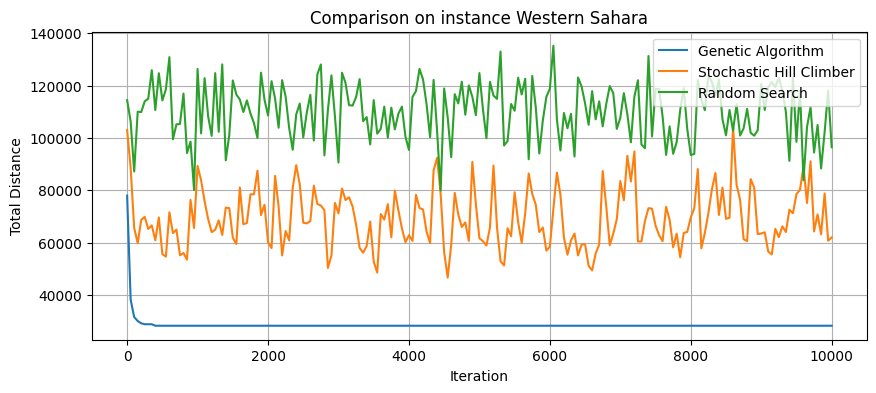





Runtime comparison on Djibouti Instances:
	 Genetic Algorithm 121.01438498497009s,
	 Stochastic Hill Climber 1.7253003120422363s,
	 Random Search 0.7574701309204102s

Total distance comparison on Djibouti Instances (best is 6656):
	 Genetic Algorithm 6659.431532931463s,
	 Stochastic Hill Climber 13539.131544369307s,
	 Random Search 21066.693973232166s


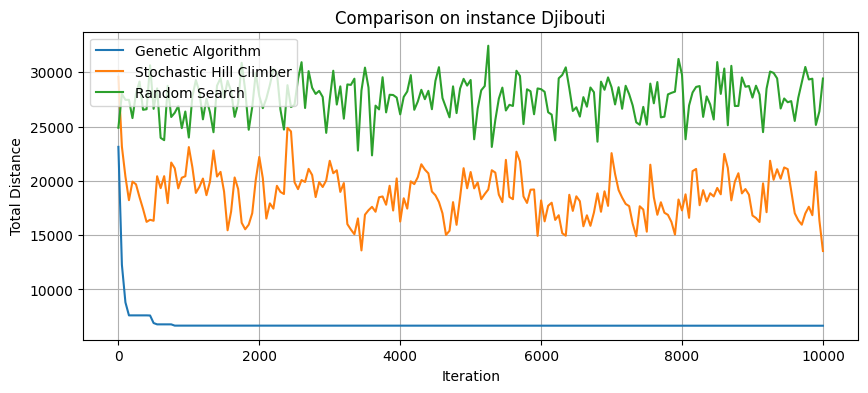





Runtime comparison on Qatar Instances:
	 Genetic Algorithm 546.7191319465637s,
	 Stochastic Hill Climber 7.581344127655029s,
	 Random Search 3.5461087226867676s

Total distance comparison on Qatar Instances (best is 9352):
	 Genetic Algorithm 12450.221452012682s,
	 Stochastic Hill Climber 48308.00643895848s,
	 Random Search 79274.07763087477s


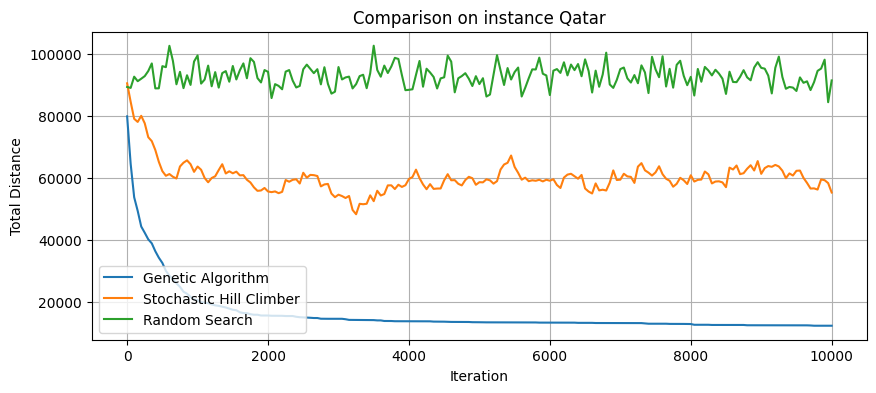

In [8]:
# ################## Experimental Evaluations ###############
# 
# I compared three algorithms on three isntances
# Algorithms: Genetic algorithms, random search, stochastic algorithms
# Instances: Western sahara, Djibouti, Qatar

import matplotlib.pyplot as plt

#  - Itration curves
ws_ga_curve = [sol.fitness for sol in ws_ga_logs]
ws_shc_curve = [sol.fitness for sol in ws_shc_logs]
ws_rs_curve = [sol.fitness for sol in ws_rs_logs]
dj_ga_curve = [sol.fitness for sol in dj_ga_logs]
dj_shc_curve = [sol.fitness for sol in dj_shc_logs]
dj_rs_curve = [sol.fitness for sol in dj_rs_logs]
qatar_ga_curve = [sol.fitness for sol in qatar_ga_logs]
qatar_shc_curve = [sol.fitness for sol in qatar_shc_logs]
qatar_rs_curve = [sol.fitness for sol in qatar_rs_logs]
def plot_comparison_curves(ga_curve, shc_curve, rs_curve, tag, points_num=200):
    plt.figure(figsize=(10, 4))
    # Draw curve of convergence
    interval = len(ga_curve) // points_num
    ga_values = [v for i, v in enumerate(ga_curve) if i % interval == 0]
    shc_values = [v for i, v in enumerate(shc_curve) if i % interval == 0]
    rs_values = [v for i, v in enumerate(rs_curve) if i % interval == 0]
    x_values = [item * interval for item in list(range(len(ga_values)))]
    plt.plot(x_values, ga_values, label="Genetic Algorithm")
    plt.plot(x_values, shc_values, label="Stochastic Hill Climber")
    plt.plot(x_values, rs_values, label="Random Search")
    plt.xlabel('Iteration')
    plt.ylabel('Total Distance')
    plt.title(f'Comparison on instance {tag}')
    plt.grid(True)
    plt.legend()
    plt.savefig(f"{tag}.png")
    plt.show()
    

# Prints Results
#  - Runtimes
#  - Objective function: Total Distance
print(f"Runtime comparison on Western Sahara Instances:")
print(f"\t Genetic Algorithm {ws_ga_runtime}s,\n\t Stochastic Hill Climber {ws_shc_runtime}s,\n\t Random Search {ws_rs_runtime}s\n")
print(f"Total distance comparison on Western Sahara Instances (best is {western_sahara_optimal}):")
print(f"\t Genetic Algorithm {ws_ga_best_sol.fitness}s,\n\t Stochastic Hill Climber {ws_shc_best_sol.fitness}s,\n\t Random Search {ws_rs_best_sol.fitness}s")
plot_comparison_curves(ws_ga_curve, ws_shc_curve, ws_rs_curve, "Western Sahara")
print("\n\n\n")


print(f"Runtime comparison on Djibouti Instances:")
print(f"\t Genetic Algorithm {dj_ga_runtime}s,\n\t Stochastic Hill Climber {dj_shc_runtime}s,\n\t Random Search {dj_rs_runtime}s\n")
print(f"Total distance comparison on Djibouti Instances (best is {djibouti_optimal}):")
print(f"\t Genetic Algorithm {dj_ga_best_sol.fitness}s,\n\t Stochastic Hill Climber {dj_shc_best_sol.fitness}s,\n\t Random Search {dj_rs_best_sol.fitness}s")
plot_comparison_curves(dj_ga_curve, dj_shc_curve, dj_rs_curve, "Djibouti")
print("\n\n\n")


print(f"Runtime comparison on Qatar Instances:")
print(f"\t Genetic Algorithm {qatar_ga_runtime}s,\n\t Stochastic Hill Climber {qatar_shc_runtime}s,\n\t Random Search {qatar_rs_runtime}s\n")
print(f"Total distance comparison on Qatar Instances (best is {qatar_optimal}):")
print(f"\t Genetic Algorithm {qatar_ga_best_sol.fitness}s,\n\t Stochastic Hill Climber {qatar_shc_best_sol.fitness}s,\n\t Random Search {qatar_rs_best_sol.fitness}s")
plot_comparison_curves(qatar_ga_curve, qatar_shc_curve, qatar_rs_curve, "Qatar")
print("\n\n\n")
